In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Fri Sep 20 15:49:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   32C    P8              24W / 215W |    461MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
os.chdir('../IConNet')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
dataset = 'text_emotion'
input_feature = 'signals_3channels_win5stride1'
output_label = 'labels_13emotions'
data_dir = f'../data/nlp/{dataset}/'
dataset = 'text_emotion'
input_feature = 'signals_3channels_win5stride1'
output_label = 'labels_13emotions'
data_dir = f'../data/nlp/{dataset}/'
data_path_prefix = f'{data_dir}preprocessed/{dataset}'
x_train = np.load(f'{data_path_prefix}.{input_feature}.train.npy', allow_pickle=True)
x_test = np.load(f'{data_path_prefix}.{input_feature}.test.npy', allow_pickle=True)
labels = np.load(f'{data_path_prefix}.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)
y_test = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)
print(f'Train: {x_train.shape}\t Test: {x_test.shape}')
print(f'Class names: {labels}')

Train: (8000, 3, 1024)	 Test: (8000, 3, 1024)
Class names: ['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']


In [7]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train, dtype=torch.float)
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test, dtype=torch.float)
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    return train_loader, test_loader

batch_size = 16
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [8]:
from IConNet.nn.model import M11
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m11text.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M11', 'description': '2-layer FirConv with LSTM for text emotion classification', 'fe': {'n_block': 2, 'n_channel': [128, 128], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'channel_concat', 'pooling': 'max', 'mel_resolution': 4, 'filter_type': 'firwin', 'conv_mode': 'strided_conv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 2, 'n_channel': 64, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256]}}

In [9]:
model = M11(config=model_config,
           n_input=3, n_output=len(labels))
model

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): Seq2SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [10]:
layer = model.fe_blocks.blocks[0].layer
from IConNet.visualizer import visualize_model
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000],
        [0.0036, 0.0036, 0.0036],
        [0.0075, 0.0075, 0.0075],
        [0.0117, 0.0117, 0.0117],
        [0.0162, 0.0162, 0.0162],
        [0.0211, 0.0211, 0.0211],
        [0.0264, 0.0264, 0.0264],
        [0.0322, 0.0322, 0.0322],
        [0.0384, 0.0384, 0.0384],
        [0.0451, 0.0451, 0.0451],
        [0.0524, 0.0524, 0.0524],
        [0.0603, 0.0603, 0.0603],
        [0.0688, 0.0688, 0.0688],
        [0.0780, 0.0780, 0.0780],
        [0.0880, 0.0880, 0.0880],
        [0.0988, 0.0988, 0.0988],
        [0.1105, 0.1105, 0.1105],
        [0.1231, 0.1231, 0.1231],
        [0.1368, 0.1368, 0.1368],
        [0.1516, 0.1516, 0.1516],
        [0.1676, 0.1676, 0.1676],
        [0.1849, 0.1849, 0.1849],
        [0.2036, 0.2036, 0.2036],
        [0.2239, 0.2239, 0.2239],
        [0.2458, 0.2458, 0.2458],
        [0.2696, 0.2696, 0.2696],
        [0.2952, 0.2952, 0.2952],
        [0.3230, 0.3230, 0.3230],
        [

In [11]:
print(visualize_model.count_parameters(model))

351117


In [12]:
visualize_model.count_parameters(model.fe_blocks)

181760

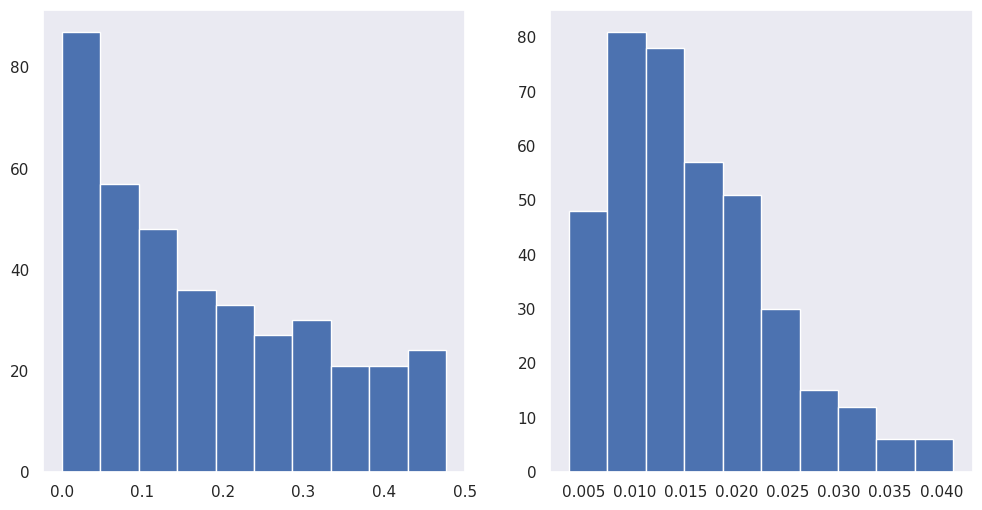

In [13]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = 75
)
filtviz.visualize_bands()

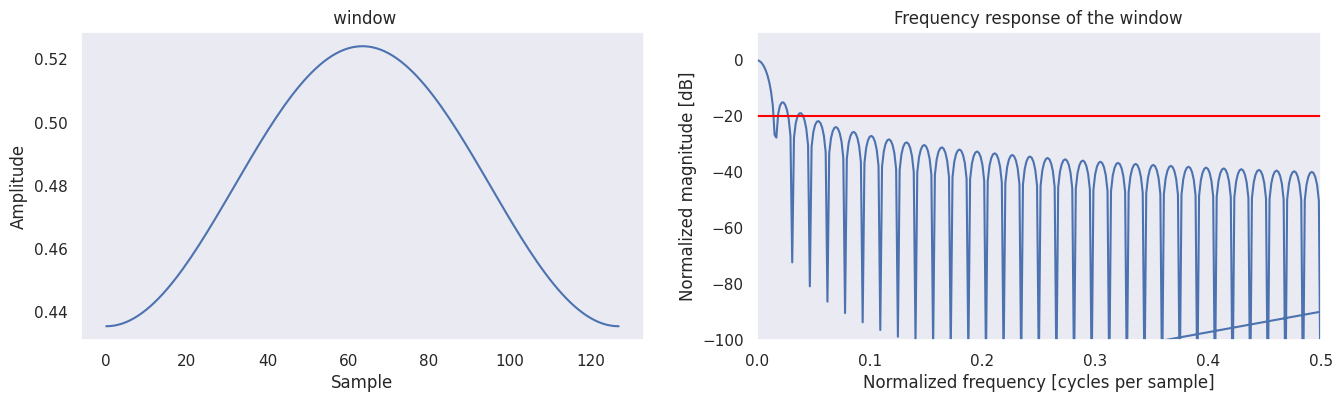

In [14]:
filtviz.visualize_one_window()

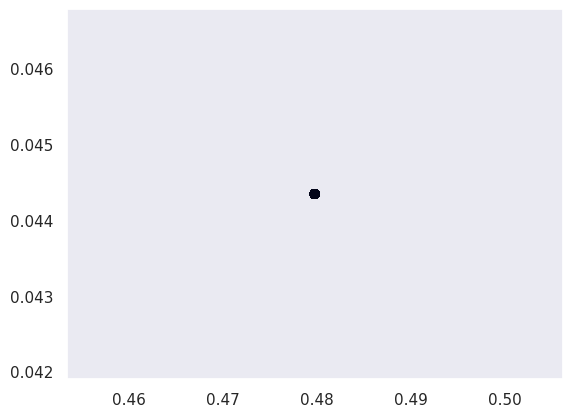

In [15]:
filtviz.visualize_window_params()

In [16]:
from IConNet.trainer.train_torch import Trainer_custom_model as Trainer

In [18]:
experiment_prefix = 'v6'
log_dir = f'./_logs/text_emotion/{experiment_prefix}/'

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8, gradient_clip_val=0.,
                 labels=labels)

trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size)
trainer.setup(model, lr=1e-4)

In [ ]:
trainer.fit(n_epoch=500, test_n_epoch=10)

  0%|                                    | 0.45818181818182024/500 [00:40<174:48:09, 1259.73s/it]

Epoch: 1	Loss: 2.032	Val_acc: 337/1600 (21.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=1.step=219.loss=2.032.val_acc=0.211.pt


  0%|▏                                      | 1.8199999999999608/500 [02:45<14:21:46, 103.79s/it]

Correct: 1699/8000 (0.2124)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=1.step=437.test_acc=0.2124.pt
{'acc_unweighted': tensor(0.0772),
 'acc_weighted': tensor(0.2124),
 'f1s_unweighted': tensor(0.0275),
 'f1s_weighted': tensor(0.0757),
 'rocauc': tensor(0.5346),
 'uar': tensor(0.0772),
 'wap': tensor(0.1960)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0041,
        0.0000, 0.0000, 0.0000, 1.0000]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0081,
        0.0000, 0.0000, 0.0000, 0.3495]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7000,
        0.0000, 0.0000, 0.0000, 0.2118]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0041,
        0.0000, 0.0000, 0.0000, 1.0000]),
 'rocauc_detail': tensor([0.4759, 0.5797, 0.5740, 0.4911, 0.5250, 0.5051, 0.5500, 0.5435, 0.5976,
        0.485

  0%|▏                                    | 2.2763636363636057/500 [03:24<172:42:04, 1249.14s/it]

Epoch: 2	Loss: 2.231	Val_acc: 338/1600 (21.12%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=2.step=656.loss=2.231.val_acc=0.211.pt


  1%|▏                                     | 3.185454545454576/500 [04:32<168:42:33, 1222.49s/it]

Epoch: 3	Loss: 2.178	Val_acc: 361/1600 (22.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=3.step=1093.loss=2.178.val_acc=0.226.pt


  1%|▎                                     | 4.094545454545546/500 [05:40<168:20:58, 1222.13s/it]

Epoch: 4	Loss: 2.123	Val_acc: 384/1600 (24.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=4.step=1530.loss=2.123.val_acc=0.240.pt


  1%|▍                                     | 5.003636363636517/500 [06:48<170:54:14, 1242.95s/it]

Epoch: 5	Loss: 2.085	Val_acc: 391/1600 (24.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=5.step=1967.loss=2.085.val_acc=0.244.pt


  1%|▍                                     | 5.912727272727487/500 [07:56<167:34:40, 1221.00s/it]

Epoch: 6	Loss: 2.026	Val_acc: 389/1600 (24.31%)



  1%|▌                                     | 6.821818181818458/500 [09:04<170:16:05, 1242.89s/it]

Epoch: 7	Loss: 2.352	Val_acc: 347/1600 (21.69%)



  2%|▌                                     | 7.730909090909428/500 [10:13<171:02:40, 1250.86s/it]

Epoch: 8	Loss: 2.476	Val_acc: 361/1600 (22.56%)



  2%|▋                                     | 8.640000000000398/500 [11:21<167:57:25, 1230.55s/it]

Epoch: 9	Loss: 2.140	Val_acc: 379/1600 (23.69%)



  2%|▋                                     | 9.549090909091369/500 [12:30<166:40:59, 1223.48s/it]

Epoch: 10	Loss: 1.937	Val_acc: 392/1600 (24.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=10.step=4152.loss=1.937.val_acc=0.245.pt


  2%|▊                                     | 10.45818181818234/500 [13:39<170:07:29, 1251.07s/it]

Epoch: 11	Loss: 2.284	Val_acc: 380/1600 (23.75%)



  2%|▉                                      | 11.820000000000613/500 [15:43<13:34:55, 100.16s/it]

Correct: 1977/8000 (0.2471)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=11.step=4807.test_acc=0.2471.pt
{'acc_unweighted': tensor(0.0887),
 'acc_weighted': tensor(0.2471),
 'f1s_unweighted': tensor(0.0527),
 'f1s_weighted': tensor(0.1466),
 'rocauc': tensor(0.5386),
 'uar': tensor(0.0887),
 'wap': tensor(0.1050)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6921,
        0.0000, 0.0000, 0.0000, 0.4616]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3722,
        0.0000, 0.0000, 0.0000, 0.3128]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2546,
        0.0000, 0.0000, 0.0000, 0.2365]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6921,
        0.0000, 0.0000, 0.0000, 0.4616]),
 'rocauc_detail': tensor([0.5141, 0.5127, 0.5736, 0.5542, 0.5552, 0.5113, 0.5480, 0.5268, 0.5966,
        0.5

  2%|▉                                     | 12.27636363636428/500 [16:22<166:02:51, 1225.64s/it]

Epoch: 12	Loss: 2.099	Val_acc: 372/1600 (23.25%)



  3%|█                                     | 13.18545454545525/500 [17:30<165:09:09, 1221.31s/it]

Epoch: 13	Loss: 2.273	Val_acc: 407/1600 (25.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=13.step=5463.loss=2.273.val_acc=0.254.pt


  3%|█                                    | 14.094545454546221/500 [18:37<164:54:54, 1221.83s/it]

Epoch: 14	Loss: 2.384	Val_acc: 401/1600 (25.06%)



  3%|█                                    | 15.003636363637192/500 [19:45<164:51:28, 1223.70s/it]

Epoch: 15	Loss: 1.812	Val_acc: 406/1600 (25.37%)



  3%|█▏                                   | 15.912727272728162/500 [20:53<164:06:18, 1220.40s/it]

Epoch: 16	Loss: 2.225	Val_acc: 404/1600 (25.25%)



  3%|█▎                                    | 16.82181818181833/500 [22:01<167:42:02, 1249.48s/it]

Epoch: 17	Loss: 2.397	Val_acc: 386/1600 (24.12%)



  4%|█▎                                   | 17.730909090908412/500 [23:09<163:53:38, 1223.42s/it]

Epoch: 18	Loss: 2.245	Val_acc: 406/1600 (25.37%)



  4%|█▍                                   | 18.639999999998494/500 [24:17<168:22:04, 1259.19s/it]

Epoch: 19	Loss: 2.295	Val_acc: 409/1600 (25.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=19.step=8085.loss=2.295.val_acc=0.256.pt


  4%|█▍                                   | 19.549090909088576/500 [25:25<166:56:33, 1250.90s/it]

Epoch: 20	Loss: 1.949	Val_acc: 406/1600 (25.37%)



  4%|█▌                                    | 20.45818181817866/500 [26:34<167:42:45, 1259.05s/it]

Epoch: 21	Loss: 2.102	Val_acc: 408/1600 (25.50%)



  4%|█▋                                      | 21.819999999995602/500 [28:38<13:08:14, 98.90s/it]

Correct: 2042/8000 (0.2552)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=21.step=9177.test_acc=0.2552.pt
{'acc_unweighted': tensor(0.0917),
 'acc_weighted': tensor(0.2553),
 'f1s_unweighted': tensor(0.0548),
 'f1s_weighted': tensor(0.1524),
 'rocauc': tensor(0.5486),
 'uar': tensor(0.0917),
 'wap': tensor(0.1088)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6655,
        0.0000, 0.0000, 0.0000, 0.5272]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3806,
        0.0000, 0.0000, 0.0000, 0.3318]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2665,
        0.0000, 0.0000, 0.0000, 0.2421]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6655,
        0.0000, 0.0000, 0.0000, 0.5272]),
 'rocauc_detail': tensor([0.5018, 0.5936, 0.5775, 0.5527, 0.5559, 0.5189, 0.5594, 0.5362, 0.6110,
        0.5

  4%|█▋                                   | 22.276363636358823/500 [29:17<162:25:01, 1223.93s/it]

Epoch: 22	Loss: 2.355	Val_acc: 410/1600 (25.62%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=22.step=9396.loss=2.355.val_acc=0.256.pt


  5%|█▋                                   | 23.185454545448906/500 [30:24<163:19:33, 1233.13s/it]

Epoch: 23	Loss: 1.856	Val_acc: 397/1600 (24.81%)



  5%|█▊                                   | 24.094545454538988/500 [31:32<142:04:53, 1074.78s/it]

Epoch: 24	Loss: 2.329	Val_acc: 404/1600 (25.25%)



  5%|█▉                                    | 25.00363636362907/500 [32:40<164:18:00, 1245.23s/it]

Epoch: 25	Loss: 2.050	Val_acc: 410/1600 (25.62%)



  5%|█▉                                   | 25.912727272719152/500 [33:48<161:06:36, 1223.40s/it]

Epoch: 26	Loss: 2.142	Val_acc: 407/1600 (25.44%)



  5%|█▉                                   | 26.821818181809235/500 [34:56<164:57:26, 1255.02s/it]

Epoch: 27	Loss: 1.837	Val_acc: 406/1600 (25.37%)



  6%|██                                   | 27.730909090899317/500 [36:03<160:16:41, 1221.76s/it]

Epoch: 28	Loss: 2.012	Val_acc: 398/1600 (24.88%)



  6%|██▏                                    | 28.6399999999894/500 [37:11<160:28:58, 1225.68s/it]

Epoch: 29	Loss: 2.443	Val_acc: 406/1600 (25.37%)



  6%|██▏                                   | 29.54909090907948/500 [38:19<161:23:01, 1234.95s/it]

Epoch: 30	Loss: 1.739	Val_acc: 406/1600 (25.37%)



  6%|██▎                                  | 30.458181818169564/500 [39:26<162:38:25, 1246.97s/it]

Epoch: 31	Loss: 2.207	Val_acc: 406/1600 (25.37%)



  6%|██▍                                    | 31.819999999986507/500 [41:31<13:02:51, 100.33s/it]

Correct: 2036/8000 (0.2545)
{'acc_unweighted': tensor(0.0915),
 'acc_weighted': tensor(0.2545),
 'f1s_unweighted': tensor(0.0548),
 'f1s_weighted': tensor(0.1525),
 'rocauc': tensor(0.5623),
 'uar': tensor(0.0915),
 'wap': tensor(0.1089)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6291,
        0.0000, 0.0000, 0.0000, 0.5609]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3795,
        0.0000, 0.0000, 0.0000, 0.3335]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2717,
        0.0000, 0.0000, 0.0000, 0.2373]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6291,
        0.0000, 0.0000, 0.0000, 0.5609]),
 'rocauc_detail': tensor([0.6122, 0.6400, 0.5743, 0.5718, 0.5562, 0.5216, 0.5552, 0.5338, 0.6167,
        0.5137, 0.5253, 0.5365, 0.5527])}
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,   10,  

  6%|██▍                                   | 32.27636363634973/500 [42:11<159:23:20, 1226.79s/it]

Epoch: 32	Loss: 1.923	Val_acc: 406/1600 (25.37%)



  7%|██▌                                   | 33.18545454543981/500 [43:18<161:32:15, 1245.75s/it]

Epoch: 33	Loss: 1.730	Val_acc: 398/1600 (24.88%)



  7%|██▌                                   | 34.09454545452989/500 [44:25<158:04:47, 1221.47s/it]

Epoch: 34	Loss: 2.235	Val_acc: 410/1600 (25.62%)



  7%|██▌                                  | 35.003636363619975/500 [45:33<160:00:43, 1238.81s/it]

Epoch: 35	Loss: 1.894	Val_acc: 407/1600 (25.44%)



  7%|██▋                                   | 35.91272727271006/500 [46:42<161:33:20, 1253.21s/it]

Epoch: 36	Loss: 2.207	Val_acc: 404/1600 (25.25%)



  7%|██▊                                   | 36.82181818180014/500 [47:49<157:27:27, 1223.82s/it]

Epoch: 37	Loss: 2.015	Val_acc: 398/1600 (24.88%)



  8%|██▊                                   | 37.73090909089022/500 [48:57<157:03:57, 1223.18s/it]

Epoch: 38	Loss: 2.124	Val_acc: 402/1600 (25.12%)



  8%|██▊                                  | 38.639999999980304/500 [50:05<157:58:20, 1232.66s/it]

Epoch: 39	Loss: 2.296	Val_acc: 390/1600 (24.38%)



  8%|███                                   | 39.54909090907039/500 [51:12<156:18:24, 1222.07s/it]

Epoch: 40	Loss: 1.918	Val_acc: 405/1600 (25.31%)



  8%|███                                   | 40.45818181816047/500 [52:20<156:00:26, 1222.15s/it]

Epoch: 41	Loss: 2.264	Val_acc: 424/1600 (26.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=41.step=17699.loss=2.264.val_acc=0.265.pt


  8%|███▎                                    | 41.81999999997741/500 [54:25<12:57:49, 101.86s/it]

Correct: 2086/8000 (0.2607)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=41.step=17917.test_acc=0.2607.pt
{'acc_unweighted': tensor(0.0938),
 'acc_weighted': tensor(0.2607),
 'f1s_unweighted': tensor(0.0563),
 'f1s_weighted': tensor(0.1566),
 'rocauc': tensor(0.5711),
 'uar': tensor(0.0938),
 'wap': tensor(0.1120)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6233,
        0.0000, 0.0000, 0.0000, 0.5963]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3884,
        0.0000, 0.0000, 0.0000, 0.3435]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2821,
        0.0000, 0.0000, 0.0000, 0.2413]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6233,
        0.0000, 0.0000, 0.0000, 0.5963]),
 'rocauc_detail': tensor([0.6275, 0.6805, 0.5876, 0.5381, 0.5624, 0.5209, 0.5716, 0.5402, 0.6244,
        0.

  8%|███▏                                  | 42.27636363634063/500 [55:04<156:02:12, 1227.23s/it]

Epoch: 42	Loss: 2.015	Val_acc: 411/1600 (25.69%)



  9%|███▏                                 | 43.185454545430716/500 [56:12<159:03:08, 1253.44s/it]

Epoch: 43	Loss: 2.339	Val_acc: 413/1600 (25.81%)



  9%|███▍                                   | 44.0945454545208/500 [57:19<155:02:50, 1224.31s/it]

Epoch: 44	Loss: 2.063	Val_acc: 420/1600 (26.25%)



  9%|███▍                                  | 45.00363636361088/500 [58:27<154:32:12, 1222.72s/it]

Epoch: 45	Loss: 2.270	Val_acc: 426/1600 (26.62%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=45.step=19447.loss=2.270.val_acc=0.266.pt


  9%|███▍                                  | 45.91272727270096/500 [59:34<154:32:45, 1225.24s/it]

Epoch: 46	Loss: 2.406	Val_acc: 421/1600 (26.31%)



  9%|███▎                               | 46.821818181791045/500 [1:00:42<153:59:15, 1223.26s/it]

Epoch: 47	Loss: 2.153	Val_acc: 423/1600 (26.44%)



 10%|███▍                                | 47.73090909088113/500 [1:01:50<154:45:11, 1231.81s/it]

Epoch: 48	Loss: 2.553	Val_acc: 402/1600 (25.12%)



 10%|███▌                                | 48.63999999997121/500 [1:02:59<158:52:20, 1267.15s/it]

Epoch: 49	Loss: 2.281	Val_acc: 407/1600 (25.44%)



 10%|███▌                                | 49.54909090906129/500 [1:04:07<156:54:15, 1253.98s/it]

Epoch: 50	Loss: 1.994	Val_acc: 420/1600 (26.25%)



 10%|███▌                               | 50.458181818151374/500 [1:05:15<157:36:57, 1262.21s/it]

Epoch: 51	Loss: 2.136	Val_acc: 419/1600 (26.19%)



 10%|████                                   | 51.81999999996832/500 [1:07:20<12:22:26, 99.39s/it]

Correct: 2104/8000 (0.2630)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=51.step=22287.test_acc=0.2630.pt
{'acc_unweighted': tensor(0.0945),
 'acc_weighted': tensor(0.2630),
 'f1s_unweighted': tensor(0.0563),
 'f1s_weighted': tensor(0.1565),
 'rocauc': tensor(0.5966),
 'uar': tensor(0.0945),
 'wap': tensor(0.1117)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7135,
        0.0000, 0.0000, 0.0000, 0.5148]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4002,
        0.0000, 0.0000, 0.0000, 0.3313]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2781,
        0.0000, 0.0000, 0.0000, 0.2443]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7135,
        0.0000, 0.0000, 0.0000, 0.5148]),
 'rocauc_detail': tensor([0.7071, 0.7521, 0.6072, 0.5780, 0.5791, 0.5231, 0.5978, 0.5558, 0.6512,
        0.

 10%|███▊                                | 52.27636363633154/500 [1:07:59<153:35:46, 1235.02s/it]

Epoch: 52	Loss: 2.117	Val_acc: 413/1600 (25.81%)



 11%|███▊                                | 53.18545454542162/500 [1:09:07<155:28:28, 1252.66s/it]

Epoch: 53	Loss: 1.747	Val_acc: 426/1600 (26.62%)



 11%|████                                 | 54.0945454545117/500 [1:10:14<155:19:05, 1253.96s/it]

Epoch: 54	Loss: 1.974	Val_acc: 425/1600 (26.56%)



 11%|███▊                               | 55.003636363601785/500 [1:11:22<151:26:38, 1225.17s/it]

Epoch: 55	Loss: 2.100	Val_acc: 416/1600 (26.00%)



 11%|████                                | 55.91272727269187/500 [1:12:31<153:43:37, 1246.19s/it]

Epoch: 56	Loss: 1.858	Val_acc: 436/1600 (27.25%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=56.step=24254.loss=1.858.val_acc=0.273.pt


 11%|████                                | 56.82181818178195/500 [1:13:39<151:44:52, 1232.67s/it]

Epoch: 57	Loss: 2.359	Val_acc: 432/1600 (27.00%)



 12%|████▏                               | 57.73090909087203/500 [1:14:46<150:15:21, 1223.06s/it]

Epoch: 58	Loss: 2.047	Val_acc: 436/1600 (27.25%)



 12%|████                               | 58.639999999962114/500 [1:15:54<150:01:19, 1223.67s/it]

Epoch: 59	Loss: 2.153	Val_acc: 437/1600 (27.31%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=59.step=25565.loss=2.153.val_acc=0.273.pt


 12%|████▍                                | 59.5490909090522/500 [1:17:02<149:46:41, 1224.20s/it]

Epoch: 60	Loss: 2.191	Val_acc: 435/1600 (27.19%)



 12%|████▎                               | 60.45818181814228/500 [1:18:10<149:29:54, 1224.44s/it]

Epoch: 61	Loss: 2.037	Val_acc: 451/1600 (28.19%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=61.step=26439.loss=2.037.val_acc=0.282.pt


 12%|████▊                                  | 61.81999999995922/500 [1:20:14<12:09:56, 99.95s/it]

Correct: 2255/8000 (0.2819)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=61.step=26657.test_acc=0.2819.pt
{'acc_unweighted': tensor(0.1015),
 'acc_weighted': tensor(0.2819),
 'f1s_unweighted': tensor(0.0616),
 'f1s_weighted': tensor(0.1715),
 'rocauc': tensor(0.6299),
 'uar': tensor(0.1015),
 'wap': tensor(0.1247)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6429,
        0.0000, 0.0000, 0.0000, 0.6761]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4461,
        0.0000, 0.0000, 0.0000, 0.3553]),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3415,
        0.0000, 0.0000, 0.0000, 0.2410]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6429,
        0.0000, 0.0000, 0.0000, 0.6761]),
 'rocauc_detail': tensor([0.7654, 0.8010, 0.6182, 0.5996, 0.6197, 0.5427, 0.6476, 0.5872, 0.7069,
        0.

 12%|████▍                               | 62.27636363632244/500 [1:20:53<149:42:04, 1231.20s/it]

Epoch: 62	Loss: 1.635	Val_acc: 464/1600 (29.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=62.step=26876.loss=1.635.val_acc=0.290.pt


 13%|████▍                              | 63.185454545412526/500 [1:22:01<148:48:07, 1226.35s/it]

Epoch: 63	Loss: 2.461	Val_acc: 447/1600 (27.94%)



 13%|████▌                               | 64.09454545450261/500 [1:23:09<148:27:17, 1226.04s/it]

Epoch: 64	Loss: 2.170	Val_acc: 463/1600 (28.94%)



 13%|████▋                               | 65.00363636359269/500 [1:24:16<149:40:30, 1238.70s/it]

Epoch: 65	Loss: 2.062	Val_acc: 473/1600 (29.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=65.step=28187.loss=2.062.val_acc=0.296.pt


 13%|████▋                               | 65.91272727268277/500 [1:25:24<151:30:13, 1256.46s/it]

Epoch: 66	Loss: 2.212	Val_acc: 471/1600 (29.44%)



 13%|████▊                               | 66.82181818177285/500 [1:26:33<151:07:17, 1255.92s/it]

Epoch: 67	Loss: 2.295	Val_acc: 494/1600 (30.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=67.step=29061.loss=2.295.val_acc=0.309.pt


 14%|████▉                               | 67.73090909086294/500 [1:27:41<148:46:08, 1238.97s/it]

Epoch: 68	Loss: 1.895	Val_acc: 486/1600 (30.38%)



 14%|████▉                               | 68.63999999995302/500 [1:28:49<146:45:45, 1224.84s/it]

Epoch: 69	Loss: 1.928	Val_acc: 484/1600 (30.25%)



 14%|█████▏                               | 69.5490909090431/500 [1:29:57<147:11:02, 1230.95s/it]

Epoch: 70	Loss: 2.182	Val_acc: 490/1600 (30.63%)



 14%|█████                               | 70.45818181813318/500 [1:31:05<148:05:37, 1241.18s/it]

Epoch: 71	Loss: 2.101	Val_acc: 483/1600 (30.19%)



 14%|█████▌                                 | 71.81999999995013/500 [1:33:10<11:52:09, 99.79s/it]

Correct: 2469/8000 (0.3086)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=71.step=31027.test_acc=0.3086.pt
{'acc_unweighted': tensor(0.1165),
 'acc_weighted': tensor(0.3086),
 'f1s_unweighted': tensor(0.0859),
 'f1s_weighted': tensor(0.2145),
 'rocauc': tensor(0.6731),
 'uar': tensor(0.1165),
 'wap': tensor(0.2227)}
{'acc_detail': tensor([0.0000, 0.0000, 0.0424, 0.0000, 0.0000, 0.0202, 0.0000, 0.0000, 0.5816,
        0.0000, 0.0571, 0.0000, 0.8138]),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0697, 0.0000, 0.0000, 0.0355, 0.0000, 0.0000, 0.5395,
        0.0000, 0.0961, 0.0000, 0.3762]),
 'precision_detail': tensor([0.0000, 0.0000, 0.1944, 0.0000, 0.0000, 0.1479, 0.0000, 0.0000, 0.5030,
        0.0000, 0.3026, 0.0000, 0.2446]),
 'recall_detail': tensor([0.0000, 0.0000, 0.0424, 0.0000, 0.0000, 0.0202, 0.0000, 0.0000, 0.5816,
        0.0000, 0.0571, 0.0000, 0.8138]),
 'rocauc_detail': tensor([0.7795, 0.8474, 0.6265, 0.6673, 0.6639, 0.5710, 0.6914, 0.6181, 0.7749,
        0.

 14%|█████▏                              | 72.27636363631335/500 [1:33:49<145:44:54, 1226.71s/it]

Epoch: 72	Loss: 2.377	Val_acc: 509/1600 (31.81%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=72.step=31246.loss=2.377.val_acc=0.318.pt


 15%|█████▎                              | 73.18545454540343/500 [1:34:57<146:28:14, 1235.42s/it]

Epoch: 73	Loss: 2.457	Val_acc: 498/1600 (31.13%)



 15%|█████▎                              | 74.09454545449351/500 [1:36:05<147:17:14, 1244.96s/it]

Epoch: 74	Loss: 1.953	Val_acc: 529/1600 (33.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=74.step=32120.loss=1.953.val_acc=0.331.pt


 15%|█████▌                               | 75.0036363635836/500 [1:37:13<147:37:32, 1250.49s/it]

Epoch: 75	Loss: 2.120	Val_acc: 522/1600 (32.62%)



 15%|█████▍                              | 75.91272727267368/500 [1:38:21<145:41:09, 1236.70s/it]

Epoch: 76	Loss: 1.615	Val_acc: 536/1600 (33.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=76.step=32994.loss=1.615.val_acc=0.335.pt


 15%|█████▌                              | 76.82181818176376/500 [1:39:29<144:08:59, 1226.29s/it]

Epoch: 77	Loss: 1.915	Val_acc: 541/1600 (33.81%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=77.step=33431.loss=1.915.val_acc=0.338.pt


 16%|█████▌                              | 77.73090909085384/500 [1:40:37<147:19:05, 1255.94s/it]

Epoch: 78	Loss: 1.719	Val_acc: 548/1600 (34.25%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=78.step=33868.loss=1.719.val_acc=0.343.pt


 16%|█████▋                              | 78.63999999994392/500 [1:41:46<146:56:23, 1255.42s/it]

Epoch: 79	Loss: 1.857	Val_acc: 545/1600 (34.06%)



 16%|██████                                | 79.549090909034/500 [1:42:54<144:34:29, 1237.88s/it]

Epoch: 80	Loss: 2.011	Val_acc: 567/1600 (35.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=80.step=34742.loss=2.011.val_acc=0.354.pt


 16%|█████▊                              | 80.45818181812409/500 [1:44:02<142:33:05, 1223.21s/it]

Epoch: 81	Loss: 1.657	Val_acc: 563/1600 (35.19%)



 16%|██████▏                               | 81.81999999994103/500 [1:46:06<11:49:07, 101.74s/it]

Correct: 2874/8000 (0.3593)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=81.step=35397.test_acc=0.3593.pt
{'acc_unweighted': tensor(0.1499),
 'acc_weighted': tensor(0.3593),
 'f1s_unweighted': tensor(0.1327),
 'f1s_weighted': tensor(0.2725),
 'rocauc': tensor(0.7402),
 'uar': tensor(0.1499),
 'wap': tensor(0.3658)}
{'acc_detail': tensor([0.0000, 0.1389, 0.0000, 0.0066, 0.0000, 0.0451, 0.0189, 0.0599, 0.6580,
        0.0000, 0.0707, 0.0389, 0.9119]),
 'f1s_detail': tensor([0.0000, 0.2381, 0.0000, 0.0131, 0.0000, 0.0770, 0.0350, 0.0950, 0.6580,
        0.0000, 0.1250, 0.0625, 0.4218]),
 'precision_detail': tensor([0.0000, 0.8333, 0.0000, 1.0000, 0.0000, 0.2640, 0.2381, 0.2300, 0.6580,
        0.0000, 0.5407, 0.1589, 0.2744]),
 'recall_detail': tensor([0.0000, 0.1389, 0.0000, 0.0066, 0.0000, 0.0451, 0.0189, 0.0599, 0.6580,
        0.0000, 0.0707, 0.0389, 0.9119]),
 'rocauc_detail': tensor([0.8338, 0.8295, 0.6973, 0.7205, 0.7338, 0.6176, 0.7915, 0.7061, 0.8731,
        0.

 16%|█████▉                              | 82.27636363630425/500 [1:46:45<143:09:12, 1233.72s/it]

Epoch: 82	Loss: 2.087	Val_acc: 590/1600 (36.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=82.step=35616.loss=2.087.val_acc=0.369.pt


 17%|█████▉                              | 83.18545454539434/500 [1:47:53<143:05:29, 1235.87s/it]

Epoch: 83	Loss: 2.061	Val_acc: 607/1600 (37.94%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=83.step=36053.loss=2.061.val_acc=0.379.pt


 17%|██████                              | 84.09454545448442/500 [1:49:01<144:14:15, 1248.49s/it]

Epoch: 84	Loss: 1.881	Val_acc: 608/1600 (38.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=84.step=36490.loss=1.881.val_acc=0.380.pt


 17%|██████▎                              | 85.0036363635745/500 [1:50:09<141:10:07, 1224.61s/it]

Epoch: 85	Loss: 2.027	Val_acc: 608/1600 (38.00%)



 17%|██████▏                             | 85.91272727266458/500 [1:51:17<146:28:48, 1273.47s/it]

Epoch: 86	Loss: 1.880	Val_acc: 597/1600 (37.31%)



 17%|██████▎                             | 86.82181818175467/500 [1:52:26<140:46:38, 1226.59s/it]

Epoch: 87	Loss: 1.764	Val_acc: 667/1600 (41.69%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=87.step=37801.loss=1.764.val_acc=0.417.pt


 18%|██████▎                             | 87.73090909084475/500 [1:53:33<140:32:46, 1227.27s/it]

Epoch: 88	Loss: 1.426	Val_acc: 634/1600 (39.62%)



 18%|██████▍                             | 88.63999999993483/500 [1:54:42<141:23:59, 1237.46s/it]

Epoch: 89	Loss: 2.049	Val_acc: 646/1600 (40.38%)



 18%|██████▍                             | 89.54909090902491/500 [1:55:50<139:46:19, 1225.92s/it]

Epoch: 90	Loss: 1.598	Val_acc: 668/1600 (41.75%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=90.step=39112.loss=1.598.val_acc=0.417.pt


 18%|██████▊                               | 90.458181818115/500 [1:56:58<143:32:52, 1261.83s/it]

Epoch: 91	Loss: 1.252	Val_acc: 698/1600 (43.62%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=91.step=39549.loss=1.252.val_acc=0.436.pt


 18%|██████▉                               | 91.81999999993194/500 [1:59:02<11:21:57, 100.24s/it]

Correct: 3447/8000 (0.4309)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=91.step=39767.test_acc=0.4309.pt
{'acc_unweighted': tensor(0.2162),
 'acc_weighted': tensor(0.4309),
 'f1s_unweighted': tensor(0.2140),
 'f1s_weighted': tensor(0.3678),
 'rocauc': tensor(0.8190),
 'uar': tensor(0.2162),
 'wap': tensor(0.5094)}
{'acc_detail': tensor([0.0000, 0.1667, 0.0061, 0.0066, 0.0789, 0.0422, 0.1547, 0.4271, 0.7402,
        0.0098, 0.1985, 0.1167, 0.8629]),
 'f1s_detail': tensor([0.0000, 0.2857, 0.0120, 0.0131, 0.1346, 0.0746, 0.2015, 0.3548, 0.7284,
        0.0195, 0.3042, 0.1650, 0.4883]),
 'precision_detail': tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.4590, 0.3212, 0.2887, 0.3034, 0.7169,
        1.0000, 0.6508, 0.2818, 0.3405]),
 'recall_detail': tensor([0.0000, 0.1667, 0.0061, 0.0066, 0.0789, 0.0422, 0.1547, 0.4271, 0.7402,
        0.0098, 0.1985, 0.1167, 0.8629]),
 'rocauc_detail': tensor([0.9028, 0.9179, 0.7738, 0.7824, 0.8076, 0.7128, 0.8669, 0.8070, 0.9254,
        0.

 18%|██████▋                             | 92.27636363629516/500 [1:59:41<138:58:22, 1227.06s/it]

Epoch: 92	Loss: 1.696	Val_acc: 693/1600 (43.31%)



 19%|██████▋                             | 93.18545454538524/500 [2:00:49<141:11:44, 1249.47s/it]

Epoch: 93	Loss: 1.771	Val_acc: 667/1600 (41.69%)



 19%|██████▊                             | 94.09454545447532/500 [2:01:58<139:44:09, 1239.33s/it]

Epoch: 94	Loss: 1.667	Val_acc: 719/1600 (44.94%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=94.step=40860.loss=1.667.val_acc=0.449.pt


 19%|███████                              | 95.0036363635654/500 [2:03:06<141:59:59, 1262.23s/it]

Epoch: 95	Loss: 1.308	Val_acc: 736/1600 (46.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=95.step=41297.loss=1.308.val_acc=0.460.pt


 19%|██████▉                             | 95.91272727265549/500 [2:04:15<139:10:19, 1239.88s/it]

Epoch: 96	Loss: 1.638	Val_acc: 775/1600 (48.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=96.step=41734.loss=1.638.val_acc=0.484.pt


 19%|██████▉                             | 96.82181818174557/500 [2:05:23<137:31:37, 1227.99s/it]

Epoch: 97	Loss: 1.880	Val_acc: 745/1600 (46.56%)



 20%|███████                             | 97.73090909083565/500 [2:06:31<136:55:00, 1225.30s/it]

Epoch: 98	Loss: 1.837	Val_acc: 785/1600 (49.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=98.step=42608.loss=1.837.val_acc=0.491.pt


 20%|███████                             | 98.63999999992573/500 [2:07:39<139:48:27, 1254.00s/it]

Epoch: 99	Loss: 1.508	Val_acc: 802/1600 (50.12%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=99.step=43045.loss=1.508.val_acc=0.501.pt


 20%|███████▏                            | 99.54909090901582/500 [2:08:48<137:48:16, 1238.85s/it]

Epoch: 100	Loss: 1.612	Val_acc: 806/1600 (50.38%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=100.step=43482.loss=1.612.val_acc=0.504.pt


 20%|███████▏                            | 100.4581818181059/500 [2:09:56<136:14:30, 1227.58s/it]

Epoch: 101	Loss: 0.912	Val_acc: 814/1600 (50.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=101.step=43919.loss=0.912.val_acc=0.509.pt


 20%|███████▌                             | 101.81999999992284/500 [2:12:01<11:05:06, 100.22s/it]

Correct: 4254/8000 (0.5317)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=101.step=44137.test_acc=0.5317.pt
{'acc_unweighted': tensor(0.3217),
 'acc_weighted': tensor(0.5318),
 'f1s_unweighted': tensor(0.3383),
 'f1s_weighted': tensor(0.5010),
 'rocauc': tensor(0.8839),
 'uar': tensor(0.3217),
 'wap': tensor(0.5699)}
{'acc_detail': tensor([0.0000, 0.3056, 0.0364, 0.0263, 0.2366, 0.3925, 0.3208, 0.4076, 0.8559,
        0.0295, 0.4230, 0.4188, 0.7293]),
 'f1s_detail': tensor([0.0000, 0.4490, 0.0690, 0.0513, 0.3471, 0.4052, 0.3672, 0.4742, 0.7489,
        0.0573, 0.5073, 0.3424, 0.5798]),
 'precision_detail': tensor([0.0000, 0.8462, 0.6667, 1.0000, 0.6512, 0.4186, 0.4293, 0.5670, 0.6656,
        1.0000, 0.6333, 0.2896, 0.4811]),
 'recall_detail': tensor([0.0000, 0.3056, 0.0364, 0.0263, 0.2366, 0.3925, 0.3208, 0.4076, 0.8559,
        0.0295, 0.4230, 0.4188, 0.7293]),
 'rocauc_detail': tensor([0.9490, 0.9344, 0.8531, 0.8564, 0.8741, 0.8172, 0.9196, 0.8862, 0.9521,
        0

 20%|███████▏                           | 102.27636363628606/500 [2:12:40<135:36:19, 1227.43s/it]

Epoch: 102	Loss: 1.688	Val_acc: 863/1600 (53.94%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=102.step=44356.loss=1.688.val_acc=0.539.pt


 21%|███████▏                           | 103.18545454537615/500 [2:13:48<135:25:36, 1228.63s/it]

Epoch: 103	Loss: 1.087	Val_acc: 865/1600 (54.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=103.step=44793.loss=1.087.val_acc=0.541.pt


 21%|███████▎                           | 104.09454545446623/500 [2:14:56<135:21:28, 1230.82s/it]

Epoch: 104	Loss: 1.366	Val_acc: 890/1600 (55.62%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=104.step=45230.loss=1.366.val_acc=0.556.pt


 21%|███████▎                           | 105.00363636355631/500 [2:16:05<138:52:36, 1265.72s/it]

Epoch: 105	Loss: 1.516	Val_acc: 880/1600 (55.00%)



 21%|███████▍                           | 105.91272727264639/500 [2:17:14<134:33:11, 1229.15s/it]

Epoch: 106	Loss: 0.991	Val_acc: 908/1600 (56.75%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=106.step=46104.loss=0.991.val_acc=0.568.pt


 21%|███████▍                           | 106.82181818173648/500 [2:18:22<134:17:19, 1229.57s/it]

Epoch: 107	Loss: 1.121	Val_acc: 967/1600 (60.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=107.step=46541.loss=1.121.val_acc=0.604.pt


 22%|███████▌                           | 107.73090909082656/500 [2:19:30<133:40:53, 1226.85s/it]

Epoch: 108	Loss: 1.358	Val_acc: 916/1600 (57.25%)



 22%|███████▌                           | 108.63999999991664/500 [2:20:39<135:57:36, 1250.66s/it]

Epoch: 109	Loss: 0.380	Val_acc: 934/1600 (58.38%)



 22%|███████▋                           | 109.54909090900672/500 [2:21:47<133:33:42, 1231.45s/it]

Epoch: 110	Loss: 1.083	Val_acc: 910/1600 (56.88%)



 22%|███████▉                            | 110.4581818180968/500 [2:22:57<132:45:48, 1226.95s/it]

Epoch: 111	Loss: 0.819	Val_acc: 912/1600 (57.00%)



 22%|████████▎                            | 111.81999999991375/500 [2:25:04<11:17:32, 104.73s/it]

Correct: 4782/8000 (0.5978)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=111.step=48507.test_acc=0.5978.pt
{'acc_unweighted': tensor(0.3753),
 'acc_weighted': tensor(0.5978),
 'f1s_unweighted': tensor(0.4078),
 'f1s_weighted': tensor(0.5646),
 'rocauc': tensor(0.9158),
 'uar': tensor(0.3753),
 'wap': tensor(0.6289)}
{'acc_detail': tensor([0.1818, 0.2500, 0.0364, 0.0461, 0.3521, 0.5432, 0.3547, 0.3164, 0.8958,
        0.0525, 0.5566, 0.4783, 0.8156]),
 'f1s_detail': tensor([0.2581, 0.4000, 0.0686, 0.0881, 0.4682, 0.5419, 0.4455, 0.4438, 0.7806,
        0.0979, 0.6173, 0.4629, 0.6286]),
 'precision_detail': tensor([0.4444, 1.0000, 0.6000, 1.0000, 0.6983, 0.5406, 0.5987, 0.7431, 0.6917,
        0.7273, 0.6928, 0.4485, 0.5113]),
 'recall_detail': tensor([0.1818, 0.2500, 0.0364, 0.0461, 0.3521, 0.5432, 0.3547, 0.3164, 0.8958,
        0.0525, 0.5566, 0.4783, 0.8156]),
 'rocauc_detail': tensor([0.9550, 0.9505, 0.8690, 0.9049, 0.9098, 0.8753, 0.9429, 0.9152, 0.9671,
        0

 22%|███████▊                           | 112.27636363627697/500 [2:25:45<135:46:26, 1260.66s/it]

Epoch: 112	Loss: 0.948	Val_acc: 956/1600 (59.75%)



 23%|███████▉                           | 113.18545454536705/500 [2:26:54<135:47:54, 1263.85s/it]

Epoch: 113	Loss: 1.272	Val_acc: 959/1600 (59.94%)



 23%|███████▉                           | 114.09454545445713/500 [2:28:03<134:27:51, 1254.38s/it]

Epoch: 114	Loss: 1.025	Val_acc: 985/1600 (61.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=114.step=49600.loss=1.025.val_acc=0.616.pt


 23%|████████                           | 115.00363636354722/500 [2:29:12<133:49:47, 1251.41s/it]

Epoch: 115	Loss: 1.003	Val_acc: 957/1600 (59.81%)



 23%|████████▎                           | 115.9127272726373/500 [2:30:22<132:15:59, 1239.72s/it]

Epoch: 116	Loss: 1.318	Val_acc: 990/1600 (61.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=116.step=50474.loss=1.318.val_acc=0.619.pt


 23%|████████▏                          | 116.82181818172738/500 [2:31:31<132:05:40, 1241.04s/it]

Epoch: 117	Loss: 1.272	Val_acc: 978/1600 (61.12%)



 24%|████████▏                          | 117.73090909081746/500 [2:32:40<132:49:15, 1250.84s/it]

Epoch: 118	Loss: 1.073	Val_acc: 1000/1600 (62.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=118.step=51348.loss=1.073.val_acc=0.625.pt


 24%|████████▎                          | 118.63999999990754/500 [2:33:49<131:55:14, 1245.32s/it]

Epoch: 119	Loss: 0.956	Val_acc: 1033/1600 (64.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=119.step=51785.loss=0.956.val_acc=0.646.pt


 24%|████████▎                          | 119.54909090899763/500 [2:34:59<134:35:02, 1273.49s/it]

Epoch: 120	Loss: 0.890	Val_acc: 999/1600 (62.44%)



 24%|████████▍                          | 120.45818181808771/500 [2:36:07<131:46:53, 1249.96s/it]

Epoch: 121	Loss: 1.036	Val_acc: 1054/1600 (65.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=121.step=52659.loss=1.036.val_acc=0.659.pt


 24%|█████████                            | 121.81999999990465/500 [2:38:14<10:35:57, 100.90s/it]

Correct: 5296/8000 (0.6620)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=121.step=52877.test_acc=0.6620.pt
{'acc_unweighted': tensor(0.4573),
 'acc_weighted': tensor(0.6620),
 'f1s_unweighted': tensor(0.5141),
 'f1s_weighted': tensor(0.6397),
 'rocauc': tensor(0.9435),
 'uar': tensor(0.4573),
 'wap': tensor(0.7058)}
{'acc_detail': tensor([0.3182, 0.3056, 0.1758, 0.1447, 0.3944, 0.5988, 0.3434, 0.5404, 0.9578,
        0.1475, 0.5150, 0.6522, 0.8511]),
 'f1s_detail': tensor([0.4516, 0.4681, 0.2900, 0.2444, 0.5374, 0.6287, 0.4866, 0.6667, 0.7879,
        0.2368, 0.6548, 0.5362, 0.6943]),
 'precision_detail': tensor([0.7778, 1.0000, 0.8286, 0.7857, 0.8434, 0.6617, 0.8349, 0.8700, 0.6692,
        0.6000, 0.8986, 0.4553, 0.5863]),
 'recall_detail': tensor([0.3182, 0.3056, 0.1758, 0.1447, 0.3944, 0.5988, 0.3434, 0.5404, 0.9578,
        0.1475, 0.5150, 0.6522, 0.8511]),
 'rocauc_detail': tensor([0.9862, 0.9554, 0.9199, 0.9246, 0.9397, 0.9187, 0.9613, 0.9566, 0.9815,
        0

 24%|████████▌                          | 122.27636363626787/500 [2:38:54<130:20:55, 1242.32s/it]

Epoch: 122	Loss: 0.928	Val_acc: 1020/1600 (63.75%)



 25%|████████▌                          | 123.18545454535796/500 [2:40:02<131:57:04, 1260.63s/it]

Epoch: 123	Loss: 0.964	Val_acc: 1056/1600 (66.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=123.step=53533.loss=0.964.val_acc=0.660.pt


 25%|████████▋                          | 124.09454545444804/500 [2:41:12<132:25:14, 1268.18s/it]

Epoch: 124	Loss: 0.492	Val_acc: 1059/1600 (66.19%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=124.step=53970.loss=0.492.val_acc=0.662.pt


 25%|████████▊                          | 125.00363636353812/500 [2:42:21<131:27:30, 1262.01s/it]

Epoch: 125	Loss: 0.771	Val_acc: 1080/1600 (67.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=125.step=54407.loss=0.771.val_acc=0.675.pt


 25%|█████████                           | 125.9127272726282/500 [2:43:30<131:30:55, 1265.63s/it]

Epoch: 126	Loss: 1.514	Val_acc: 1085/1600 (67.81%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=126.step=54844.loss=1.514.val_acc=0.678.pt


 25%|████████▉                          | 126.82181818171829/500 [2:44:39<128:07:15, 1235.97s/it]

Epoch: 127	Loss: 0.911	Val_acc: 1074/1600 (67.12%)



 26%|████████▉                          | 127.73090909080837/500 [2:45:48<131:28:43, 1271.46s/it]

Epoch: 128	Loss: 0.783	Val_acc: 1088/1600 (68.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=128.step=55718.loss=0.783.val_acc=0.680.pt


 26%|█████████                          | 128.63999999989846/500 [2:46:58<127:41:29, 1237.85s/it]

Epoch: 129	Loss: 0.915	Val_acc: 1139/1600 (71.19%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=129.step=56155.loss=0.915.val_acc=0.712.pt


 26%|█████████                          | 129.54909090898855/500 [2:48:06<128:19:48, 1247.10s/it]

Epoch: 130	Loss: 0.526	Val_acc: 1099/1600 (68.69%)



 26%|█████████▏                         | 130.45818181807863/500 [2:49:15<130:05:03, 1267.25s/it]

Epoch: 131	Loss: 1.119	Val_acc: 1112/1600 (69.50%)



 26%|█████████▊                           | 131.81999999989557/500 [2:51:23<10:20:03, 101.05s/it]

Correct: 5456/8000 (0.6820)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=131.step=57247.test_acc=0.6820.pt
{'acc_unweighted': tensor(0.5099),
 'acc_weighted': tensor(0.6820),
 'f1s_unweighted': tensor(0.5739),
 'f1s_weighted': tensor(0.6707),
 'rocauc': tensor(0.9449),
 'uar': tensor(0.5099),
 'wap': tensor(0.6961)}
{'acc_detail': tensor([0.4545, 0.3333, 0.2667, 0.2961, 0.4535, 0.6353, 0.4189, 0.6458, 0.8895,
        0.2131, 0.6805, 0.5263, 0.8156]),
 'f1s_detail': tensor([0.6250, 0.5000, 0.3860, 0.3947, 0.5699, 0.6314, 0.5564, 0.7025, 0.8464,
        0.3218, 0.7105, 0.5496, 0.6668]),
 'precision_detail': tensor([1.0000, 1.0000, 0.6984, 0.5921, 0.7667, 0.6275, 0.8284, 0.7702, 0.8072,
        0.6566, 0.7431, 0.5750, 0.5640]),
 'recall_detail': tensor([0.4545, 0.3333, 0.2667, 0.2961, 0.4535, 0.6353, 0.4189, 0.6458, 0.8895,
        0.2131, 0.6805, 0.5263, 0.8156]),
 'rocauc_detail': tensor([0.9848, 0.9500, 0.9097, 0.9269, 0.9439, 0.9233, 0.9650, 0.9544, 0.9812,
        0

 26%|█████████▌                          | 132.2763636362588/500 [2:52:02<126:30:55, 1238.58s/it]

Epoch: 132	Loss: 0.957	Val_acc: 1101/1600 (68.81%)



 27%|█████████▎                         | 133.18545454534888/500 [2:53:11<126:02:39, 1237.03s/it]

Epoch: 133	Loss: 0.802	Val_acc: 1103/1600 (68.94%)



 27%|█████████▍                         | 134.09454545443896/500 [2:54:19<126:02:26, 1240.06s/it]

Epoch: 134	Loss: 0.852	Val_acc: 1147/1600 (71.69%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=134.step=58340.loss=0.852.val_acc=0.717.pt


 27%|█████████▍                         | 135.00363636352904/500 [2:55:28<126:17:20, 1245.60s/it]

Epoch: 135	Loss: 1.019	Val_acc: 1121/1600 (70.06%)



 27%|█████████▌                         | 135.91272727261912/500 [2:56:36<128:06:10, 1266.65s/it]

Epoch: 136	Loss: 0.934	Val_acc: 1157/1600 (72.31%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=136.step=59214.loss=0.934.val_acc=0.723.pt


 27%|█████████▊                          | 136.8218181817092/500 [2:57:45<125:14:38, 1241.48s/it]

Epoch: 137	Loss: 0.601	Val_acc: 1174/1600 (73.38%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=137.step=59651.loss=0.601.val_acc=0.734.pt


 28%|█████████▉                          | 137.7309090907993/500 [2:58:54<127:59:27, 1271.89s/it]

Epoch: 138	Loss: 0.705	Val_acc: 1140/1600 (71.25%)



 28%|█████████▋                         | 138.63999999988937/500 [3:00:03<125:19:28, 1248.53s/it]

Epoch: 139	Loss: 0.700	Val_acc: 1131/1600 (70.69%)



 28%|█████████▊                         | 139.54909090897945/500 [3:01:12<126:35:22, 1264.31s/it]

Epoch: 140	Loss: 0.632	Val_acc: 1164/1600 (72.75%)



 28%|█████████▊                         | 140.45818181806953/500 [3:02:21<124:40:39, 1248.37s/it]

Epoch: 141	Loss: 0.801	Val_acc: 1189/1600 (74.31%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=141.step=61399.loss=0.801.val_acc=0.743.pt


 28%|██████████▍                          | 141.81999999988648/500 [3:04:26<10:09:38, 102.12s/it]

Correct: 5671/8000 (0.7089)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=141.step=61617.test_acc=0.7089.pt
{'acc_unweighted': tensor(0.5592),
 'acc_weighted': tensor(0.7089),
 'f1s_unweighted': tensor(0.5888),
 'f1s_weighted': tensor(0.7029),
 'rocauc': tensor(0.9625),
 'uar': tensor(0.5592),
 'wap': tensor(0.7524)}
{'acc_detail': tensor([0.5000, 0.3611, 0.2121, 0.2105, 0.7239, 0.6670, 0.6906, 0.6862, 0.9803,
        0.2918, 0.6660, 0.5721, 0.7074]),
 'f1s_detail': tensor([0.5641, 0.5306, 0.3431, 0.3478, 0.4746, 0.7049, 0.6289, 0.7219, 0.7979,
        0.4279, 0.7602, 0.5767, 0.7753]),
 'precision_detail': tensor([0.6471, 1.0000, 0.8974, 1.0000, 0.3530, 0.7473, 0.5773, 0.7616, 0.6728,
        0.8018, 0.8855, 0.5814, 0.8574]),
 'recall_detail': tensor([0.5000, 0.3611, 0.2121, 0.2105, 0.7239, 0.6670, 0.6906, 0.6862, 0.9803,
        0.2918, 0.6660, 0.5721, 0.7074]),
 'rocauc_detail': tensor([0.9913, 0.9747, 0.9462, 0.9522, 0.9643, 0.9463, 0.9765, 0.9663, 0.9874,
        0

 28%|██████████▏                         | 142.2763636362497/500 [3:05:06<125:44:04, 1265.35s/it]

Epoch: 142	Loss: 0.676	Val_acc: 1192/1600 (74.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=142.step=61836.loss=0.676.val_acc=0.745.pt


 29%|██████████                         | 143.18545454533978/500 [3:06:16<132:48:40, 1339.97s/it]

Epoch: 143	Loss: 0.892	Val_acc: 1174/1600 (73.38%)



 29%|██████████                         | 144.09454545442986/500 [3:07:26<124:58:27, 1264.12s/it]

Epoch: 144	Loss: 0.855	Val_acc: 1166/1600 (72.88%)



 29%|██████████▏                        | 145.00363636351995/500 [3:08:35<123:24:12, 1251.43s/it]

Epoch: 145	Loss: 0.728	Val_acc: 1180/1600 (73.75%)



 29%|██████████▏                        | 145.91272727261003/500 [3:09:44<122:26:52, 1244.92s/it]

Epoch: 146	Loss: 1.212	Val_acc: 1125/1600 (70.31%)



 29%|██████████▌                         | 146.8218181817001/500 [3:10:53<122:45:02, 1251.22s/it]

Epoch: 147	Loss: 1.022	Val_acc: 1116/1600 (69.75%)



 30%|██████████▋                         | 147.7309090907902/500 [3:12:01<121:43:10, 1243.91s/it]

Epoch: 148	Loss: 0.369	Val_acc: 1195/1600 (74.69%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=148.step=64458.loss=0.369.val_acc=0.747.pt


 30%|██████████▍                        | 148.63999999988027/500 [3:13:10<121:21:38, 1243.45s/it]

Epoch: 149	Loss: 0.849	Val_acc: 1187/1600 (74.19%)



 30%|██████████▍                        | 149.54909090897036/500 [3:14:19<123:03:00, 1264.03s/it]

Epoch: 150	Loss: 0.475	Val_acc: 1163/1600 (72.69%)



 30%|██████████▌                        | 150.45818181806044/500 [3:15:28<124:25:47, 1281.53s/it]

Epoch: 151	Loss: 0.446	Val_acc: 1182/1600 (73.88%)



 30%|███████████▌                          | 151.81999999987738/500 [3:17:34<9:47:52, 101.30s/it]

Correct: 6101/8000 (0.7626)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=151.step=65987.test_acc=0.7626.pt
{'acc_unweighted': tensor(0.6408),
 'acc_weighted': tensor(0.7626),
 'f1s_unweighted': tensor(0.6968),
 'f1s_weighted': tensor(0.7575),
 'rocauc': tensor(0.9695),
 'uar': tensor(0.6408),
 'wap': tensor(0.7765)}
{'acc_detail': tensor([0.6818, 0.5000, 0.4242, 0.4211, 0.6423, 0.6910, 0.6151, 0.7161, 0.9265,
        0.4295, 0.7212, 0.6751, 0.8871]),
 'f1s_detail': tensor([0.7143, 0.6667, 0.5534, 0.5639, 0.6899, 0.7276, 0.7118, 0.7671, 0.8751,
        0.5610, 0.7867, 0.6941, 0.7464]),
 'precision_detail': tensor([0.7500, 1.0000, 0.7955, 0.8533, 0.7451, 0.7684, 0.8446, 0.8258, 0.8291,
        0.8086, 0.8653, 0.7143, 0.6442]),
 'recall_detail': tensor([0.6818, 0.5000, 0.4242, 0.4211, 0.6423, 0.6910, 0.6151, 0.7161, 0.9265,
        0.4295, 0.7212, 0.6751, 0.8871]),
 'rocauc_detail': tensor([0.9940, 0.9790, 0.9640, 0.9548, 0.9705, 0.9496, 0.9796, 0.9767, 0.9869,
        0

 30%|██████████▉                         | 152.2763636362406/500 [3:18:14<122:47:18, 1271.24s/it]

Epoch: 152	Loss: 0.547	Val_acc: 1198/1600 (74.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=152.step=66206.loss=0.547.val_acc=0.749.pt


 31%|██████████▋                        | 153.18545454533069/500 [3:19:24<122:45:40, 1274.28s/it]

Epoch: 153	Loss: 0.431	Val_acc: 1240/1600 (77.50%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=153.step=66643.loss=0.431.val_acc=0.775.pt


 31%|██████████▊                        | 154.09454545442077/500 [3:20:33<119:55:29, 1248.11s/it]

Epoch: 154	Loss: 0.415	Val_acc: 1219/1600 (76.19%)



 31%|██████████▊                        | 155.00363636351085/500 [3:21:41<119:11:47, 1243.80s/it]

Epoch: 155	Loss: 0.807	Val_acc: 1207/1600 (75.44%)



 31%|██████████▉                        | 155.91272727260093/500 [3:22:51<119:16:52, 1247.97s/it]

Epoch: 156	Loss: 0.922	Val_acc: 1181/1600 (73.81%)



 31%|██████████▉                        | 156.82181818169101/500 [3:24:00<119:09:03, 1249.91s/it]

Epoch: 157	Loss: 0.802	Val_acc: 1191/1600 (74.44%)



 32%|███████████▎                        | 157.7309090907811/500 [3:25:08<118:21:31, 1244.90s/it]

Epoch: 158	Loss: 0.934	Val_acc: 1206/1600 (75.38%)



 32%|███████████                        | 158.63999999987118/500 [3:26:17<117:30:33, 1239.26s/it]

Epoch: 159	Loss: 1.073	Val_acc: 1201/1600 (75.06%)



 32%|███████████▏                       | 159.54909090896126/500 [3:27:26<118:03:24, 1248.36s/it]

Epoch: 160	Loss: 0.844	Val_acc: 1231/1600 (76.94%)



 32%|███████████▏                       | 160.45818181805134/500 [3:28:35<117:08:25, 1241.99s/it]

Epoch: 161	Loss: 0.539	Val_acc: 1218/1600 (76.12%)



 32%|████████████▌                          | 161.8199999998683/500 [3:30:41<9:45:07, 103.81s/it]

Correct: 6123/8000 (0.7654)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=161.step=70357.test_acc=0.7654.pt
{'acc_unweighted': tensor(0.6267),
 'acc_weighted': tensor(0.7654),
 'f1s_unweighted': tensor(0.6851),
 'f1s_weighted': tensor(0.7595),
 'rocauc': tensor(0.9728),
 'uar': tensor(0.6267),
 'wap': tensor(0.7672)}
{'acc_detail': tensor([0.4091, 0.4444, 0.3879, 0.5395, 0.6338, 0.7207, 0.6302, 0.7487, 0.9311,
        0.4918, 0.7667, 0.6041, 0.8387]),
 'f1s_detail': tensor([0.5806, 0.6154, 0.5203, 0.6189, 0.6966, 0.7518, 0.7152, 0.7571, 0.8559,
        0.5848, 0.7845, 0.6527, 0.7722]),
 'precision_detail': tensor([1.0000, 1.0000, 0.7901, 0.7257, 0.7732, 0.7856, 0.8267, 0.7656, 0.7918,
        0.7212, 0.8032, 0.7097, 0.7156]),
 'recall_detail': tensor([0.4091, 0.4444, 0.3879, 0.5395, 0.6338, 0.7207, 0.6302, 0.7487, 0.9311,
        0.4918, 0.7667, 0.6041, 0.8387]),
 'rocauc_detail': tensor([0.9988, 0.9695, 0.9612, 0.9701, 0.9729, 0.9619, 0.9834, 0.9731, 0.9878,
        0

 32%|███████████▋                        | 162.2763636362315/500 [3:31:20<116:24:39, 1240.90s/it]

Epoch: 162	Loss: 0.512	Val_acc: 1218/1600 (76.12%)



 33%|███████████▋                        | 163.1854545453216/500 [3:32:29<116:12:08, 1242.02s/it]

Epoch: 163	Loss: 0.711	Val_acc: 1247/1600 (77.94%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=163.step=71013.loss=0.711.val_acc=0.779.pt


 33%|███████████▍                       | 164.09454545441167/500 [3:33:38<116:15:08, 1245.91s/it]

Epoch: 164	Loss: 0.894	Val_acc: 1239/1600 (77.44%)



 33%|███████████▌                       | 165.00363636350176/500 [3:34:47<117:13:10, 1259.69s/it]

Epoch: 165	Loss: 0.599	Val_acc: 1191/1600 (74.44%)



 33%|███████████▌                       | 165.91272727259184/500 [3:35:55<114:53:45, 1238.08s/it]

Epoch: 166	Loss: 0.539	Val_acc: 1199/1600 (74.94%)



 33%|███████████▋                       | 166.82181818168192/500 [3:37:03<114:58:56, 1242.39s/it]

Epoch: 167	Loss: 0.694	Val_acc: 1236/1600 (77.25%)



 34%|████████████▍                        | 167.730909090772/500 [3:38:11<113:43:02, 1232.08s/it]

Epoch: 168	Loss: 0.645	Val_acc: 1210/1600 (75.62%)



 34%|███████████▊                       | 168.63999999986208/500 [3:39:20<116:05:02, 1261.17s/it]

Epoch: 169	Loss: 0.524	Val_acc: 1251/1600 (78.19%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=169.step=73635.loss=0.524.val_acc=0.782.pt


 34%|███████████▊                       | 169.54909090895217/500 [3:40:28<112:43:29, 1228.05s/it]

Epoch: 170	Loss: 0.686	Val_acc: 1224/1600 (76.50%)



 34%|███████████▉                       | 170.45818181804225/500 [3:41:36<112:44:27, 1231.61s/it]

Epoch: 171	Loss: 0.684	Val_acc: 1235/1600 (77.19%)



 34%|█████████████▍                         | 171.8199999998592/500 [3:43:41<9:09:18, 100.43s/it]

Correct: 6333/8000 (0.7916)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=171.step=74727.test_acc=0.7916.pt
{'acc_unweighted': tensor(0.6819),
 'acc_weighted': tensor(0.7916),
 'f1s_unweighted': tensor(0.7334),
 'f1s_weighted': tensor(0.7885),
 'rocauc': tensor(0.9781),
 'uar': tensor(0.6819),
 'wap': tensor(0.7992)}
{'acc_detail': tensor([0.5909, 0.5833, 0.4667, 0.5724, 0.6986, 0.7610, 0.6491, 0.7721, 0.9190,
        0.4885, 0.7696, 0.7162, 0.8771]),
 'f1s_detail': tensor([0.7027, 0.7241, 0.5833, 0.6667, 0.7230, 0.7592, 0.7661, 0.7731, 0.8911,
        0.6314, 0.8221, 0.7010, 0.7896]),
 'precision_detail': tensor([0.8667, 0.9545, 0.7778, 0.7982, 0.7492, 0.7574, 0.9348, 0.7742, 0.8649,
        0.8922, 0.8824, 0.6864, 0.7179]),
 'recall_detail': tensor([0.5909, 0.5833, 0.4667, 0.5724, 0.6986, 0.7610, 0.6491, 0.7721, 0.9190,
        0.4885, 0.7696, 0.7162, 0.8771]),
 'rocauc_detail': tensor([0.9988, 0.9863, 0.9677, 0.9679, 0.9791, 0.9679, 0.9852, 0.9768, 0.9891,
        0

 34%|████████████▍                       | 172.2763636362224/500 [3:44:21<114:10:12, 1254.14s/it]

Epoch: 172	Loss: 0.413	Val_acc: 1277/1600 (79.81%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=172.step=74946.loss=0.413.val_acc=0.798.pt


 35%|████████████▍                       | 173.1854545453125/500 [3:45:30<113:15:07, 1247.52s/it]

Epoch: 173	Loss: 0.336	Val_acc: 1257/1600 (78.56%)



 35%|████████████▏                      | 174.09454545440258/500 [3:46:38<111:59:28, 1237.07s/it]

Epoch: 174	Loss: 1.017	Val_acc: 1231/1600 (76.94%)



 35%|████████████▎                      | 175.00363636349266/500 [3:47:46<111:45:12, 1237.90s/it]

Epoch: 175	Loss: 0.876	Val_acc: 1254/1600 (78.38%)



 35%|████████████▎                      | 175.91272727258274/500 [3:48:54<112:48:40, 1253.12s/it]

Epoch: 176	Loss: 0.477	Val_acc: 1263/1600 (78.94%)



 35%|████████████▍                      | 176.82181818167282/500 [3:50:03<110:52:45, 1235.13s/it]

Epoch: 177	Loss: 0.331	Val_acc: 1270/1600 (79.38%)



 36%|████████████▊                       | 177.7309090907629/500 [3:51:11<110:27:41, 1233.94s/it]

Epoch: 178	Loss: 0.683	Val_acc: 1242/1600 (77.62%)



 36%|█████████████▏                       | 178.639999999853/500 [3:52:19<110:40:08, 1239.76s/it]

Epoch: 179	Loss: 0.973	Val_acc: 1277/1600 (79.81%)



 36%|████████████▌                      | 179.54909090894307/500 [3:53:27<110:07:06, 1237.09s/it]

Epoch: 180	Loss: 0.256	Val_acc: 1251/1600 (78.19%)



 36%|████████████▋                      | 180.45818181803315/500 [3:54:36<109:19:34, 1231.69s/it]

Epoch: 181	Loss: 1.071	Val_acc: 1292/1600 (80.75%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=181.step=78879.loss=1.071.val_acc=0.807.pt


 36%|██████████████▏                        | 181.8199999998501/500 [3:56:42<9:01:27, 102.11s/it]

Correct: 6351/8000 (0.7939)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=181.step=79097.test_acc=0.7939.pt
{'acc_unweighted': tensor(0.6878),
 'acc_weighted': tensor(0.7939),
 'f1s_unweighted': tensor(0.7439),
 'f1s_weighted': tensor(0.7917),
 'rocauc': tensor(0.9787),
 'uar': tensor(0.6878),
 'wap': tensor(0.8060)}
{'acc_detail': tensor([0.5909, 0.6111, 0.5818, 0.5329, 0.6535, 0.7217, 0.6868, 0.7292, 0.9097,
        0.5508, 0.8074, 0.6453, 0.9202]),
 'f1s_detail': tensor([0.7429, 0.7097, 0.6713, 0.6585, 0.7227, 0.7592, 0.7521, 0.7827, 0.9081,
        0.6680, 0.8093, 0.7103, 0.7760]),
 'precision_detail': tensor([1.0000, 0.8462, 0.7934, 0.8617, 0.8084, 0.8009, 0.8311, 0.8446, 0.9066,
        0.8485, 0.8113, 0.7899, 0.6708]),
 'recall_detail': tensor([0.5909, 0.6111, 0.5818, 0.5329, 0.6535, 0.7217, 0.6868, 0.7292, 0.9097,
        0.5508, 0.8074, 0.6453, 0.9202]),
 'rocauc_detail': tensor([0.9990, 0.9869, 0.9687, 0.9714, 0.9793, 0.9641, 0.9882, 0.9802, 0.9908,
        0

 36%|████████████▊                      | 182.27636363621332/500 [3:57:23<113:17:46, 1283.71s/it]

Epoch: 182	Loss: 0.471	Val_acc: 1226/1600 (76.62%)



 37%|█████████████▏                      | 183.1854545453034/500 [3:58:32<109:28:17, 1243.94s/it]

Epoch: 183	Loss: 0.242	Val_acc: 1314/1600 (82.12%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=183.step=79753.loss=0.242.val_acc=0.821.pt


 37%|████████████▉                      | 184.09454545439348/500 [3:59:42<109:19:23, 1245.83s/it]

Epoch: 184	Loss: 0.551	Val_acc: 1286/1600 (80.38%)



 37%|████████████▉                      | 185.00363636348357/500 [4:00:51<108:41:24, 1242.19s/it]

Epoch: 185	Loss: 1.173	Val_acc: 1260/1600 (78.75%)



 37%|█████████████                      | 185.91272727257365/500 [4:01:59<107:38:47, 1233.82s/it]

Epoch: 186	Loss: 0.586	Val_acc: 1296/1600 (81.00%)



 37%|█████████████                      | 186.82181818166373/500 [4:03:08<107:57:58, 1241.08s/it]

Epoch: 187	Loss: 0.593	Val_acc: 1292/1600 (80.75%)



 38%|█████████████▌                      | 187.7309090907538/500 [4:04:16<107:39:27, 1241.13s/it]

Epoch: 188	Loss: 0.481	Val_acc: 1267/1600 (79.19%)



 38%|█████████████▌                      | 188.6399999998439/500 [4:05:25<107:58:46, 1248.48s/it]

Epoch: 189	Loss: 0.640	Val_acc: 1284/1600 (80.25%)



 38%|█████████████▎                     | 189.54909090893398/500 [4:06:33<106:13:48, 1231.85s/it]

Epoch: 190	Loss: 0.854	Val_acc: 1284/1600 (80.25%)



 38%|█████████████▎                     | 190.45818181802406/500 [4:07:41<107:56:07, 1255.30s/it]

Epoch: 191	Loss: 0.574	Val_acc: 1280/1600 (80.00%)



 38%|███████████████▎                        | 191.819999999841/500 [4:09:46<8:37:29, 100.75s/it]

Correct: 6401/8000 (0.8001)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=191.step=83467.test_acc=0.8001.pt
{'acc_unweighted': tensor(0.6869),
 'acc_weighted': tensor(0.8001),
 'f1s_unweighted': tensor(0.7367),
 'f1s_weighted': tensor(0.7962),
 'rocauc': tensor(0.9800),
 'uar': tensor(0.6869),
 'wap': tensor(0.8124)}
{'acc_detail': tensor([0.5909, 0.5556, 0.5455, 0.5395, 0.7606, 0.8004, 0.7132, 0.6458, 0.9439,
        0.5082, 0.7638, 0.6476, 0.9155]),
 'f1s_detail': tensor([0.7027, 0.6897, 0.6272, 0.6694, 0.7219, 0.7805, 0.7426, 0.7607, 0.9064,
        0.6568, 0.8189, 0.6996, 0.8009]),
 'precision_detail': tensor([0.8667, 0.9091, 0.7377, 0.8817, 0.6870, 0.7616, 0.7746, 0.9254, 0.8717,
        0.9281, 0.8826, 0.7608, 0.7119]),
 'recall_detail': tensor([0.5909, 0.5556, 0.5455, 0.5395, 0.7606, 0.8004, 0.7132, 0.6458, 0.9439,
        0.5082, 0.7638, 0.6476, 0.9155]),
 'rocauc_detail': tensor([0.9977, 0.9821, 0.9671, 0.9789, 0.9842, 0.9689, 0.9872, 0.9754, 0.9923,
        0

 38%|█████████████▍                     | 192.27636363620422/500 [4:10:25<106:48:32, 1249.54s/it]

Epoch: 192	Loss: 0.757	Val_acc: 1276/1600 (79.75%)



 39%|█████████████▉                      | 193.1854545452943/500 [4:11:34<107:35:59, 1262.52s/it]

Epoch: 193	Loss: 1.054	Val_acc: 1325/1600 (82.81%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=193.step=84123.loss=1.054.val_acc=0.828.pt


 39%|█████████████▉                      | 194.0945454543844/500 [4:12:43<105:06:15, 1236.90s/it]

Epoch: 194	Loss: 0.453	Val_acc: 1302/1600 (81.38%)



 39%|█████████████▋                     | 195.00363636347447/500 [4:13:52<106:17:56, 1254.69s/it]

Epoch: 195	Loss: 0.877	Val_acc: 1319/1600 (82.44%)



 39%|█████████████▋                     | 195.91272727256455/500 [4:15:00<104:50:21, 1241.16s/it]

Epoch: 196	Loss: 0.783	Val_acc: 1255/1600 (78.44%)



 39%|█████████████▊                     | 196.82181818165463/500 [4:16:09<104:35:11, 1241.88s/it]

Epoch: 197	Loss: 0.624	Val_acc: 1287/1600 (80.44%)



 40%|█████████████▊                     | 197.73090909074472/500 [4:17:18<105:44:09, 1259.31s/it]

Epoch: 198	Loss: 0.641	Val_acc: 1334/1600 (83.38%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=198.step=86308.loss=0.641.val_acc=0.834.pt


 40%|██████████████▎                     | 198.6399999998348/500 [4:18:26<105:01:52, 1254.69s/it]

Epoch: 199	Loss: 0.947	Val_acc: 1308/1600 (81.75%)



 40%|█████████████▉                     | 199.54909090892488/500 [4:19:35<103:17:41, 1237.68s/it]

Epoch: 200	Loss: 0.598	Val_acc: 1298/1600 (81.12%)



 40%|██████████████                     | 200.45818181801496/500 [4:20:45<102:27:59, 1231.48s/it]

Epoch: 201	Loss: 0.844	Val_acc: 1315/1600 (82.19%)



 40%|████████████████▏                       | 201.8199999998319/500 [4:22:50<8:15:26, 99.69s/it]

Correct: 6726/8000 (0.8407)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=201.step=87837.test_acc=0.8407.pt
{'acc_unweighted': tensor(0.7355),
 'acc_weighted': tensor(0.8407),
 'f1s_unweighted': tensor(0.7831),
 'f1s_weighted': tensor(0.8386),
 'rocauc': tensor(0.9860),
 'uar': tensor(0.7355),
 'wap': tensor(0.8450)}
{'acc_detail': tensor([0.5000, 0.6389, 0.6182, 0.5658, 0.8225, 0.8417, 0.7170, 0.8359, 0.9606,
        0.6852, 0.7812, 0.6934, 0.9007]),
 'f1s_detail': tensor([0.6667, 0.7797, 0.6939, 0.6964, 0.7787, 0.8270, 0.8068, 0.7995, 0.9232,
        0.7518, 0.8526, 0.7500, 0.8547]),
 'precision_detail': tensor([1.0000, 1.0000, 0.7907, 0.9053, 0.7392, 0.8128, 0.9223, 0.7661, 0.8887,
        0.8327, 0.9384, 0.8167, 0.8132]),
 'recall_detail': tensor([0.5000, 0.6389, 0.6182, 0.5658, 0.8225, 0.8417, 0.7170, 0.8359, 0.9606,
        0.6852, 0.7812, 0.6934, 0.9007]),
 'rocauc_detail': tensor([0.9977, 0.9822, 0.9760, 0.9851, 0.9881, 0.9830, 0.9920, 0.9844, 0.9948,
        0

 40%|██████████████▏                    | 202.27636363619513/500 [4:23:29<101:27:11, 1226.75s/it]

Epoch: 202	Loss: 0.892	Val_acc: 1248/1600 (78.00%)



 41%|██████████████▋                     | 203.1854545452852/500 [4:24:37<101:42:48, 1233.66s/it]

Epoch: 203	Loss: 0.552	Val_acc: 1299/1600 (81.19%)



 41%|██████████████▋                     | 204.0945454543753/500 [4:25:45<101:25:45, 1233.99s/it]

Epoch: 204	Loss: 0.478	Val_acc: 1292/1600 (80.75%)



 41%|██████████████▎                    | 205.00363636346538/500 [4:26:54<102:00:08, 1244.79s/it]

Epoch: 205	Loss: 0.452	Val_acc: 1277/1600 (79.81%)



 41%|██████████████▍                    | 205.91272727255546/500 [4:28:02<100:28:24, 1229.92s/it]

Epoch: 206	Loss: 0.548	Val_acc: 1312/1600 (82.00%)



 41%|██████████████▍                    | 206.82181818164554/500 [4:29:10<102:49:05, 1262.53s/it]

Epoch: 207	Loss: 0.481	Val_acc: 1313/1600 (82.06%)



 42%|██████████████▌                    | 207.73090909073562/500 [4:30:19<102:53:39, 1267.39s/it]

Epoch: 208	Loss: 0.207	Val_acc: 1355/1600 (84.69%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=208.step=90678.loss=0.207.val_acc=0.847.pt


 42%|███████████████                     | 208.6399999998257/500 [4:31:29<103:09:26, 1274.60s/it]

Epoch: 209	Loss: 1.089	Val_acc: 1276/1600 (79.75%)



 42%|███████████████                     | 209.5490909089158/500 [4:32:39<102:08:23, 1265.97s/it]

Epoch: 210	Loss: 0.431	Val_acc: 1307/1600 (81.69%)



 42%|██████████████▋                    | 210.45818181800587/500 [4:33:49<104:14:49, 1296.15s/it]

Epoch: 211	Loss: 0.493	Val_acc: 1307/1600 (81.69%)



 42%|████████████████                      | 211.81818181800463/500 [4:35:55<8:38:57, 108.05s/it]

Correct: 6595/8000 (0.8244)
{'acc_unweighted': tensor(0.7306),
 'acc_weighted': tensor(0.8244),
 'f1s_unweighted': tensor(0.7778),
 'f1s_weighted': tensor(0.8215),
 'rocauc': tensor(0.9866),
 'uar': tensor(0.7306),
 'wap': tensor(0.8368)}


 42%|████████████████                      | 211.8199999998228/500 [4:35:56<10:18:09, 128.70s/it]

{'acc_detail': tensor([0.7273, 0.6389, 0.6303, 0.5987, 0.6394, 0.7054, 0.6943, 0.7982, 0.9612,
        0.6164, 0.8228, 0.7277, 0.9368]),
 'f1s_detail': tensor([0.7111, 0.7797, 0.7051, 0.7280, 0.7370, 0.8002, 0.7931, 0.8103, 0.9032,
        0.7189, 0.8590, 0.7527, 0.8137]),
 'precision_detail': tensor([0.6957, 1.0000, 0.8000, 0.9286, 0.8697, 0.9245, 0.9246, 0.8228, 0.8518,
        0.8624, 0.8985, 0.7794, 0.7191]),
 'recall_detail': tensor([0.7273, 0.6389, 0.6303, 0.5987, 0.6394, 0.7054, 0.6943, 0.7982, 0.9612,
        0.6164, 0.8228, 0.7277, 0.9368]),
 'rocauc_detail': tensor([0.9990, 0.9918, 0.9838, 0.9787, 0.9889, 0.9791, 0.9924, 0.9816, 0.9939,
        0.9829, 0.9868, 0.9831, 0.9836])}
tensor([[  16,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    5,
            0],
        [   0,   23,    0,    0,    1,    1,    0,    3,    1,    0,    0,    1,
            6],
        [   0,    0,  104,    1,    1,    4,    1,    8,   13,    0,    0,   18,
           15],
        [   

 42%|██████████████▊                    | 212.27636363618603/500 [4:36:36<100:35:57, 1258.70s/it]

Epoch: 212	Loss: 0.650	Val_acc: 1332/1600 (83.25%)



 43%|███████████████▎                    | 213.18545454527612/500 [4:37:46<98:55:15, 1241.62s/it]

Epoch: 213	Loss: 0.551	Val_acc: 1344/1600 (84.00%)



 43%|███████████████▊                     | 214.0945454543662/500 [4:38:54<99:33:11, 1253.53s/it]

Epoch: 214	Loss: 0.698	Val_acc: 1330/1600 (83.12%)



 43%|███████████████▍                    | 215.00363636345628/500 [4:40:02<98:11:19, 1240.30s/it]

Epoch: 215	Loss: 0.060	Val_acc: 1346/1600 (84.12%)



 43%|███████████████▌                    | 215.91272727254636/500 [4:41:10<97:58:27, 1241.55s/it]

Epoch: 216	Loss: 0.752	Val_acc: 1340/1600 (83.75%)



 43%|███████████████▌                    | 216.82181818163644/500 [4:42:18<96:53:53, 1231.85s/it]

Epoch: 217	Loss: 0.326	Val_acc: 1311/1600 (81.94%)



 44%|███████████████▋                    | 217.73090909072653/500 [4:43:27<99:05:10, 1263.73s/it]

Epoch: 218	Loss: 0.434	Val_acc: 1293/1600 (80.81%)



 44%|████████████████▏                    | 218.6399999998166/500 [4:44:36<96:42:19, 1237.34s/it]

Epoch: 219	Loss: 0.468	Val_acc: 1325/1600 (82.81%)



 44%|████████████████▏                    | 219.5490909089067/500 [4:45:44<96:07:06, 1233.82s/it]

Epoch: 220	Loss: 0.416	Val_acc: 1330/1600 (83.12%)



 44%|███████████████▊                    | 220.45818181799677/500 [4:46:52<96:34:56, 1243.81s/it]

Epoch: 221	Loss: 1.315	Val_acc: 1344/1600 (84.00%)



 44%|████████████████▊                     | 221.81999999981372/500 [4:48:58<7:43:39, 100.00s/it]

Correct: 6658/8000 (0.8323)
{'acc_unweighted': tensor(0.7318),
 'acc_weighted': tensor(0.8322),
 'f1s_unweighted': tensor(0.7790),
 'f1s_weighted': tensor(0.8298),
 'rocauc': tensor(0.9859),
 'uar': tensor(0.7318),
 'wap': tensor(0.8417)}
{'acc_detail': tensor([0.6364, 0.6944, 0.6061, 0.6447, 0.7972, 0.8100, 0.5962, 0.7604, 0.9329,
        0.5738, 0.8587, 0.6636, 0.9385]),
 'f1s_detail': tensor([0.7368, 0.8197, 0.6803, 0.7101, 0.7457, 0.8186, 0.7349, 0.8301, 0.9259,
        0.7056, 0.8566, 0.7342, 0.8284]),
 'precision_detail': tensor([0.8750, 1.0000, 0.7752, 0.7903, 0.7005, 0.8275, 0.9576, 0.9139, 0.9190,
        0.9162, 0.8545, 0.8215, 0.7414]),
 'recall_detail': tensor([0.6364, 0.6944, 0.6061, 0.6447, 0.7972, 0.8100, 0.5962, 0.7604, 0.9329,
        0.5738, 0.8587, 0.6636, 0.9385]),
 'rocauc_detail': tensor([0.9947, 0.9950, 0.9810, 0.9822, 0.9875, 0.9802, 0.9850, 0.9858, 0.9940,
        0.9791, 0.9886, 0.9796, 0.9846])}
tensor([[  14,    0,    0,    0,    6,    1,    0,    0,    0,  

 44%|████████████████                    | 222.27636363617694/500 [4:49:38<96:07:43, 1246.07s/it]

Epoch: 222	Loss: 0.475	Val_acc: 1339/1600 (83.69%)



 45%|████████████████                    | 223.18545454526702/500 [4:50:46<95:27:40, 1241.48s/it]

Epoch: 223	Loss: 0.605	Val_acc: 1367/1600 (85.44%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=223.step=97233.loss=0.605.val_acc=0.854.pt


 45%|████████████████▌                    | 224.0945454543571/500 [4:51:54<94:48:23, 1237.03s/it]

Epoch: 224	Loss: 0.159	Val_acc: 1343/1600 (83.94%)



 45%|████████████████▏                   | 225.00363636344719/500 [4:53:04<98:48:49, 1293.58s/it]

Epoch: 225	Loss: 0.214	Val_acc: 1347/1600 (84.19%)



 45%|████████████████▎                   | 225.91272727253727/500 [4:54:12<93:50:47, 1232.63s/it]

Epoch: 226	Loss: 0.767	Val_acc: 1329/1600 (83.06%)



 45%|████████████████▎                   | 226.82181818162735/500 [4:55:21<93:14:43, 1228.81s/it]

Epoch: 227	Loss: 0.617	Val_acc: 1357/1600 (84.81%)



 46%|████████████████▍                   | 227.73090909071743/500 [4:56:29<95:14:33, 1259.32s/it]

Epoch: 228	Loss: 0.579	Val_acc: 1370/1600 (85.62%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=228.step=99418.loss=0.579.val_acc=0.856.pt


 46%|████████████████▍                   | 228.63999999980751/500 [4:57:39<93:38:03, 1242.20s/it]

Epoch: 229	Loss: 0.338	Val_acc: 1330/1600 (83.12%)



 46%|████████████████▉                    | 229.5490909088976/500 [4:58:47<92:40:15, 1233.55s/it]

Epoch: 230	Loss: 1.019	Val_acc: 1315/1600 (82.19%)



 46%|████████████████▌                   | 230.45818181798768/500 [4:59:55<93:04:23, 1243.09s/it]

Epoch: 231	Loss: 0.850	Val_acc: 1301/1600 (81.31%)



 46%|█████████████████▌                    | 231.81999999980462/500 [5:02:02<7:29:23, 100.54s/it]

Correct: 6712/8000 (0.8390)
{'acc_unweighted': tensor(0.7672),
 'acc_weighted': tensor(0.8390),
 'f1s_unweighted': tensor(0.7992),
 'f1s_weighted': tensor(0.8388),
 'rocauc': tensor(0.9874),
 'uar': tensor(0.7672),
 'wap': tensor(0.8481)}
{'acc_detail': tensor([0.6818, 0.7222, 0.6364, 0.6842, 0.6958, 0.8215, 0.8642, 0.7969, 0.9369,
        0.5934, 0.8199, 0.8284, 0.8918]),
 'f1s_detail': tensor([0.8108, 0.8125, 0.7420, 0.7675, 0.7440, 0.8243, 0.7710, 0.8321, 0.9331,
        0.7358, 0.8603, 0.7183, 0.8383]),
 'precision_detail': tensor([1.0000, 0.9286, 0.8898, 0.8739, 0.7994, 0.8271, 0.6960, 0.8706, 0.9294,
        0.9679, 0.9049, 0.6340, 0.7909]),
 'recall_detail': tensor([0.6818, 0.7222, 0.6364, 0.6842, 0.6958, 0.8215, 0.8642, 0.7969, 0.9369,
        0.5934, 0.8199, 0.8284, 0.8918]),
 'rocauc_detail': tensor([0.9984, 0.9896, 0.9839, 0.9858, 0.9856, 0.9793, 0.9935, 0.9847, 0.9955,
        0.9837, 0.9884, 0.9859, 0.9818])}
tensor([[  15,    0,    0,    0,    0,    0,    7,    0,    0,  

 46%|████████████████▋                   | 232.27636363616784/500 [5:02:41<91:50:41, 1235.01s/it]

Epoch: 232	Loss: 0.721	Val_acc: 1303/1600 (81.44%)



 47%|████████████████▊                   | 233.18545454525793/500 [5:03:51<93:34:38, 1262.60s/it]

Epoch: 233	Loss: 0.406	Val_acc: 1379/1600 (86.19%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=233.step=101603.loss=0.406.val_acc=0.862.pt


 47%|█████████████████▊                    | 234.094545454348/500 [5:05:00<91:20:50, 1236.72s/it]

Epoch: 234	Loss: 0.447	Val_acc: 1354/1600 (84.62%)



 47%|█████████████████▍                   | 235.0036363634381/500 [5:06:09<92:24:05, 1255.28s/it]

Epoch: 235	Loss: 1.013	Val_acc: 1311/1600 (81.94%)



 47%|████████████████▉                   | 235.91272727252817/500 [5:07:18<92:20:28, 1258.78s/it]

Epoch: 236	Loss: 0.416	Val_acc: 1376/1600 (86.00%)



 47%|█████████████████                   | 236.82181818161826/500 [5:08:28<91:50:59, 1256.41s/it]

Epoch: 237	Loss: 0.568	Val_acc: 1366/1600 (85.38%)



 48%|█████████████████                   | 237.73090909070834/500 [5:09:37<90:19:20, 1239.80s/it]

Epoch: 238	Loss: 0.537	Val_acc: 1377/1600 (86.06%)



 48%|█████████████████▏                  | 238.63999999979842/500 [5:10:45<89:59:17, 1239.51s/it]

Epoch: 239	Loss: 0.240	Val_acc: 1363/1600 (85.19%)



 48%|█████████████████▋                   | 239.5490909088885/500 [5:11:54<91:28:50, 1264.46s/it]

Epoch: 240	Loss: 0.618	Val_acc: 1313/1600 (82.06%)



 48%|█████████████████▎                  | 240.45818181797858/500 [5:13:04<93:17:43, 1294.06s/it]

Epoch: 241	Loss: 0.196	Val_acc: 1346/1600 (84.12%)



 48%|██████████████████▍                   | 241.81999999979553/500 [5:15:11<7:16:10, 101.37s/it]

Correct: 6749/8000 (0.8436)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=241.step=105317.test_acc=0.8436.pt
{'acc_unweighted': tensor(0.7790),
 'acc_weighted': tensor(0.8436),
 'f1s_unweighted': tensor(0.7935),
 'f1s_weighted': tensor(0.8433),
 'rocauc': tensor(0.9893),
 'uar': tensor(0.7790),
 'wap': tensor(0.8536)}
{'acc_detail': tensor([0.7727, 0.7222, 0.8000, 0.6184, 0.8028, 0.8253, 0.7585, 0.7461, 0.9225,
        0.5672, 0.8490, 0.8215, 0.9208]),
 'f1s_detail': tensor([0.6939, 0.8125, 0.7333, 0.7581, 0.7862, 0.8354, 0.8056, 0.8209, 0.9324,
        0.7119, 0.8502, 0.7173, 0.8582]),
 'precision_detail': tensor([0.6296, 0.9286, 0.6769, 0.9792, 0.7703, 0.8456, 0.8590, 0.9124, 0.9426,
        0.9558, 0.8515, 0.6365, 0.8035]),
 'recall_detail': tensor([0.7727, 0.7222, 0.8000, 0.6184, 0.8028, 0.8253, 0.7585, 0.7461, 0.9225,
        0.5672, 0.8490, 0.8215, 0.9208]),
 'rocauc_detail': tensor([0.9983, 0.9937, 0.9909, 0.9891, 0.9910, 0.9810, 0.9921, 0.9858, 0.9945,
        

 48%|█████████████████▍                  | 242.27636363615875/500 [5:15:50<88:51:44, 1241.27s/it]

Epoch: 242	Loss: 1.011	Val_acc: 1330/1600 (83.12%)



 49%|█████████████████▌                  | 243.18545454524883/500 [5:16:59<89:42:16, 1257.47s/it]

Epoch: 243	Loss: 0.202	Val_acc: 1328/1600 (83.00%)



 49%|██████████████████                   | 244.0945454543389/500 [5:18:07<87:41:41, 1233.66s/it]

Epoch: 244	Loss: 0.652	Val_acc: 1338/1600 (83.62%)



 49%|██████████████████▌                   | 245.003636363429/500 [5:19:16<87:25:36, 1234.28s/it]

Epoch: 245	Loss: 0.872	Val_acc: 1393/1600 (87.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=245.step=106847.loss=0.872.val_acc=0.871.pt


 49%|█████████████████▋                  | 245.91272727251908/500 [5:20:25<87:22:46, 1238.02s/it]

Epoch: 246	Loss: 0.257	Val_acc: 1368/1600 (85.50%)



 49%|█████████████████▊                  | 246.82181818160916/500 [5:21:34<87:17:15, 1241.16s/it]

Epoch: 247	Loss: 0.498	Val_acc: 1335/1600 (83.44%)



 50%|█████████████████▊                  | 247.73090909069924/500 [5:22:43<87:56:13, 1254.90s/it]

Epoch: 248	Loss: 0.241	Val_acc: 1378/1600 (86.12%)



 50%|█████████████████▉                  | 248.63999999978932/500 [5:23:52<87:36:04, 1254.63s/it]

Epoch: 249	Loss: 0.131	Val_acc: 1347/1600 (84.19%)



 50%|██████████████████▍                  | 249.5490909088794/500 [5:25:00<86:34:18, 1244.39s/it]

Epoch: 250	Loss: 0.168	Val_acc: 1374/1600 (85.88%)



 50%|██████████████████▌                  | 250.4581818179695/500 [5:26:09<86:15:15, 1244.34s/it]

Epoch: 251	Loss: 0.704	Val_acc: 1398/1600 (87.38%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=251.step=109469.loss=0.704.val_acc=0.874.pt


 50%|███████████████████▏                  | 251.81999999978643/500 [5:28:17<6:58:00, 101.06s/it]

Correct: 6685/8000 (0.8356)
{'acc_unweighted': tensor(0.7517),
 'acc_weighted': tensor(0.8356),
 'f1s_unweighted': tensor(0.7826),
 'f1s_weighted': tensor(0.8342),
 'rocauc': tensor(0.9875),
 'uar': tensor(0.7517),
 'wap': tensor(0.8413)}
{'acc_detail': tensor([0.7273, 0.6667, 0.6364, 0.5724, 0.8761, 0.8340, 0.6868, 0.8229, 0.9416,
        0.6197, 0.8006, 0.6934, 0.8942]),
 'f1s_detail': tensor([0.7442, 0.8000, 0.6709, 0.6824, 0.7476, 0.8253, 0.7811, 0.8092, 0.9271,
        0.7297, 0.8456, 0.7681, 0.8429]),
 'precision_detail': tensor([0.7619, 1.0000, 0.7095, 0.8447, 0.6520, 0.8167, 0.9055, 0.7960, 0.9130,
        0.8873, 0.8960, 0.8608, 0.7972]),
 'recall_detail': tensor([0.7273, 0.6667, 0.6364, 0.5724, 0.8761, 0.8340, 0.6868, 0.8229, 0.9416,
        0.6197, 0.8006, 0.6934, 0.8942]),
 'rocauc_detail': tensor([0.9983, 0.9930, 0.9821, 0.9843, 0.9897, 0.9815, 0.9915, 0.9837, 0.9946,
        0.9862, 0.9859, 0.9858, 0.9810])}
tensor([[  16,    0,    0,    0,    3,    0,    0,    0,    0,  

 50%|██████████████████▏                 | 252.27636363614965/500 [5:28:56<87:01:18, 1264.63s/it]

Epoch: 252	Loss: 0.625	Val_acc: 1337/1600 (83.56%)



 51%|██████████████████▏                 | 253.18545454523974/500 [5:30:04<84:28:49, 1232.22s/it]

Epoch: 253	Loss: 0.654	Val_acc: 1372/1600 (85.75%)



 51%|██████████████████▎                 | 254.09454545432982/500 [5:31:14<84:34:02, 1238.05s/it]

Epoch: 254	Loss: 0.474	Val_acc: 1304/1600 (81.50%)



 51%|██████████████████▊                  | 255.0036363634199/500 [5:32:22<84:24:19, 1240.26s/it]

Epoch: 255	Loss: 0.405	Val_acc: 1369/1600 (85.56%)



 51%|██████████████████▍                 | 255.91272727250998/500 [5:33:31<83:45:44, 1235.40s/it]

Epoch: 256	Loss: 0.276	Val_acc: 1354/1600 (84.62%)



 51%|██████████████████▍                 | 256.82181818160007/500 [5:34:39<83:46:24, 1240.18s/it]

Epoch: 257	Loss: 0.345	Val_acc: 1362/1600 (85.12%)



 52%|██████████████████▌                 | 257.73090909069015/500 [5:35:48<83:15:30, 1237.18s/it]

Epoch: 258	Loss: 0.644	Val_acc: 1358/1600 (84.88%)



 52%|██████████████████▌                 | 258.63999999978023/500 [5:36:57<83:24:10, 1243.99s/it]

Epoch: 259	Loss: 0.458	Val_acc: 1350/1600 (84.38%)



 52%|███████████████████▏                 | 259.5490909088703/500 [5:38:06<83:04:48, 1243.87s/it]

Epoch: 260	Loss: 0.811	Val_acc: 1354/1600 (84.62%)



 52%|███████████████████▎                 | 260.4581818179604/500 [5:39:14<82:36:45, 1241.56s/it]

Epoch: 261	Loss: 0.462	Val_acc: 1390/1600 (86.88%)



 52%|███████████████████▉                  | 261.81999999977734/500 [5:41:21<6:37:15, 100.07s/it]

Correct: 7051/8000 (0.8814)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=261.step=114057.test_acc=0.8814.pt
{'acc_unweighted': tensor(0.8065),
 'acc_weighted': tensor(0.8814),
 'f1s_unweighted': tensor(0.8416),
 'f1s_weighted': tensor(0.8804),
 'rocauc': tensor(0.9940),
 'uar': tensor(0.8065),
 'wap': tensor(0.8836)}
{'acc_detail': tensor([0.7727, 0.6667, 0.6848, 0.6711, 0.8225, 0.8800, 0.7811, 0.8151, 0.9491,
        0.7508, 0.9013, 0.8558, 0.9332]),
 'f1s_detail': tensor([0.8293, 0.7869, 0.7661, 0.7757, 0.8403, 0.8586, 0.8571, 0.8682, 0.9444,
        0.8121, 0.8841, 0.8238, 0.8939]),
 'precision_detail': tensor([0.8947, 0.9600, 0.8692, 0.9189, 0.8588, 0.8382, 0.9495, 0.9288, 0.9398,
        0.8842, 0.8677, 0.7941, 0.8577]),
 'recall_detail': tensor([0.7727, 0.6667, 0.6848, 0.6711, 0.8225, 0.8800, 0.7811, 0.8151, 0.9491,
        0.7508, 0.9013, 0.8558, 0.9332]),
 'rocauc_detail': tensor([0.9997, 0.9978, 0.9938, 0.9940, 0.9953, 0.9900, 0.9956, 0.9927, 0.9969,
        

 52%|██████████████████▉                 | 262.27636363614056/500 [5:42:00<81:54:39, 1240.43s/it]

Epoch: 262	Loss: 0.508	Val_acc: 1377/1600 (86.06%)



 53%|██████████████████▉                 | 263.18545454523064/500 [5:43:09<81:26:04, 1237.95s/it]

Epoch: 263	Loss: 0.311	Val_acc: 1382/1600 (86.38%)



 53%|███████████████████▌                 | 264.0945454543207/500 [5:44:18<81:13:16, 1239.47s/it]

Epoch: 264	Loss: 0.699	Val_acc: 1385/1600 (86.56%)



 53%|███████████████████▌                 | 265.0036363634108/500 [5:45:27<82:42:15, 1266.98s/it]

Epoch: 265	Loss: 0.135	Val_acc: 1377/1600 (86.06%)



 53%|███████████████████▋                 | 265.9127272725009/500 [5:46:36<80:23:54, 1236.44s/it]

Epoch: 266	Loss: 0.601	Val_acc: 1361/1600 (85.06%)



 53%|███████████████████▏                | 266.82181818159097/500 [5:47:45<82:12:02, 1269.08s/it]

Epoch: 267	Loss: 0.320	Val_acc: 1371/1600 (85.69%)



 54%|███████████████████▎                | 267.73090909068105/500 [5:48:54<80:38:07, 1249.79s/it]

Epoch: 268	Loss: 0.295	Val_acc: 1395/1600 (87.19%)



 54%|███████████████████▎                | 268.63999999977113/500 [5:50:02<80:45:04, 1256.50s/it]

Epoch: 269	Loss: 0.530	Val_acc: 1328/1600 (83.00%)



 54%|███████████████████▉                 | 269.5490909088612/500 [5:51:11<79:37:47, 1243.94s/it]

Epoch: 270	Loss: 0.116	Val_acc: 1424/1600 (89.00%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=270.step=117772.loss=0.116.val_acc=0.890.pt


 54%|████████████████████                 | 270.4581818179513/500 [5:52:21<80:52:22, 1268.36s/it]

Epoch: 271	Loss: 0.825	Val_acc: 1417/1600 (88.56%)



 54%|████████████████████▋                 | 271.81999999976824/500 [5:54:27<6:27:36, 101.92s/it]

Correct: 7038/8000 (0.8798)
{'acc_unweighted': tensor(0.8122),
 'acc_weighted': tensor(0.8798),
 'f1s_unweighted': tensor(0.8489),
 'f1s_weighted': tensor(0.8791),
 'rocauc': tensor(0.9935),
 'uar': tensor(0.8122),
 'wap': tensor(0.8835)}
{'acc_detail': tensor([0.8182, 0.6389, 0.7212, 0.7303, 0.7521, 0.8906, 0.7962, 0.8893, 0.9502,
        0.7574, 0.8374, 0.8490, 0.9273]),
 'f1s_detail': tensor([0.8780, 0.7797, 0.8068, 0.7986, 0.8279, 0.8561, 0.8665, 0.8443, 0.9364,
        0.8134, 0.8927, 0.8432, 0.8925]),
 'precision_detail': tensor([0.9474, 1.0000, 0.9154, 0.8810, 0.9207, 0.8242, 0.9505, 0.8035, 0.9230,
        0.8783, 0.9558, 0.8375, 0.8602]),
 'recall_detail': tensor([0.8182, 0.6389, 0.7212, 0.7303, 0.7521, 0.8906, 0.7962, 0.8893, 0.9502,
        0.7574, 0.8374, 0.8490, 0.9273]),
 'rocauc_detail': tensor([0.9996, 0.9981, 0.9928, 0.9914, 0.9953, 0.9892, 0.9960, 0.9924, 0.9968,
        0.9880, 0.9934, 0.9921, 0.9904])}
tensor([[  18,    0,    0,    0,    1,    0,    1,    0,    0,  

 54%|███████████████████▌                | 272.27636363613146/500 [5:55:06<79:22:53, 1254.92s/it]

Epoch: 272	Loss: 0.332	Val_acc: 1372/1600 (85.75%)



 55%|███████████████████▋                | 273.18545454522155/500 [5:56:15<79:22:26, 1259.82s/it]

Epoch: 273	Loss: 0.235	Val_acc: 1378/1600 (86.12%)



 55%|████████████████████▎                | 274.0945454543116/500 [5:57:24<77:43:47, 1238.69s/it]

Epoch: 274	Loss: 0.155	Val_acc: 1400/1600 (87.50%)



 55%|████████████████████▎                | 275.0036363634017/500 [5:58:32<78:07:06, 1249.92s/it]

Epoch: 275	Loss: 0.184	Val_acc: 1400/1600 (87.50%)



 55%|████████████████████▍                | 275.9127272724918/500 [5:59:41<77:12:11, 1240.28s/it]

Epoch: 276	Loss: 0.392	Val_acc: 1371/1600 (85.69%)



 55%|████████████████████▍                | 276.8218181815819/500 [6:00:49<76:48:18, 1238.91s/it]

Epoch: 277	Loss: 0.509	Val_acc: 1386/1600 (86.62%)



 56%|███████████████████▉                | 277.73090909067196/500 [6:01:57<76:19:59, 1236.33s/it]

Epoch: 278	Loss: 0.290	Val_acc: 1382/1600 (86.38%)



 56%|████████████████████                | 278.63999999976204/500 [6:03:05<76:31:02, 1244.41s/it]

Epoch: 279	Loss: 0.166	Val_acc: 1399/1600 (87.44%)



 56%|████████████████████▋                | 279.5490909088521/500 [6:04:14<75:53:02, 1239.20s/it]

Epoch: 280	Loss: 0.220	Val_acc: 1428/1600 (89.25%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=280.step=122142.loss=0.220.val_acc=0.892.pt


 56%|████████████████████▊                | 280.4581818179422/500 [6:05:23<75:40:44, 1240.97s/it]

Epoch: 281	Loss: 0.413	Val_acc: 1399/1600 (87.44%)



 56%|█████████████████████▍                | 281.81999999975915/500 [6:07:29<6:11:38, 102.20s/it]

Correct: 6867/8000 (0.8584)
{'acc_unweighted': tensor(0.8057),
 'acc_weighted': tensor(0.8584),
 'f1s_unweighted': tensor(0.8208),
 'f1s_weighted': tensor(0.8587),
 'rocauc': tensor(0.9902),
 'uar': tensor(0.8057),
 'wap': tensor(0.8652)}
{'acc_detail': tensor([0.7727, 0.6667, 0.7333, 0.6974, 0.8930, 0.8186, 0.8528, 0.7839, 0.9016,
        0.8197, 0.8558, 0.7414, 0.9368]),
 'f1s_detail': tensor([0.8293, 0.7869, 0.7423, 0.7852, 0.7925, 0.8471, 0.8071, 0.8414, 0.9197,
        0.7564, 0.8783, 0.8130, 0.8714]),
 'precision_detail': tensor([0.8947, 0.9600, 0.7516, 0.8983, 0.7124, 0.8776, 0.7661, 0.9080, 0.9386,
        0.7022, 0.9020, 0.9000, 0.8145]),
 'recall_detail': tensor([0.7727, 0.6667, 0.7333, 0.6974, 0.8930, 0.8186, 0.8528, 0.7839, 0.9016,
        0.8197, 0.8558, 0.7414, 0.9368]),
 'rocauc_detail': tensor([0.9899, 0.9945, 0.9910, 0.9889, 0.9944, 0.9855, 0.9946, 0.9859, 0.9946,
        0.9860, 0.9889, 0.9894, 0.9884])}
tensor([[  17,    0,    0,    0,    1,    0,    3,    0,    0,  

 56%|████████████████████▎               | 282.27636363612237/500 [6:08:09<75:04:45, 1241.42s/it]

Epoch: 282	Loss: 0.217	Val_acc: 1352/1600 (84.50%)



 57%|████████████████████▍               | 283.18545454521245/500 [6:09:18<75:51:42, 1259.61s/it]

Epoch: 283	Loss: 0.421	Val_acc: 1393/1600 (87.06%)



 57%|████████████████████▍               | 284.09454545430253/500 [6:10:26<74:44:42, 1246.30s/it]

Epoch: 284	Loss: 0.353	Val_acc: 1422/1600 (88.88%)



 57%|█████████████████████                | 285.0036363633926/500 [6:11:36<75:28:51, 1263.89s/it]

Epoch: 285	Loss: 0.383	Val_acc: 1392/1600 (87.00%)



 57%|█████████████████████▏               | 285.9127272724827/500 [6:12:44<73:46:37, 1240.60s/it]

Epoch: 286	Loss: 0.076	Val_acc: 1396/1600 (87.25%)



 57%|█████████████████████▏               | 286.8218181815728/500 [6:13:53<73:50:58, 1247.12s/it]

Epoch: 287	Loss: 0.754	Val_acc: 1395/1600 (87.19%)



 58%|████████████████████▋               | 287.73090909066286/500 [6:15:02<73:33:56, 1247.64s/it]

Epoch: 288	Loss: 0.237	Val_acc: 1405/1600 (87.81%)



 58%|████████████████████▊               | 288.63999999975294/500 [6:16:11<73:36:30, 1253.74s/it]

Epoch: 289	Loss: 0.510	Val_acc: 1363/1600 (85.19%)



 58%|██████████████████████                | 289.549090908843/500 [6:17:19<72:14:59, 1235.92s/it]

Epoch: 290	Loss: 0.496	Val_acc: 1421/1600 (88.81%)



 58%|█████████████████████▍               | 290.4581818179331/500 [6:18:28<72:40:18, 1248.53s/it]

Epoch: 291	Loss: 0.742	Val_acc: 1388/1600 (86.75%)



 58%|██████████████████████▏               | 291.81999999975005/500 [6:20:34<5:55:03, 102.33s/it]

Correct: 6919/8000 (0.8649)
{'acc_unweighted': tensor(0.8178),
 'acc_weighted': tensor(0.8649),
 'f1s_unweighted': tensor(0.8335),
 'f1s_weighted': tensor(0.8645),
 'rocauc': tensor(0.9911),
 'uar': tensor(0.8178),
 'wap': tensor(0.8684)}
{'acc_detail': tensor([1.0000, 0.6667, 0.6485, 0.7105, 0.8141, 0.8810, 0.8491, 0.7786, 0.9086,
        0.7869, 0.8500, 0.7963, 0.9409]),
 'f1s_detail': tensor([0.9362, 0.7742, 0.7562, 0.7660, 0.8257, 0.8311, 0.8443, 0.8277, 0.9276,
        0.7830, 0.8855, 0.7864, 0.8911]),
 'precision_detail': tensor([0.8800, 0.9231, 0.9068, 0.8308, 0.8377, 0.7866, 0.8396, 0.8833, 0.9475,
        0.7792, 0.9242, 0.7768, 0.8464]),
 'recall_detail': tensor([1.0000, 0.6667, 0.6485, 0.7105, 0.8141, 0.8810, 0.8491, 0.7786, 0.9086,
        0.7869, 0.8500, 0.7963, 0.9409]),
 'rocauc_detail': tensor([1.0000, 0.9887, 0.9912, 0.9897, 0.9942, 0.9862, 0.9961, 0.9867, 0.9947,
        0.9858, 0.9905, 0.9897, 0.9909])}
tensor([[  22,    0,    0,    0,    0,    0,    0,    0,    0,  

 58%|█████████████████████▋               | 292.2763636361133/500 [6:21:14<72:52:54, 1263.10s/it]

Epoch: 292	Loss: 0.346	Val_acc: 1380/1600 (86.25%)



 59%|█████████████████████               | 293.18545454520336/500 [6:22:22<71:24:59, 1243.14s/it]

Epoch: 293	Loss: 0.291	Val_acc: 1385/1600 (86.56%)



 59%|█████████████████████▏              | 294.09454545429344/500 [6:23:31<71:04:44, 1242.73s/it]

Epoch: 294	Loss: 0.250	Val_acc: 1397/1600 (87.31%)



 59%|█████████████████████▊               | 295.0036363633835/500 [6:24:39<70:39:12, 1240.77s/it]

Epoch: 295	Loss: 0.246	Val_acc: 1397/1600 (87.31%)



 59%|█████████████████████▉               | 295.9127272724736/500 [6:25:48<70:01:53, 1235.32s/it]

Epoch: 296	Loss: 0.548	Val_acc: 1404/1600 (87.75%)



 59%|█████████████████████▉               | 296.8218181815637/500 [6:26:56<69:48:33, 1236.91s/it]

Epoch: 297	Loss: 0.161	Val_acc: 1406/1600 (87.88%)



 60%|█████████████████████▍              | 297.73090909065377/500 [6:28:05<70:00:04, 1245.89s/it]

Epoch: 298	Loss: 1.009	Val_acc: 1341/1600 (83.81%)



 60%|█████████████████████▌              | 298.63999999974385/500 [6:29:14<70:23:25, 1258.47s/it]

Epoch: 299	Loss: 0.137	Val_acc: 1408/1600 (88.00%)



 60%|█████████████████████▌              | 299.54909090883393/500 [6:30:24<70:22:22, 1263.86s/it]

Epoch: 300	Loss: 0.506	Val_acc: 1407/1600 (87.94%)



 60%|██████████████████████▊               | 300.458181817924/500 [6:31:32<68:43:06, 1239.77s/it]

Epoch: 301	Loss: 0.431	Val_acc: 1393/1600 (87.06%)



 60%|██████████████████████▉               | 301.81999999974096/500 [6:33:39<5:32:18, 100.61s/it]

Correct: 6935/8000 (0.8669)
{'acc_unweighted': tensor(0.8137),
 'acc_weighted': tensor(0.8669),
 'f1s_unweighted': tensor(0.8368),
 'f1s_weighted': tensor(0.8661),
 'rocauc': tensor(0.9913),
 'uar': tensor(0.8137),
 'wap': tensor(0.8691)}
{'acc_detail': tensor([0.9091, 0.6944, 0.7758, 0.7368, 0.7944, 0.8637, 0.7396, 0.8698, 0.9699,
        0.7311, 0.8374, 0.7666, 0.8895]),
 'f1s_detail': tensor([0.9091, 0.8065, 0.8025, 0.7593, 0.8210, 0.8257, 0.8184, 0.8319, 0.9288,
        0.7993, 0.8822, 0.7976, 0.8958]),
 'precision_detail': tensor([0.9091, 0.9615, 0.8312, 0.7832, 0.8494, 0.7909, 0.9159, 0.7971, 0.8910,
        0.8814, 0.9321, 0.8313, 0.9023]),
 'recall_detail': tensor([0.9091, 0.6944, 0.7758, 0.7368, 0.7944, 0.8637, 0.7396, 0.8698, 0.9699,
        0.7311, 0.8374, 0.7666, 0.8895]),
 'rocauc_detail': tensor([0.9998, 0.9948, 0.9935, 0.9892, 0.9932, 0.9865, 0.9924, 0.9879, 0.9965,
        0.9871, 0.9900, 0.9873, 0.9887])}
tensor([[  20,    0,    0,    0,    1,    0,    1,    0,    0,  

 60%|██████████████████████▎              | 302.2763636361042/500 [6:34:18<69:08:28, 1258.87s/it]

Epoch: 302	Loss: 0.151	Val_acc: 1424/1600 (89.00%)



 61%|█████████████████████▊              | 303.18545454519426/500 [6:35:27<68:12:26, 1247.60s/it]

Epoch: 303	Loss: 0.308	Val_acc: 1391/1600 (86.94%)



 61%|█████████████████████▉              | 304.09454545428434/500 [6:36:36<67:37:19, 1242.64s/it]

Epoch: 304	Loss: 0.303	Val_acc: 1386/1600 (86.62%)



 61%|██████████████████████▌              | 305.0036363633744/500 [6:37:45<68:25:42, 1263.32s/it]

Epoch: 305	Loss: 0.142	Val_acc: 1414/1600 (88.38%)



 61%|██████████████████████▋              | 305.9127272724645/500 [6:38:54<68:48:18, 1276.22s/it]

Epoch: 306	Loss: 0.588	Val_acc: 1407/1600 (87.94%)



 61%|██████████████████████▋              | 306.8218181815546/500 [6:40:03<67:27:05, 1257.00s/it]

Epoch: 307	Loss: 0.513	Val_acc: 1415/1600 (88.44%)



 62%|██████████████████████▊              | 307.7309090906447/500 [6:41:11<65:59:03, 1235.47s/it]

Epoch: 308	Loss: 0.602	Val_acc: 1395/1600 (87.19%)



 62%|██████████████████████▏             | 308.63999999973475/500 [6:42:19<65:45:12, 1237.00s/it]

Epoch: 309	Loss: 0.117	Val_acc: 1426/1600 (89.12%)



 62%|██████████████████████▎             | 309.54909090882484/500 [6:43:27<65:26:46, 1237.10s/it]

Epoch: 310	Loss: 0.181	Val_acc: 1359/1600 (84.94%)



 62%|██████████████████████▉              | 310.4581818179149/500 [6:44:36<65:36:22, 1246.07s/it]

Epoch: 311	Loss: 0.542	Val_acc: 1388/1600 (86.75%)



 62%|███████████████████████▋              | 311.81999999973186/500 [6:46:44<5:27:28, 104.41s/it]

Correct: 7140/8000 (0.8925)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=311.step=135907.test_acc=0.8925.pt
{'acc_unweighted': tensor(0.8393),
 'acc_weighted': tensor(0.8925),
 'f1s_unweighted': tensor(0.8656),
 'f1s_weighted': tensor(0.8920),
 'rocauc': tensor(0.9945),
 'uar': tensor(0.8393),
 'wap': tensor(0.8972)}
{'acc_detail': tensor([0.8636, 0.7222, 0.7818, 0.7105, 0.9183, 0.9261, 0.8226, 0.8203, 0.9497,
        0.7869, 0.8345, 0.8169, 0.9569]),
 'f1s_detail': tensor([0.9268, 0.8254, 0.8012, 0.8000, 0.8380, 0.8809, 0.8651, 0.8654, 0.9461,
        0.8421, 0.8984, 0.8613, 0.9025]),
 'precision_detail': tensor([1.0000, 0.9630, 0.8217, 0.9153, 0.7707, 0.8399, 0.9121, 0.9157, 0.9426,
        0.9057, 0.9729, 0.9107, 0.8539]),
 'recall_detail': tensor([0.8636, 0.7222, 0.7818, 0.7105, 0.9183, 0.9261, 0.8226, 0.8203, 0.9497,
        0.7869, 0.8345, 0.8169, 0.9569]),
 'rocauc_detail': tensor([0.9994, 0.9979, 0.9953, 0.9944, 0.9964, 0.9915, 0.9961, 0.9918, 0.9970,
        

 62%|███████████████████████              | 312.2763636360951/500 [6:47:24<66:45:03, 1280.09s/it]

Epoch: 312	Loss: 0.529	Val_acc: 1401/1600 (87.56%)



 63%|██████████████████████▌             | 313.18545454518517/500 [6:48:34<65:47:57, 1267.98s/it]

Epoch: 313	Loss: 0.062	Val_acc: 1382/1600 (86.38%)



 63%|██████████████████████▌             | 314.09454545427525/500 [6:49:43<63:52:48, 1237.02s/it]

Epoch: 314	Loss: 0.324	Val_acc: 1365/1600 (85.31%)



 63%|██████████████████████▋             | 315.00363636336533/500 [6:50:52<63:36:25, 1237.79s/it]

Epoch: 315	Loss: 0.555	Val_acc: 1422/1600 (88.88%)



 63%|███████████████████████▍             | 315.9127272724554/500 [6:52:01<63:33:06, 1242.81s/it]

Epoch: 316	Loss: 0.031	Val_acc: 1390/1600 (86.88%)



 63%|███████████████████████▍             | 316.8218181815455/500 [6:53:10<64:52:06, 1274.86s/it]

Epoch: 317	Loss: 0.932	Val_acc: 1319/1600 (82.44%)



 64%|███████████████████████▌             | 317.7309090906356/500 [6:54:18<62:52:05, 1241.71s/it]

Epoch: 318	Loss: 0.239	Val_acc: 1374/1600 (85.88%)



 64%|██████████████████████▉             | 318.63999999972566/500 [6:55:28<63:47:14, 1266.18s/it]

Epoch: 319	Loss: 0.311	Val_acc: 1430/1600 (89.38%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=319.step=139185.loss=0.311.val_acc=0.894.pt


 64%|███████████████████████             | 319.54909090881574/500 [6:56:37<62:26:10, 1245.61s/it]

Epoch: 320	Loss: 0.662	Val_acc: 1454/1600 (90.88%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=320.step=139622.loss=0.662.val_acc=0.909.pt


 64%|███████████████████████▋             | 320.4581818179058/500 [6:57:46<61:35:56, 1235.12s/it]

Epoch: 321	Loss: 0.401	Val_acc: 1392/1600 (87.00%)



 64%|████████████████████████▍             | 321.81999999972277/500 [6:59:52<4:59:36, 100.89s/it]

Correct: 6881/8000 (0.8601)
{'acc_unweighted': tensor(0.7897),
 'acc_weighted': tensor(0.8601),
 'f1s_unweighted': tensor(0.8228),
 'f1s_weighted': tensor(0.8592),
 'rocauc': tensor(0.9908),
 'uar': tensor(0.7897),
 'wap': tensor(0.8675)}
{'acc_detail': tensor([0.7727, 0.6667, 0.6545, 0.7632, 0.7690, 0.9050, 0.7623, 0.7214, 0.9462,
        0.7836, 0.8345, 0.7551, 0.9326]),
 'f1s_detail': tensor([0.8500, 0.8000, 0.7372, 0.7138, 0.8018, 0.8327, 0.8245, 0.8201, 0.9292,
        0.8185, 0.8850, 0.8148, 0.8685]),
 'precision_detail': tensor([0.9444, 1.0000, 0.8438, 0.6705, 0.8374, 0.7711, 0.8978, 0.9503, 0.9129,
        0.8566, 0.9421, 0.8847, 0.8126]),
 'recall_detail': tensor([0.7727, 0.6667, 0.6545, 0.7632, 0.7690, 0.9050, 0.7623, 0.7214, 0.9462,
        0.7836, 0.8345, 0.7551, 0.9326]),
 'rocauc_detail': tensor([0.9995, 0.9986, 0.9892, 0.9902, 0.9922, 0.9838, 0.9932, 0.9863, 0.9949,
        0.9864, 0.9906, 0.9868, 0.9886])}
tensor([[  17,    0,    0,    1,    2,    0,    1,    0,    0,  

 64%|████████████████████████▍             | 322.276363636086/500 [7:00:31<61:31:35, 1246.29s/it]

Epoch: 322	Loss: 0.857	Val_acc: 1408/1600 (88.00%)



 65%|███████████████████████▎            | 323.18545454517607/500 [7:01:40<60:41:44, 1235.78s/it]

Epoch: 323	Loss: 0.760	Val_acc: 1413/1600 (88.31%)



 65%|███████████████████████▎            | 324.09454545426615/500 [7:02:49<61:41:32, 1262.57s/it]

Epoch: 324	Loss: 0.354	Val_acc: 1461/1600 (91.31%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=324.step=141370.loss=0.354.val_acc=0.913.pt


 65%|███████████████████████▍            | 325.00363636335624/500 [7:03:58<61:17:19, 1260.82s/it]

Epoch: 325	Loss: 0.186	Val_acc: 1394/1600 (87.12%)



 65%|████████████████████████             | 325.9127272724463/500 [7:05:08<63:54:35, 1321.61s/it]

Epoch: 326	Loss: 0.499	Val_acc: 1397/1600 (87.31%)



 65%|████████████████████████▏            | 326.8218181815364/500 [7:06:18<61:31:16, 1278.90s/it]

Epoch: 327	Loss: 0.935	Val_acc: 1414/1600 (88.38%)



 66%|████████████████████████▎            | 327.7309090906265/500 [7:07:27<59:50:55, 1250.69s/it]

Epoch: 328	Loss: 0.362	Val_acc: 1409/1600 (88.06%)



 66%|███████████████████████▋            | 328.63999999971657/500 [7:08:37<59:46:45, 1255.87s/it]

Epoch: 329	Loss: 0.274	Val_acc: 1424/1600 (89.00%)



 66%|███████████████████████▋            | 329.54909090880665/500 [7:09:46<59:40:17, 1260.29s/it]

Epoch: 330	Loss: 0.397	Val_acc: 1434/1600 (89.62%)



 66%|███████████████████████▊            | 330.45818181789673/500 [7:10:57<60:36:24, 1286.91s/it]

Epoch: 331	Loss: 0.122	Val_acc: 1405/1600 (87.81%)



 66%|█████████████████████████▉             | 331.8199999997137/500 [7:13:04<4:47:27, 102.55s/it]

Correct: 6869/8000 (0.8586)
{'acc_unweighted': tensor(0.7948),
 'acc_weighted': tensor(0.8586),
 'f1s_unweighted': tensor(0.8267),
 'f1s_weighted': tensor(0.8579),
 'rocauc': tensor(0.9912),
 'uar': tensor(0.7948),
 'wap': tensor(0.8630)}
{'acc_detail': tensor([0.7727, 0.6944, 0.7455, 0.6776, 0.6535, 0.8791, 0.7509, 0.8516, 0.9502,
        0.8098, 0.8558, 0.8238, 0.8670]),
 'f1s_detail': tensor([0.8500, 0.7812, 0.7910, 0.7923, 0.7811, 0.8260, 0.8309, 0.8477, 0.9282,
        0.8033, 0.8667, 0.7784, 0.8698]),
 'precision_detail': tensor([0.9444, 0.8929, 0.8425, 0.9537, 0.9707, 0.7789, 0.9299, 0.8439, 0.9072,
        0.7968, 0.8779, 0.7377, 0.8727]),
 'recall_detail': tensor([0.7727, 0.6944, 0.7455, 0.6776, 0.6535, 0.8791, 0.7509, 0.8516, 0.9502,
        0.8098, 0.8558, 0.8238, 0.8670]),
 'rocauc_detail': tensor([0.9999, 0.9966, 0.9943, 0.9875, 0.9928, 0.9824, 0.9939, 0.9877, 0.9951,
        0.9899, 0.9907, 0.9887, 0.9858])}
tensor([[  17,    0,    0,    0,    1,    0,    2,    0,    0,  

 66%|████████████████████████▌            | 332.2763636360769/500 [7:13:44<58:26:54, 1254.53s/it]

Epoch: 332	Loss: 0.367	Val_acc: 1383/1600 (86.44%)



 67%|█████████████████████████▎            | 333.185454545167/500 [7:14:54<59:19:54, 1280.43s/it]

Epoch: 333	Loss: 0.084	Val_acc: 1425/1600 (89.06%)



 67%|████████████████████████            | 334.09454545425706/500 [7:16:04<59:03:26, 1281.49s/it]

Epoch: 334	Loss: 0.289	Val_acc: 1412/1600 (88.25%)



 67%|████████████████████████            | 335.00363636334714/500 [7:17:13<58:04:50, 1267.24s/it]

Epoch: 335	Loss: 0.294	Val_acc: 1377/1600 (86.06%)



 67%|████████████████████████▊            | 335.9127272724372/500 [7:18:23<57:09:39, 1254.08s/it]

Epoch: 336	Loss: 0.123	Val_acc: 1437/1600 (89.81%)



 67%|████████████████████████▉            | 336.8218181815273/500 [7:19:32<56:52:25, 1254.74s/it]

Epoch: 337	Loss: 0.028	Val_acc: 1441/1600 (90.06%)



 68%|████████████████████████▉            | 337.7309090906174/500 [7:20:41<57:43:48, 1280.76s/it]

Epoch: 338	Loss: 0.727	Val_acc: 1426/1600 (89.12%)



 68%|████████████████████████▍           | 338.63999999970747/500 [7:21:51<56:28:20, 1259.92s/it]

Epoch: 339	Loss: 0.373	Val_acc: 1434/1600 (89.62%)



 68%|████████████████████████▍           | 339.54909090879755/500 [7:23:01<56:50:58, 1275.52s/it]

Epoch: 340	Loss: 1.014	Val_acc: 1408/1600 (88.00%)



 68%|████████████████████████▌           | 340.45818181788763/500 [7:24:11<56:26:23, 1273.54s/it]

Epoch: 341	Loss: 0.434	Val_acc: 1410/1600 (88.12%)



 68%|██████████████████████████▋            | 341.8199999997046/500 [7:26:18<4:30:11, 102.49s/it]

Correct: 6928/8000 (0.8660)
{'acc_unweighted': tensor(0.8143),
 'acc_weighted': tensor(0.8660),
 'f1s_unweighted': tensor(0.8296),
 'f1s_weighted': tensor(0.8639),
 'rocauc': tensor(0.9921),
 'uar': tensor(0.8143),
 'wap': tensor(0.8730)}
{'acc_detail': tensor([0.9545, 0.7500, 0.7030, 0.7632, 0.8873, 0.8791, 0.7472, 0.8490, 0.9664,
        0.7443, 0.7599, 0.6316, 0.9509]),
 'f1s_detail': tensor([0.8400, 0.8060, 0.7759, 0.7891, 0.8119, 0.8589, 0.8390, 0.8602, 0.9369,
        0.7868, 0.8509, 0.7531, 0.8761]),
 'precision_detail': tensor([0.7500, 0.8710, 0.8657, 0.8169, 0.7482, 0.8396, 0.9565, 0.8717, 0.9091,
        0.8346, 0.9667, 0.9324, 0.8122]),
 'recall_detail': tensor([0.9545, 0.7500, 0.7030, 0.7632, 0.8873, 0.8791, 0.7472, 0.8490, 0.9664,
        0.7443, 0.7599, 0.6316, 0.9509]),
 'rocauc_detail': tensor([0.9999, 0.9946, 0.9916, 0.9920, 0.9938, 0.9886, 0.9937, 0.9912, 0.9965,
        0.9859, 0.9902, 0.9896, 0.9892])}
tensor([[  21,    0,    0,    0,    0,    0,    1,    0,    0,  

 68%|█████████████████████████▎           | 342.2763636360678/500 [7:26:58<54:51:58, 1252.31s/it]

Epoch: 342	Loss: 0.053	Val_acc: 1423/1600 (88.94%)



 69%|█████████████████████████▍           | 343.1854545451579/500 [7:28:08<55:33:14, 1275.35s/it]

Epoch: 343	Loss: 0.177	Val_acc: 1421/1600 (88.81%)



 69%|████████████████████████▊           | 344.09454545424796/500 [7:29:18<54:01:32, 1247.50s/it]

Epoch: 344	Loss: 0.523	Val_acc: 1433/1600 (89.56%)



 69%|████████████████████████▊           | 345.00363636333805/500 [7:30:28<53:41:02, 1246.88s/it]

Epoch: 345	Loss: 0.885	Val_acc: 1396/1600 (87.25%)



 69%|█████████████████████████▌           | 345.9127272724281/500 [7:31:37<53:21:23, 1246.59s/it]

Epoch: 346	Loss: 0.077	Val_acc: 1457/1600 (91.06%)



 69%|█████████████████████████▋           | 346.8218181815182/500 [7:32:46<53:30:39, 1257.62s/it]

Epoch: 347	Loss: 0.311	Val_acc: 1416/1600 (88.50%)



 70%|█████████████████████████▋           | 347.7309090906083/500 [7:33:56<53:09:29, 1256.78s/it]

Epoch: 348	Loss: 0.770	Val_acc: 1452/1600 (90.75%)



 70%|█████████████████████████▊           | 348.6399999996984/500 [7:35:05<52:26:03, 1247.11s/it]

Epoch: 349	Loss: 0.171	Val_acc: 1430/1600 (89.38%)



 70%|█████████████████████████▏          | 349.54909090878846/500 [7:36:14<53:20:40, 1276.44s/it]

Epoch: 350	Loss: 0.372	Val_acc: 1429/1600 (89.31%)



 70%|█████████████████████████▏          | 350.45818181787854/500 [7:37:24<52:02:41, 1252.90s/it]

Epoch: 351	Loss: 0.284	Val_acc: 1419/1600 (88.69%)



 70%|███████████████████████████▍           | 351.8199999996955/500 [7:39:31<4:13:56, 102.82s/it]

Correct: 7164/8000 (0.8955)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=351.step=153387.test_acc=0.8955.pt
{'acc_unweighted': tensor(0.8306),
 'acc_weighted': tensor(0.8955),
 'f1s_unweighted': tensor(0.8533),
 'f1s_weighted': tensor(0.8950),
 'rocauc': tensor(0.9952),
 'uar': tensor(0.8306),
 'wap': tensor(0.8986)}
{'acc_detail': tensor([0.6818, 0.7500, 0.8424, 0.6711, 0.9127, 0.9184, 0.8453, 0.8893, 0.9375,
        0.7443, 0.9226, 0.7597, 0.9226]),
 'f1s_detail': tensor([0.8108, 0.7941, 0.8152, 0.7969, 0.8449, 0.8869, 0.8327, 0.8706, 0.9432,
        0.8300, 0.9029, 0.8416, 0.9226]),
 'precision_detail': tensor([1.0000, 0.8438, 0.7898, 0.9808, 0.7864, 0.8575, 0.8205, 0.8527, 0.9490,
        0.9380, 0.8840, 0.9432, 0.9226]),
 'recall_detail': tensor([0.6818, 0.7500, 0.8424, 0.6711, 0.9127, 0.9184, 0.8453, 0.8893, 0.9375,
        0.7443, 0.9226, 0.7597, 0.9226]),
 'rocauc_detail': tensor([0.9997, 0.9981, 0.9932, 0.9964, 0.9960, 0.9921, 0.9956, 0.9924, 0.9967,
        

 70%|██████████████████████████           | 352.2763636360587/500 [7:40:11<51:33:14, 1256.36s/it]

Epoch: 352	Loss: 0.357	Val_acc: 1411/1600 (88.19%)



 71%|██████████████████████████▏          | 353.1854545451488/500 [7:41:21<51:41:16, 1267.43s/it]

Epoch: 353	Loss: 0.191	Val_acc: 1421/1600 (88.81%)



 71%|█████████████████████████▍          | 354.09454545423887/500 [7:42:31<50:35:19, 1248.20s/it]

Epoch: 354	Loss: 0.173	Val_acc: 1424/1600 (89.00%)



 71%|█████████████████████████▌          | 355.00363636332895/500 [7:43:40<50:34:04, 1255.51s/it]

Epoch: 355	Loss: 0.085	Val_acc: 1405/1600 (87.81%)



 71%|█████████████████████████▋          | 355.91272727241903/500 [7:44:50<51:18:51, 1282.08s/it]

Epoch: 356	Loss: 0.420	Val_acc: 1453/1600 (90.81%)



 71%|██████████████████████████▍          | 356.8218181815091/500 [7:46:00<49:33:51, 1246.22s/it]

Epoch: 357	Loss: 0.597	Val_acc: 1421/1600 (88.81%)



 72%|██████████████████████████▍          | 357.7309090905992/500 [7:47:10<49:34:51, 1254.60s/it]

Epoch: 358	Loss: 0.370	Val_acc: 1383/1600 (86.44%)



 72%|██████████████████████████▌          | 358.6399999996893/500 [7:48:21<50:27:47, 1285.14s/it]

Epoch: 359	Loss: 0.083	Val_acc: 1413/1600 (88.31%)



 72%|█████████████████████████▉          | 359.54909090877936/500 [7:49:32<49:44:15, 1274.86s/it]

Epoch: 360	Loss: 0.758	Val_acc: 1404/1600 (87.75%)



 72%|█████████████████████████▉          | 360.45818181786944/500 [7:50:42<48:55:57, 1262.40s/it]

Epoch: 361	Loss: 0.035	Val_acc: 1457/1600 (91.06%)



 72%|████████████████████████████▏          | 361.8199999996864/500 [7:52:49<3:57:11, 102.99s/it]

Correct: 7171/8000 (0.8964)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=361.step=157757.test_acc=0.8964.pt
{'acc_unweighted': tensor(0.8017),
 'acc_weighted': tensor(0.8964),
 'f1s_unweighted': tensor(0.8461),
 'f1s_weighted': tensor(0.8950),
 'rocauc': tensor(0.9952),
 'uar': tensor(0.8017),
 'wap': tensor(0.8982)}
{'acc_detail': tensor([0.5000, 0.6111, 0.8121, 0.7566, 0.7127, 0.8944, 0.7811, 0.9076, 0.9682,
        0.8131, 0.8742, 0.8398, 0.9509]),
 'f1s_detail': tensor([0.6667, 0.7586, 0.8481, 0.8519, 0.7994, 0.8931, 0.8466, 0.8959, 0.9383,
        0.8364, 0.9107, 0.8476, 0.9065]),
 'precision_detail': tensor([1.0000, 1.0000, 0.8874, 0.9746, 0.9101, 0.8919, 0.9241, 0.8845, 0.9102,
        0.8611, 0.9505, 0.8555, 0.8660]),
 'recall_detail': tensor([0.5000, 0.6111, 0.8121, 0.7566, 0.7127, 0.8944, 0.7811, 0.9076, 0.9682,
        0.8131, 0.8742, 0.8398, 0.9509]),
 'rocauc_detail': tensor([0.9992, 0.9967, 0.9966, 0.9939, 0.9954, 0.9915, 0.9962, 0.9957, 0.9970,
        

 72%|██████████████████████████▊          | 362.2763636360496/500 [7:53:29<47:37:48, 1245.02s/it]

Epoch: 362	Loss: 0.442	Val_acc: 1435/1600 (89.69%)



 73%|██████████████████████████▉          | 363.1854545451397/500 [7:54:38<47:41:57, 1255.11s/it]

Epoch: 363	Loss: 0.289	Val_acc: 1425/1600 (89.06%)



 73%|██████████████████████████▉          | 364.0945454542298/500 [7:55:48<47:26:46, 1256.81s/it]

Epoch: 364	Loss: 0.140	Val_acc: 1382/1600 (86.38%)



 73%|██████████████████████████▎         | 365.00363636331986/500 [7:56:56<46:51:11, 1249.45s/it]

Epoch: 365	Loss: 0.391	Val_acc: 1358/1600 (84.88%)



 73%|██████████████████████████▎         | 365.91272727240994/500 [7:58:06<46:39:22, 1252.63s/it]

Epoch: 366	Loss: 0.516	Val_acc: 1436/1600 (89.75%)



 73%|█████████████████████████████▎          | 366.8218181815/500 [7:59:16<46:28:24, 1256.24s/it]

Epoch: 367	Loss: 0.424	Val_acc: 1411/1600 (88.19%)



 74%|███████████████████████████▏         | 367.7309090905901/500 [8:00:25<46:09:00, 1256.08s/it]

Epoch: 368	Loss: 0.114	Val_acc: 1379/1600 (86.19%)



 74%|███████████████████████████▎         | 368.6399999996802/500 [8:01:35<45:53:25, 1257.66s/it]

Epoch: 369	Loss: 0.508	Val_acc: 1451/1600 (90.69%)



 74%|██████████████████████████▌         | 369.54909090877027/500 [8:02:44<45:17:21, 1249.83s/it]

Epoch: 370	Loss: 0.285	Val_acc: 1414/1600 (88.38%)



 74%|██████████████████████████▋         | 370.45818181786035/500 [8:03:53<45:03:34, 1252.22s/it]

Epoch: 371	Loss: 0.097	Val_acc: 1440/1600 (90.00%)



 74%|█████████████████████████████          | 371.8199999996773/500 [8:05:59<3:36:51, 101.51s/it]

Correct: 7233/8000 (0.9041)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=371.step=162127.test_acc=0.9041.pt
{'acc_unweighted': tensor(0.8452),
 'acc_weighted': tensor(0.9041),
 'f1s_unweighted': tensor(0.8792),
 'f1s_weighted': tensor(0.9029),
 'rocauc': tensor(0.9958),
 'uar': tensor(0.8452),
 'wap': tensor(0.9066)}
{'acc_detail': tensor([0.8636, 0.8056, 0.7455, 0.7368, 0.8648, 0.8800, 0.7774, 0.9062, 0.9815,
        0.7836, 0.8838, 0.7963, 0.9622]),
 'f1s_detail': tensor([0.9048, 0.8923, 0.8396, 0.8029, 0.8516, 0.9052, 0.8601, 0.8981, 0.9368,
        0.8520, 0.9139, 0.8561, 0.9167]),
 'precision_detail': tensor([0.9500, 1.0000, 0.9609, 0.8819, 0.8388, 0.9319, 0.9626, 0.8900, 0.8959,
        0.9336, 0.9461, 0.9255, 0.8753]),
 'recall_detail': tensor([0.8636, 0.8056, 0.7455, 0.7368, 0.8648, 0.8800, 0.7774, 0.9062, 0.9815,
        0.7836, 0.8838, 0.7963, 0.9622]),
 'rocauc_detail': tensor([0.9994, 0.9995, 0.9943, 0.9948, 0.9957, 0.9948, 0.9961, 0.9949, 0.9976,
        

 74%|███████████████████████████▌         | 372.2763636360405/500 [8:06:39<44:13:52, 1246.70s/it]

Epoch: 372	Loss: 0.706	Val_acc: 1430/1600 (89.38%)



 75%|███████████████████████████▌         | 373.1854545451306/500 [8:07:48<43:54:15, 1246.35s/it]

Epoch: 373	Loss: 0.323	Val_acc: 1425/1600 (89.06%)



 75%|███████████████████████████▋         | 374.0945454542207/500 [8:08:57<43:48:42, 1252.70s/it]

Epoch: 374	Loss: 0.362	Val_acc: 1440/1600 (90.00%)



 75%|███████████████████████████         | 375.00363636331076/500 [8:10:06<43:15:42, 1245.98s/it]

Epoch: 375	Loss: 0.353	Val_acc: 1406/1600 (87.88%)



 75%|███████████████████████████         | 375.91272727240084/500 [8:11:16<42:59:05, 1247.07s/it]

Epoch: 376	Loss: 0.199	Val_acc: 1455/1600 (90.94%)



 75%|███████████████████████████▉         | 376.8218181814909/500 [8:12:25<43:38:55, 1275.68s/it]

Epoch: 377	Loss: 0.343	Val_acc: 1421/1600 (88.81%)



 76%|████████████████████████████▋         | 377.730909090581/500 [8:13:36<43:15:01, 1273.44s/it]

Epoch: 378	Loss: 0.329	Val_acc: 1438/1600 (89.88%)



 76%|████████████████████████████         | 378.6399999996711/500 [8:14:45<42:31:23, 1261.40s/it]

Epoch: 379	Loss: 0.169	Val_acc: 1436/1600 (89.75%)



 76%|████████████████████████████         | 379.5490909087612/500 [8:15:54<41:55:39, 1253.12s/it]

Epoch: 380	Loss: 0.254	Val_acc: 1452/1600 (90.75%)



 76%|███████████████████████████▍        | 380.45818181785125/500 [8:17:04<41:22:20, 1245.93s/it]

Epoch: 381	Loss: 0.352	Val_acc: 1446/1600 (90.38%)



 76%|█████████████████████████████▊         | 381.8199999996682/500 [8:19:11<3:21:35, 102.35s/it]

Correct: 7053/8000 (0.8816)
{'acc_unweighted': tensor(0.8173),
 'acc_weighted': tensor(0.8816),
 'f1s_unweighted': tensor(0.8546),
 'f1s_weighted': tensor(0.8805),
 'rocauc': tensor(0.9934),
 'uar': tensor(0.8173),
 'wap': tensor(0.8856)}
{'acc_detail': tensor([0.8182, 0.6667, 0.8182, 0.6842, 0.7746, 0.8417, 0.7962, 0.8646, 0.9792,
        0.7639, 0.8490, 0.8352, 0.9326]),
 'f1s_detail': tensor([0.8780, 0.8000, 0.8232, 0.8093, 0.8384, 0.8788, 0.8595, 0.8737, 0.9102,
        0.8147, 0.8954, 0.8343, 0.8948]),
 'precision_detail': tensor([0.9474, 1.0000, 0.8282, 0.9905, 0.9136, 0.9193, 0.9336, 0.8830, 0.8503,
        0.8727, 0.9471, 0.8333, 0.8599]),
 'recall_detail': tensor([0.8182, 0.6667, 0.8182, 0.6842, 0.7746, 0.8417, 0.7962, 0.8646, 0.9792,
        0.7639, 0.8490, 0.8352, 0.9326]),
 'rocauc_detail': tensor([0.9998, 0.9980, 0.9949, 0.9908, 0.9938, 0.9907, 0.9974, 0.9924, 0.9955,
        0.9892, 0.9901, 0.9915, 0.9904])}
tensor([[  18,    0,    0,    0,    2,    0,    0,    0,    0,  

 76%|████████████████████████████▎        | 382.2763636360314/500 [8:19:52<41:28:05, 1268.10s/it]

Epoch: 382	Loss: 0.152	Val_acc: 1436/1600 (89.75%)



 77%|████████████████████████████▎        | 383.1854545451215/500 [8:21:02<41:11:04, 1269.23s/it]

Epoch: 383	Loss: 0.235	Val_acc: 1440/1600 (90.00%)



 77%|████████████████████████████▍        | 384.0945454542116/500 [8:22:11<40:30:08, 1257.99s/it]

Epoch: 384	Loss: 0.454	Val_acc: 1403/1600 (87.69%)



 77%|███████████████████████████▋        | 385.00363636330167/500 [8:23:21<39:59:39, 1252.03s/it]

Epoch: 385	Loss: 0.033	Val_acc: 1425/1600 (89.06%)



 77%|███████████████████████████▊        | 385.91272727239175/500 [8:24:30<39:16:55, 1239.54s/it]

Epoch: 386	Loss: 0.068	Val_acc: 1415/1600 (88.44%)



 77%|███████████████████████████▊        | 386.82181818148183/500 [8:25:39<39:55:27, 1269.92s/it]

Epoch: 387	Loss: 0.593	Val_acc: 1402/1600 (87.62%)



 78%|████████████████████████████▋        | 387.7309090905719/500 [8:26:49<38:47:46, 1244.03s/it]

Epoch: 388	Loss: 0.387	Val_acc: 1401/1600 (87.56%)



 78%|█████████████████████████████▌        | 388.639999999662/500 [8:27:59<39:18:15, 1270.61s/it]

Epoch: 389	Loss: 0.193	Val_acc: 1405/1600 (87.81%)



 78%|████████████████████████████▊        | 389.5490909087521/500 [8:29:08<38:40:36, 1260.62s/it]

Epoch: 390	Loss: 0.668	Val_acc: 1437/1600 (89.81%)



 78%|████████████████████████████        | 390.45818181784216/500 [8:30:18<38:36:47, 1268.99s/it]

Epoch: 391	Loss: 0.272	Val_acc: 1427/1600 (89.19%)



 78%|██████████████████████████████▌        | 391.8199999996591/500 [8:32:25<3:09:33, 105.13s/it]

Correct: 7350/8000 (0.9187)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=391.step=170867.test_acc=0.9187.pt
{'acc_unweighted': tensor(0.8577),
 'acc_weighted': tensor(0.9187),
 'f1s_unweighted': tensor(0.8907),
 'f1s_weighted': tensor(0.9182),
 'rocauc': tensor(0.9965),
 'uar': tensor(0.8577),
 'wap': tensor(0.9202)}
{'acc_detail': tensor([0.7727, 0.7222, 0.7697, 0.7500, 0.8986, 0.9357, 0.8943, 0.8672, 0.9647,
        0.8295, 0.9061, 0.8764, 0.9634]),
 'f1s_detail': tensor([0.8718, 0.8387, 0.8581, 0.8476, 0.8849, 0.9066, 0.9029, 0.9024, 0.9575,
        0.8769, 0.9208, 0.8794, 0.9320]),
 'precision_detail': tensor([1.0000, 1.0000, 0.9695, 0.9744, 0.8716, 0.8792, 0.9115, 0.9407, 0.9504,
        0.9301, 0.9360, 0.8825, 0.9025]),
 'recall_detail': tensor([0.7727, 0.7222, 0.7697, 0.7500, 0.8986, 0.9357, 0.8943, 0.8672, 0.9647,
        0.8295, 0.9061, 0.8764, 0.9634]),
 'rocauc_detail': tensor([0.9998, 0.9995, 0.9959, 0.9952, 0.9977, 0.9952, 0.9971, 0.9956, 0.9981,
        

 78%|█████████████████████████████        | 392.2763636360223/500 [8:33:05<37:06:38, 1240.20s/it]

Epoch: 392	Loss: 0.617	Val_acc: 1468/1600 (91.75%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=392.step=171086.loss=0.617.val_acc=0.917.pt


 79%|█████████████████████████████        | 393.1854545451124/500 [8:34:14<37:00:16, 1247.17s/it]

Epoch: 393	Loss: 0.253	Val_acc: 1433/1600 (89.56%)



 79%|█████████████████████████████▏       | 394.0945454542025/500 [8:35:23<36:20:55, 1235.58s/it]

Epoch: 394	Loss: 0.231	Val_acc: 1427/1600 (89.19%)



 79%|████████████████████████████▍       | 395.00363636329257/500 [8:36:32<36:44:49, 1259.94s/it]

Epoch: 395	Loss: 0.274	Val_acc: 1444/1600 (90.25%)



 79%|████████████████████████████▌       | 395.91272727238265/500 [8:37:42<36:27:55, 1261.20s/it]

Epoch: 396	Loss: 0.073	Val_acc: 1430/1600 (89.38%)



 79%|████████████████████████████▌       | 396.82181818147274/500 [8:38:51<35:39:11, 1243.98s/it]

Epoch: 397	Loss: 1.614	Val_acc: 584/1600 (36.50%)



 80%|█████████████████████████████▍       | 397.7309090905628/500 [8:40:00<35:50:30, 1261.68s/it]

Epoch: 398	Loss: 1.596	Val_acc: 844/1600 (52.75%)



 80%|█████████████████████████████▍       | 398.6399999996529/500 [8:41:09<34:48:39, 1236.38s/it]

Epoch: 399	Loss: 0.247	Val_acc: 1371/1600 (85.69%)



 80%|██████████████████████████████▎       | 399.549090908743/500 [8:42:18<34:35:21, 1239.62s/it]

Epoch: 400	Loss: 0.895	Val_acc: 1408/1600 (88.00%)



 80%|████████████████████████████▊       | 400.45818181783306/500 [8:43:27<34:25:38, 1245.09s/it]

Epoch: 401	Loss: 0.368	Val_acc: 1333/1600 (83.31%)



 80%|████████████████████████████████▉        | 401.81999999965/500 [8:45:35<2:44:16, 100.39s/it]

Correct: 6852/8000 (0.8565)
{'acc_unweighted': tensor(0.8050),
 'acc_weighted': tensor(0.8565),
 'f1s_unweighted': tensor(0.8133),
 'f1s_weighted': tensor(0.8568),
 'rocauc': tensor(0.9909),
 'uar': tensor(0.8050),
 'wap': tensor(0.8658)}
{'acc_detail': tensor([0.8182, 0.6111, 0.7030, 0.7961, 0.8394, 0.9482, 0.8302, 0.8438, 0.9485,
        0.7869, 0.7773, 0.7208, 0.8416]),
 'f1s_detail': tensor([0.7826, 0.7458, 0.7296, 0.7610, 0.8176, 0.8175, 0.8318, 0.8498, 0.9273,
        0.7947, 0.8621, 0.7749, 0.8779]),
 'precision_detail': tensor([0.7500, 0.9565, 0.7582, 0.7289, 0.7968, 0.7185, 0.8333, 0.8560, 0.9070,
        0.8027, 0.9675, 0.8378, 0.9175]),
 'recall_detail': tensor([0.8182, 0.6111, 0.7030, 0.7961, 0.8394, 0.9482, 0.8302, 0.8438, 0.9485,
        0.7869, 0.7773, 0.7208, 0.8416]),
 'rocauc_detail': tensor([0.9995, 0.9875, 0.9860, 0.9921, 0.9923, 0.9900, 0.9959, 0.9914, 0.9950,
        0.9879, 0.9906, 0.9865, 0.9863])}
tensor([[  18,    0,    0,    0,    1,    0,    3,    0,    0,  

 80%|████████████████████████████▉       | 402.27636363601323/500 [8:46:15<33:48:37, 1245.53s/it]

Epoch: 402	Loss: 0.112	Val_acc: 1451/1600 (90.69%)



 81%|█████████████████████████████▊       | 403.1854545451033/500 [8:47:24<33:32:51, 1247.45s/it]

Epoch: 403	Loss: 0.344	Val_acc: 1451/1600 (90.69%)



 81%|█████████████████████████████▉       | 404.0945454541934/500 [8:48:33<33:18:00, 1249.98s/it]

Epoch: 404	Loss: 0.097	Val_acc: 1426/1600 (89.12%)



 81%|█████████████████████████████▉       | 405.0036363632835/500 [8:49:42<32:48:17, 1243.18s/it]

Epoch: 405	Loss: 0.331	Val_acc: 1451/1600 (90.69%)



 81%|█████████████████████████████▏      | 405.91272727237356/500 [8:50:51<32:39:43, 1249.72s/it]

Epoch: 406	Loss: 0.734	Val_acc: 1416/1600 (88.50%)



 81%|█████████████████████████████▎      | 406.82181818146364/500 [8:52:01<32:52:30, 1270.15s/it]

Epoch: 407	Loss: 0.364	Val_acc: 1421/1600 (88.81%)



 82%|██████████████████████████████▏      | 407.7309090905537/500 [8:53:10<32:07:01, 1253.09s/it]

Epoch: 408	Loss: 0.331	Val_acc: 1425/1600 (89.06%)



 82%|██████████████████████████████▏      | 408.6399999996438/500 [8:54:20<31:25:56, 1238.58s/it]

Epoch: 409	Loss: 0.308	Val_acc: 1398/1600 (87.38%)



 82%|██████████████████████████████▎      | 409.5490909087339/500 [8:55:30<31:11:17, 1241.31s/it]

Epoch: 410	Loss: 0.288	Val_acc: 1454/1600 (90.88%)



 82%|█████████████████████████████▌      | 410.45818181782397/500 [8:56:39<31:03:23, 1248.62s/it]

Epoch: 411	Loss: 0.116	Val_acc: 1473/1600 (92.06%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=411.step=179389.loss=0.116.val_acc=0.921.pt


 82%|████████████████████████████████       | 411.8199999996409/500 [8:58:46<2:30:40, 102.52s/it]

Correct: 7267/8000 (0.9084)
{'acc_unweighted': tensor(0.8646),
 'acc_weighted': tensor(0.9084),
 'f1s_unweighted': tensor(0.8821),
 'f1s_weighted': tensor(0.9077),
 'rocauc': tensor(0.9956),
 'uar': tensor(0.8646),
 'wap': tensor(0.9084)}
{'acc_detail': tensor([0.9545, 0.7222, 0.7818, 0.7697, 0.8732, 0.9079, 0.8792, 0.8867, 0.9688,
        0.8066, 0.9245, 0.8421, 0.9226]),
 'f1s_detail': tensor([0.8936, 0.8254, 0.8515, 0.8211, 0.8986, 0.8954, 0.8910, 0.8972, 0.9428,
        0.8512, 0.9227, 0.8598, 0.9174]),
 'precision_detail': tensor([0.8400, 0.9630, 0.9348, 0.8797, 0.9254, 0.8833, 0.9031, 0.9080, 0.9183,
        0.9011, 0.9209, 0.8783, 0.9123]),
 'recall_detail': tensor([0.9545, 0.7222, 0.7818, 0.7697, 0.8732, 0.9079, 0.8792, 0.8867, 0.9688,
        0.8066, 0.9245, 0.8421, 0.9226]),
 'rocauc_detail': tensor([0.9999, 0.9997, 0.9932, 0.9950, 0.9965, 0.9928, 0.9972, 0.9945, 0.9969,
        0.9942, 0.9948, 0.9949, 0.9930])}
tensor([[  21,    0,    0,    0,    0,    0,    0,    0,    0,  

 82%|█████████████████████████████▋      | 412.27636363600413/500 [8:59:26<30:13:47, 1240.57s/it]

Epoch: 412	Loss: 0.138	Val_acc: 1451/1600 (90.69%)



 83%|██████████████████████████████▌      | 413.1854545450942/500 [9:00:35<30:15:16, 1254.59s/it]

Epoch: 413	Loss: 0.177	Val_acc: 1448/1600 (90.50%)



 83%|██████████████████████████████▋      | 414.0945454541843/500 [9:01:45<30:14:12, 1267.12s/it]

Epoch: 414	Loss: 0.210	Val_acc: 1467/1600 (91.69%)



 83%|██████████████████████████████▋      | 415.0036363632744/500 [9:02:54<29:17:52, 1240.91s/it]

Epoch: 415	Loss: 0.440	Val_acc: 1431/1600 (89.44%)



 83%|█████████████████████████████▉      | 415.91272727236446/500 [9:04:03<29:10:43, 1249.22s/it]

Epoch: 416	Loss: 0.271	Val_acc: 1425/1600 (89.06%)



 83%|██████████████████████████████      | 416.82181818145455/500 [9:05:12<28:35:13, 1237.27s/it]

Epoch: 417	Loss: 0.739	Val_acc: 1473/1600 (92.06%)



 84%|██████████████████████████████▉      | 417.7309090905446/500 [9:06:21<28:26:40, 1244.70s/it]

Epoch: 418	Loss: 0.484	Val_acc: 1465/1600 (91.56%)



 84%|██████████████████████████████▉      | 418.6399999996347/500 [9:07:31<28:08:51, 1245.47s/it]

Epoch: 419	Loss: 0.111	Val_acc: 1470/1600 (91.88%)



 84%|███████████████████████████████      | 419.5490909087248/500 [9:08:40<28:30:58, 1276.04s/it]

Epoch: 420	Loss: 0.363	Val_acc: 1457/1600 (91.06%)



 84%|███████████████████████████████      | 420.4581818178149/500 [9:09:49<27:23:10, 1239.48s/it]

Epoch: 421	Loss: 0.596	Val_acc: 1381/1600 (86.31%)



 84%|████████████████████████████████▉      | 421.8199999996318/500 [9:11:58<2:15:50, 104.25s/it]

Correct: 7323/8000 (0.9154)
{'acc_unweighted': tensor(0.8694),
 'acc_weighted': tensor(0.9154),
 'f1s_unweighted': tensor(0.8853),
 'f1s_weighted': tensor(0.9150),
 'rocauc': tensor(0.9960),
 'uar': tensor(0.8694),
 'wap': tensor(0.9169)}
{'acc_detail': tensor([0.8182, 0.8611, 0.8848, 0.7434, 0.8676, 0.9290, 0.8151, 0.9036, 0.9688,
        0.7967, 0.9119, 0.8604, 0.9421]),
 'f1s_detail': tensor([0.8780, 0.8267, 0.8225, 0.8401, 0.9086, 0.9089, 0.8852, 0.8943, 0.9522,
        0.8679, 0.9240, 0.8714, 0.9284]),
 'precision_detail': tensor([0.9474, 0.7949, 0.7684, 0.9658, 0.9536, 0.8897, 0.9686, 0.8852, 0.9362,
        0.9529, 0.9364, 0.8826, 0.9150]),
 'recall_detail': tensor([0.8182, 0.8611, 0.8848, 0.7434, 0.8676, 0.9290, 0.8151, 0.9036, 0.9688,
        0.7967, 0.9119, 0.8604, 0.9421]),
 'rocauc_detail': tensor([0.9987, 0.9996, 0.9957, 0.9954, 0.9950, 0.9939, 0.9975, 0.9952, 0.9975,
        0.9953, 0.9948, 0.9948, 0.9948])}
tensor([[  18,    0,    0,    0,    1,    0,    1,    0,    0,  

 84%|██████████████████████████████▍     | 422.27636363599504/500 [9:12:38<26:49:04, 1242.15s/it]

Epoch: 422	Loss: 0.705	Val_acc: 1406/1600 (87.88%)



 85%|███████████████████████████████▎     | 423.1854545450851/500 [9:13:48<26:29:35, 1241.63s/it]

Epoch: 423	Loss: 0.084	Val_acc: 1477/1600 (92.31%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=423.step=184633.loss=0.084.val_acc=0.923.pt


 85%|███████████████████████████████▍     | 424.0945454541752/500 [9:14:57<26:18:04, 1247.40s/it]

Epoch: 424	Loss: 0.251	Val_acc: 1453/1600 (90.81%)



 85%|███████████████████████████████▍     | 425.0036363632653/500 [9:16:07<25:50:00, 1240.06s/it]

Epoch: 425	Loss: 0.449	Val_acc: 1409/1600 (88.06%)



 85%|██████████████████████████████▋     | 425.91272727235537/500 [9:17:17<26:10:34, 1271.94s/it]

Epoch: 426	Loss: 0.019	Val_acc: 1427/1600 (89.19%)



 85%|██████████████████████████████▋     | 426.82181818144545/500 [9:18:26<25:13:57, 1241.32s/it]

Epoch: 427	Loss: 0.315	Val_acc: 1455/1600 (90.94%)



 86%|██████████████████████████████▊     | 427.73090909053553/500 [9:19:36<25:20:54, 1262.71s/it]

Epoch: 428	Loss: 0.318	Val_acc: 1435/1600 (89.69%)



 86%|███████████████████████████████▋     | 428.6399999996256/500 [9:20:46<24:37:39, 1242.42s/it]

Epoch: 429	Loss: 0.582	Val_acc: 1464/1600 (91.50%)



 86%|███████████████████████████████▊     | 429.5490909087157/500 [9:21:56<24:18:34, 1242.21s/it]

Epoch: 430	Loss: 0.462	Val_acc: 1448/1600 (90.50%)



 86%|███████████████████████████████▊     | 430.4581818178058/500 [9:23:05<24:00:33, 1242.90s/it]

Epoch: 431	Loss: 0.632	Val_acc: 1369/1600 (85.56%)



 86%|█████████████████████████████████▋     | 431.8199999996227/500 [9:25:12<1:57:08, 103.09s/it]

Correct: 7242/8000 (0.9052)
{'acc_unweighted': tensor(0.8560),
 'acc_weighted': tensor(0.9052),
 'f1s_unweighted': tensor(0.8776),
 'f1s_weighted': tensor(0.9045),
 'rocauc': tensor(0.9964),
 'uar': tensor(0.8560),
 'wap': tensor(0.9062)}
{'acc_detail': tensor([0.8182, 0.7778, 0.8545, 0.7763, 0.8845, 0.9357, 0.8264, 0.8646, 0.9809,
        0.7967, 0.8819, 0.8055, 0.9243]),
 'f1s_detail': tensor([0.8372, 0.8485, 0.8650, 0.8429, 0.8820, 0.9019, 0.8795, 0.8985, 0.9396,
        0.8467, 0.9087, 0.8411, 0.9170]),
 'precision_detail': tensor([0.8571, 0.9333, 0.8758, 0.9219, 0.8796, 0.8705, 0.9399, 0.9352, 0.9016,
        0.9033, 0.9372, 0.8800, 0.9098]),
 'recall_detail': tensor([0.8182, 0.7778, 0.8545, 0.7763, 0.8845, 0.9357, 0.8264, 0.8646, 0.9809,
        0.7967, 0.8819, 0.8055, 0.9243]),
 'rocauc_detail': tensor([0.9998, 0.9996, 0.9960, 0.9964, 0.9977, 0.9950, 0.9984, 0.9955, 0.9978,
        0.9943, 0.9946, 0.9944, 0.9938])}
tensor([[  18,    0,    0,    0,    2,    0,    2,    0,    0,  

 86%|███████████████████████████████     | 432.27636363598594/500 [9:25:52<23:34:39, 1253.33s/it]

Epoch: 432	Loss: 0.069	Val_acc: 1455/1600 (90.94%)



 87%|████████████████████████████████▉     | 433.185454545076/500 [9:27:02<23:07:57, 1246.39s/it]

Epoch: 433	Loss: 0.319	Val_acc: 1449/1600 (90.56%)



 87%|████████████████████████████████     | 434.0945454541661/500 [9:28:11<22:51:04, 1248.21s/it]

Epoch: 434	Loss: 0.220	Val_acc: 1431/1600 (89.44%)



 87%|████████████████████████████████▏    | 435.0036363632562/500 [9:29:21<22:25:44, 1242.29s/it]

Epoch: 435	Loss: 0.392	Val_acc: 1435/1600 (89.69%)



 87%|████████████████████████████████▎    | 435.9127272723463/500 [9:30:31<22:13:01, 1248.01s/it]

Epoch: 436	Loss: 0.420	Val_acc: 1468/1600 (91.75%)



 87%|███████████████████████████████▍    | 436.82181818143636/500 [9:31:41<21:53:42, 1247.62s/it]

Epoch: 437	Loss: 0.092	Val_acc: 1451/1600 (90.69%)



 88%|███████████████████████████████▌    | 437.73090909052644/500 [9:32:51<21:30:07, 1243.11s/it]

Epoch: 438	Loss: 0.425	Val_acc: 1475/1600 (92.19%)



 88%|████████████████████████████████▍    | 438.6399999996165/500 [9:34:01<21:36:46, 1268.03s/it]

Epoch: 439	Loss: 0.029	Val_acc: 1437/1600 (89.81%)



 88%|████████████████████████████████▌    | 439.5490909087066/500 [9:35:10<20:49:27, 1240.13s/it]

Epoch: 440	Loss: 0.269	Val_acc: 1414/1600 (88.38%)



 88%|████████████████████████████████▌    | 440.4581818177967/500 [9:36:20<20:49:57, 1259.57s/it]

Epoch: 441	Loss: 0.194	Val_acc: 1417/1600 (88.56%)



 88%|█████████████████████████████████▌    | 441.81999999961363/500 [9:38:27<1:41:47, 104.98s/it]

Correct: 7322/8000 (0.9153)
{'acc_unweighted': tensor(0.8763),
 'acc_weighted': tensor(0.9153),
 'f1s_unweighted': tensor(0.9022),
 'f1s_weighted': tensor(0.9146),
 'rocauc': tensor(0.9966),
 'uar': tensor(0.8763),
 'wap': tensor(0.9161)}
{'acc_detail': tensor([0.9091, 0.8333, 0.8303, 0.7632, 0.9155, 0.9146, 0.8981, 0.8867, 0.9595,
        0.7869, 0.9071, 0.8261, 0.9610]),
 'f1s_detail': tensor([0.9524, 0.9091, 0.8810, 0.8593, 0.9015, 0.9120, 0.9067, 0.9104, 0.9458,
        0.8556, 0.9102, 0.8595, 0.9257]),
 'precision_detail': tensor([1.0000, 1.0000, 0.9384, 0.9831, 0.8880, 0.9094, 0.9154, 0.9354, 0.9325,
        0.9375, 0.9133, 0.8958, 0.8929]),
 'recall_detail': tensor([0.9091, 0.8333, 0.8303, 0.7632, 0.9155, 0.9146, 0.8981, 0.8867, 0.9595,
        0.7869, 0.9071, 0.8261, 0.9610]),
 'rocauc_detail': tensor([1.0000, 0.9999, 0.9972, 0.9968, 0.9974, 0.9938, 0.9981, 0.9951, 0.9973,
        0.9960, 0.9948, 0.9944, 0.9952])}
tensor([[  20,    0,    0,    0,    0,    0,    1,    0,    0,  

 88%|███████████████████████████████▊    | 442.27636363597685/500 [9:39:07<19:54:15, 1241.35s/it]

Epoch: 442	Loss: 0.773	Val_acc: 1454/1600 (90.88%)



 89%|███████████████████████████████▉    | 443.18545454506693/500 [9:40:16<19:45:57, 1252.45s/it]

Epoch: 443	Loss: 0.733	Val_acc: 1497/1600 (93.56%)

Saved new best val model: ./_logs/text_emotion/v6/model.epoch=443.step=193373.loss=0.733.val_acc=0.936.pt


 89%|█████████████████████████████████▊    | 444.094545454157/500 [9:41:26<19:18:53, 1243.77s/it]

Epoch: 444	Loss: 0.114	Val_acc: 1415/1600 (88.44%)



 89%|████████████████████████████████▉    | 445.0036363632471/500 [9:42:36<18:57:37, 1241.13s/it]

Epoch: 445	Loss: 0.383	Val_acc: 1438/1600 (89.88%)



 89%|████████████████████████████████▉    | 445.9127272723372/500 [9:43:45<18:40:53, 1243.43s/it]

Epoch: 446	Loss: 0.138	Val_acc: 1439/1600 (89.94%)



 89%|████████████████████████████████▏   | 446.82181818142726/500 [9:44:54<18:26:18, 1248.23s/it]

Epoch: 447	Loss: 0.182	Val_acc: 1455/1600 (90.94%)



 90%|████████████████████████████████▏   | 447.73090909051734/500 [9:46:03<18:10:01, 1251.24s/it]

Epoch: 448	Loss: 0.138	Val_acc: 1461/1600 (91.31%)



 90%|█████████████████████████████████▏   | 448.6399999996074/500 [9:47:13<18:02:34, 1264.69s/it]

Epoch: 449	Loss: 0.612	Val_acc: 1442/1600 (90.12%)



 90%|█████████████████████████████████▎   | 449.5490909086975/500 [9:48:23<17:50:36, 1273.24s/it]

Epoch: 450	Loss: 0.435	Val_acc: 1463/1600 (91.44%)



 90%|█████████████████████████████████▎   | 450.4581818177876/500 [9:49:33<17:02:18, 1238.11s/it]

Epoch: 451	Loss: 0.441	Val_acc: 1458/1600 (91.12%)



 90%|██████████████████████████████████▎   | 451.81818181778635/500 [9:51:39<1:26:33, 107.78s/it]

Correct: 7365/8000 (0.9206)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=451.step=197087.test_acc=0.9206.pt
{'acc_unweighted': tensor(0.8738),
 'acc_weighted': tensor(0.9206),
 'f1s_unweighted': tensor(0.8910),
 'f1s_weighted': tensor(0.9202),
 'rocauc': tensor(0.9970),
 'uar': tensor(0.8738),
 'wap': tensor(0.9229)}
{'acc_detail': tensor([0.8182, 0.8611, 0.8303, 0.8421, 0.8901, 0.9511, 0.7509, 0.8685, 0.9769,
        0.8426, 0.9274, 0.8535, 0.9468]),
 'f1s_detail': tensor([0.8780, 0.8732, 0.8726, 0.7926, 0.8914, 0.9046, 0.8578, 0.9187, 0.9550,
        0.8832, 0.9256, 0.8913, 0.9393]),
 'precision_detail': tensor([0.9474, 0.8857, 0.9195, 0.7485, 0.8927, 0.8625, 1.0000, 0.9751, 0.9341,
        0.9278, 0.9238, 0.9325, 0.9319]),
 'recall_detail': tensor([0.8182, 0.8611, 0.8303, 0.8421, 0.8901, 0.9511, 0.7509, 0.8685, 0.9769,
        0.8426, 0.9274, 0.8535, 0.9468]),
 'rocauc_detail': tensor([0.9994, 0.9996, 0.9970, 0.9949, 0.9974, 0.9961, 0.9983, 0.9969, 0.9980,
        

 90%|████████████████████████████████▌   | 452.27636363596775/500 [9:52:20<16:47:57, 1267.25s/it]

Epoch: 452	Loss: 0.351	Val_acc: 1482/1600 (92.62%)



 91%|████████████████████████████████▋   | 453.18545454505784/500 [9:53:30<16:16:31, 1251.56s/it]

Epoch: 453	Loss: 0.285	Val_acc: 1460/1600 (91.25%)



 91%|█████████████████████████████████▌   | 454.0945454541479/500 [9:54:40<15:57:13, 1251.12s/it]

Epoch: 454	Loss: 0.066	Val_acc: 1433/1600 (89.56%)



 91%|██████████████████████████████████▌   | 455.003636363238/500 [9:55:50<15:54:59, 1273.42s/it]

Epoch: 455	Loss: 0.109	Val_acc: 1474/1600 (92.12%)



 91%|█████████████████████████████████▋   | 455.9127272723281/500 [9:57:00<15:15:55, 1246.52s/it]

Epoch: 456	Loss: 1.073	Val_acc: 1473/1600 (92.06%)



 91%|████████████████████████████████▉   | 456.82181818141817/500 [9:58:09<15:01:34, 1252.81s/it]

Epoch: 457	Loss: 0.181	Val_acc: 1423/1600 (88.94%)



 92%|████████████████████████████████▉   | 457.73090909050825/500 [9:59:18<14:42:57, 1253.35s/it]

Epoch: 458	Loss: 0.560	Val_acc: 1466/1600 (91.62%)



 92%|████████████████████████████████   | 458.63999999959833/500 [10:00:29<14:52:59, 1295.44s/it]

Epoch: 459	Loss: 0.293	Val_acc: 1475/1600 (92.19%)



 92%|█████████████████████████████████   | 459.5490909086884/500 [10:01:39<13:57:36, 1242.40s/it]

Epoch: 460	Loss: 0.099	Val_acc: 1492/1600 (93.25%)



 92%|█████████████████████████████████▏  | 460.4581818177785/500 [10:02:48<13:39:13, 1243.09s/it]

Epoch: 461	Loss: 0.528	Val_acc: 1441/1600 (90.06%)



 92%|██████████████████████████████████▏  | 461.81999999959544/500 [10:04:55<1:08:02, 106.94s/it]

Correct: 7415/8000 (0.9269)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=461.step=201457.test_acc=0.9269.pt
{'acc_unweighted': tensor(0.8948),
 'acc_weighted': tensor(0.9269),
 'f1s_unweighted': tensor(0.9079),
 'f1s_weighted': tensor(0.9268),
 'rocauc': tensor(0.9974),
 'uar': tensor(0.8948),
 'wap': tensor(0.9279)}
{'acc_detail': tensor([0.9091, 0.8333, 0.8364, 0.8289, 0.9408, 0.9597, 0.8792, 0.9219, 0.9439,
        0.8328, 0.9187, 0.8764, 0.9509]),
 'f1s_detail': tensor([0.9091, 0.9091, 0.8679, 0.8485, 0.9027, 0.9225, 0.9209, 0.9183, 0.9555,
        0.8850, 0.9277, 0.8970, 0.9379]),
 'precision_detail': tensor([0.9091, 1.0000, 0.9020, 0.8690, 0.8675, 0.8881, 0.9668, 0.9147, 0.9674,
        0.9442, 0.9368, 0.9185, 0.9252]),
 'recall_detail': tensor([0.9091, 0.8333, 0.8364, 0.8289, 0.9408, 0.9597, 0.8792, 0.9219, 0.9439,
        0.8328, 0.9187, 0.8764, 0.9509]),
 'rocauc_detail': tensor([1.0000, 0.9986, 0.9973, 0.9967, 0.9988, 0.9969, 0.9986, 0.9966, 0.9982,
        

 92%|████████████████████████████████▎  | 462.27636363595866/500 [10:05:35<13:08:02, 1253.39s/it]

Epoch: 462	Loss: 0.090	Val_acc: 1465/1600 (91.56%)



 93%|████████████████████████████████▍  | 463.18545454504874/500 [10:06:45<12:43:43, 1244.71s/it]

Epoch: 463	Loss: 0.288	Val_acc: 1458/1600 (91.12%)



 93%|█████████████████████████████████▍  | 464.0945454541388/500 [10:07:54<12:23:22, 1242.22s/it]

Epoch: 464	Loss: 0.166	Val_acc: 1469/1600 (91.81%)



 93%|█████████████████████████████████▍  | 465.0036363632289/500 [10:09:04<12:21:37, 1271.50s/it]

Epoch: 465	Loss: 0.173	Val_acc: 1479/1600 (92.44%)



 93%|██████████████████████████████████▍  | 465.912727272319/500 [10:10:13<11:46:17, 1243.21s/it]

Epoch: 466	Loss: 0.205	Val_acc: 1450/1600 (90.62%)



 93%|████████████████████████████████▋  | 466.82181818140907/500 [10:11:23<11:29:29, 1246.88s/it]

Epoch: 467	Loss: 0.042	Val_acc: 1471/1600 (91.94%)



 94%|████████████████████████████████▋  | 467.73090909049915/500 [10:12:33<11:06:57, 1240.12s/it]

Epoch: 468	Loss: 0.083	Val_acc: 1473/1600 (92.06%)



 94%|████████████████████████████████▊  | 468.63999999958924/500 [10:13:42<10:47:43, 1239.28s/it]

Epoch: 469	Loss: 0.253	Val_acc: 1466/1600 (91.62%)



 94%|█████████████████████████████████▊  | 469.5490909086793/500 [10:14:51<10:35:28, 1252.13s/it]

Epoch: 470	Loss: 0.406	Val_acc: 1475/1600 (92.19%)



 94%|█████████████████████████████████▊  | 470.4581818177694/500 [10:16:01<10:14:38, 1248.36s/it]

Epoch: 471	Loss: 0.622	Val_acc: 1452/1600 (90.75%)



 94%|████████████████████████████████████▊  | 471.81999999958634/500 [10:18:09<51:59, 110.71s/it]

Correct: 7327/8000 (0.9159)
{'acc_unweighted': tensor(0.8836),
 'acc_weighted': tensor(0.9159),
 'f1s_unweighted': tensor(0.8961),
 'f1s_weighted': tensor(0.9155),
 'rocauc': tensor(0.9965),
 'uar': tensor(0.8836),
 'wap': tensor(0.9182)}
{'acc_detail': tensor([1.0000, 0.8056, 0.8364, 0.7303, 0.8958, 0.9530, 0.9170, 0.9102, 0.9745,
        0.8557, 0.8780, 0.8009, 0.9291]),
 'f1s_detail': tensor([0.9565, 0.8529, 0.8707, 0.8073, 0.9086, 0.8886, 0.8967, 0.9203, 0.9477,
        0.8818, 0.9166, 0.8674, 0.9340]),
 'precision_detail': tensor([0.9167, 0.9062, 0.9079, 0.9024, 0.9217, 0.8324, 0.8773, 0.9308, 0.9222,
        0.9094, 0.9588, 0.9459, 0.9391]),
 'recall_detail': tensor([1.0000, 0.8056, 0.8364, 0.7303, 0.8958, 0.9530, 0.9170, 0.9102, 0.9745,
        0.8557, 0.8780, 0.8009, 0.9291]),
 'rocauc_detail': tensor([1.0000, 0.9991, 0.9975, 0.9968, 0.9974, 0.9951, 0.9977, 0.9956, 0.9973,
        0.9949, 0.9945, 0.9940, 0.9944])}
tensor([[  22,    0,    0,    0,    0,    0,    0,    0,    0,  

 94%|██████████████████████████████████  | 472.27636363594956/500 [10:18:50<9:45:18, 1266.73s/it]

Epoch: 472	Loss: 0.104	Val_acc: 1472/1600 (92.00%)



 95%|██████████████████████████████████  | 473.18545454503965/500 [10:19:59<9:21:56, 1257.38s/it]

Epoch: 473	Loss: 0.480	Val_acc: 1468/1600 (91.75%)



 95%|██████████████████████████████████▏ | 474.09454545412973/500 [10:21:09<9:00:40, 1252.27s/it]

Epoch: 474	Loss: 0.776	Val_acc: 1460/1600 (91.25%)



 95%|███████████████████████████████████▏ | 475.0036363632198/500 [10:22:18<8:41:04, 1250.75s/it]

Epoch: 475	Loss: 0.059	Val_acc: 1459/1600 (91.19%)



 95%|███████████████████████████████████▏ | 475.9127272723099/500 [10:23:28<8:20:16, 1246.15s/it]

Epoch: 476	Loss: 0.695	Val_acc: 1459/1600 (91.19%)



 95%|██████████████████████████████████████▏ | 476.8218181814/500 [10:24:37<8:03:28, 1251.52s/it]

Epoch: 477	Loss: 1.386	Val_acc: 1391/1600 (86.94%)



 96%|██████████████████████████████████▍ | 477.73090909049006/500 [10:25:47<7:41:22, 1243.08s/it]

Epoch: 478	Loss: 0.252	Val_acc: 1469/1600 (91.81%)



 96%|██████████████████████████████████▍ | 478.63999999958014/500 [10:26:56<7:27:12, 1256.19s/it]

Epoch: 479	Loss: 0.397	Val_acc: 1469/1600 (91.81%)



 96%|███████████████████████████████████▍ | 479.5490909086702/500 [10:28:06<7:02:48, 1240.45s/it]

Epoch: 480	Loss: 1.031	Val_acc: 1434/1600 (89.62%)



 96%|███████████████████████████████████▌ | 480.4581818177603/500 [10:29:15<6:46:35, 1248.35s/it]

Epoch: 481	Loss: 0.228	Val_acc: 1456/1600 (91.00%)



 96%|█████████████████████████████████████▌ | 481.81999999957725/500 [10:31:24<31:55, 105.39s/it]

Correct: 7214/8000 (0.9018)
{'acc_unweighted': tensor(0.8834),
 'acc_weighted': tensor(0.9018),
 'f1s_unweighted': tensor(0.8740),
 'f1s_weighted': tensor(0.9025),
 'rocauc': tensor(0.9958),
 'uar': tensor(0.8834),
 'wap': tensor(0.9051)}
{'acc_detail': tensor([0.9545, 0.8333, 0.8667, 0.8289, 0.8507, 0.9328, 0.8642, 0.8620, 0.9468,
        0.8689, 0.8925, 0.8856, 0.8978]),
 'f1s_detail': tensor([0.9130, 0.8451, 0.8125, 0.7500, 0.8728, 0.8873, 0.9016, 0.8928, 0.9454,
        0.8689, 0.9147, 0.8413, 0.9167]),
 'precision_detail': tensor([0.8750, 0.8571, 0.7647, 0.6848, 0.8961, 0.8460, 0.9424, 0.9259, 0.9440,
        0.8689, 0.9379, 0.8012, 0.9365]),
 'recall_detail': tensor([0.9545, 0.8333, 0.8667, 0.8289, 0.8507, 0.9328, 0.8642, 0.8620, 0.9468,
        0.8689, 0.8925, 0.8856, 0.8978]),
 'rocauc_detail': tensor([1.0000, 0.9992, 0.9962, 0.9948, 0.9966, 0.9932, 0.9976, 0.9942, 0.9969,
        0.9957, 0.9950, 0.9937, 0.9927])}
tensor([[  21,    0,    0,    0,    0,    0,    1,    0,    0,  

 96%|██████████████████████████████████▋ | 482.27636363594047/500 [10:32:04<6:10:03, 1252.75s/it]

Epoch: 482	Loss: 0.454	Val_acc: 1494/1600 (93.38%)



 97%|██████████████████████████████████▊ | 483.18545454503055/500 [10:33:14<5:50:37, 1251.18s/it]

Epoch: 483	Loss: 0.094	Val_acc: 1461/1600 (91.31%)



 97%|██████████████████████████████████▊ | 484.09454545412063/500 [10:34:23<5:35:12, 1264.48s/it]

Epoch: 484	Loss: 0.041	Val_acc: 1463/1600 (91.44%)



 97%|███████████████████████████████████▉ | 485.0036363632107/500 [10:35:33<5:17:03, 1268.54s/it]

Epoch: 485	Loss: 0.083	Val_acc: 1444/1600 (90.25%)



 97%|███████████████████████████████████▉ | 485.9127272723008/500 [10:36:43<4:53:15, 1249.06s/it]

Epoch: 486	Loss: 0.644	Val_acc: 1468/1600 (91.75%)



 97%|████████████████████████████████████ | 486.8218181813909/500 [10:37:53<4:32:46, 1241.92s/it]

Epoch: 487	Loss: 0.314	Val_acc: 1467/1600 (91.69%)



 98%|███████████████████████████████████ | 487.73090909048096/500 [10:39:03<4:15:08, 1247.74s/it]

Epoch: 488	Loss: 0.275	Val_acc: 1486/1600 (92.88%)



 98%|███████████████████████████████████▏| 488.63999999957105/500 [10:40:13<3:56:28, 1248.96s/it]

Epoch: 489	Loss: 0.296	Val_acc: 1431/1600 (89.44%)



 98%|████████████████████████████████████▏| 489.5490909086611/500 [10:41:23<3:36:22, 1242.22s/it]

Epoch: 490	Loss: 0.154	Val_acc: 1474/1600 (92.12%)



 98%|████████████████████████████████████▎| 490.4581818177512/500 [10:42:33<3:17:52, 1244.30s/it]

Epoch: 491	Loss: 0.868	Val_acc: 1429/1600 (89.31%)



 98%|██████████████████████████████████████▎| 491.81999999956815/500 [10:44:41<14:18, 104.93s/it]

Correct: 7296/8000 (0.9120)
{'acc_unweighted': tensor(0.8901),
 'acc_weighted': tensor(0.9120),
 'f1s_unweighted': tensor(0.8946),
 'f1s_weighted': tensor(0.9116),
 'rocauc': tensor(0.9962),
 'uar': tensor(0.8901),
 'wap': tensor(0.9131)}
{'acc_detail': tensor([1.0000, 0.8611, 0.8667, 0.8092, 0.9127, 0.9021, 0.9283, 0.9219, 0.9554,
        0.7377, 0.8935, 0.8421, 0.9409]),
 'f1s_detail': tensor([0.9362, 0.9118, 0.8720, 0.8013, 0.9140, 0.9095, 0.9011, 0.9031, 0.9497,
        0.8427, 0.9139, 0.8568, 0.9176]),
 'precision_detail': tensor([0.8800, 0.9688, 0.8773, 0.7935, 0.9153, 0.9171, 0.8754, 0.8850, 0.9440,
        0.9825, 0.9352, 0.8720, 0.8954]),
 'recall_detail': tensor([1.0000, 0.8611, 0.8667, 0.8092, 0.9127, 0.9021, 0.9283, 0.9219, 0.9554,
        0.7377, 0.8935, 0.8421, 0.9409]),
 'rocauc_detail': tensor([1.0000, 0.9990, 0.9984, 0.9944, 0.9974, 0.9936, 0.9988, 0.9951, 0.9971,
        0.9949, 0.9943, 0.9945, 0.9935])}
tensor([[  22,    0,    0,    0,    0,    0,    0,    0,    0,  

 98%|████████████████████████████████████▍| 492.2763636359314/500 [10:45:21<2:39:45, 1241.04s/it]

Epoch: 492	Loss: 0.714	Val_acc: 1453/1600 (90.81%)



 99%|████████████████████████████████████████▍| 493.1818181813851/500 [10:46:21<07:32, 66.38s/it]

In [20]:
from pprint import pprint

In [21]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
mt = metrics.cpu().compute()
mtd = metrics_details.cpu().compute()
cmt = confusion_matrix.cpu().compute()

Correct: 7395/8000 (0.9244)


In [22]:
pprint(mt)
pprint(mtd)
pprint(cmt)

{'acc_unweighted': tensor(0.9028),
 'acc_weighted': tensor(0.9244),
 'f1s_unweighted': tensor(0.9112),
 'f1s_weighted': tensor(0.9242),
 'rocauc': tensor(0.9976),
 'uar': tensor(0.9028),
 'wap': tensor(0.9271)}
{'acc_detail': tensor([1.0000, 0.8889, 0.8242, 0.7829, 0.9493, 0.8983, 0.9208, 0.9622, 0.9792,
        0.8557, 0.8935, 0.8444, 0.9368]),
 'f1s_detail': tensor([0.9362, 0.9143, 0.9037, 0.8500, 0.9035, 0.9181, 0.9071, 0.8968, 0.9471,
        0.9047, 0.9248, 0.8967, 0.9429]),
 'precision_detail': tensor([0.8800, 0.9412, 1.0000, 0.9297, 0.8619, 0.9388, 0.8938, 0.8398, 0.9171,
        0.9596, 0.9585, 0.9560, 0.9491]),
 'recall_detail': tensor([1.0000, 0.8889, 0.8242, 0.7829, 0.9493, 0.8983, 0.9208, 0.9622, 0.9792,
        0.8557, 0.8935, 0.8444, 0.9368]),
 'rocauc_detail': tensor([1.0000, 0.9973, 0.9986, 0.9971, 0.9988, 0.9962, 0.9991, 0.9966, 0.9982,
        0.9981, 0.9959, 0.9969, 0.9965])}
tensor([[  22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           

In [23]:
trainer.load_best_model()
metrics, metrics_details, confusion_matrix = trainer.test_step()
mt = metrics.cpu().compute()
mtd = metrics_details.cpu().compute()
cmt = confusion_matrix.cpu().compute()
pprint(mt)
pprint(mtd)
pprint(cmt)

Loaded: ./_logs/text_emotion/v6/model.epoch=461.step=201457.test_acc=0.9269.pt
Correct: 7415/8000 (0.9269)
{'acc_unweighted': tensor(0.8948),
 'acc_weighted': tensor(0.9269),
 'f1s_unweighted': tensor(0.9079),
 'f1s_weighted': tensor(0.9268),
 'rocauc': tensor(0.9974),
 'uar': tensor(0.8948),
 'wap': tensor(0.9279)}
{'acc_detail': tensor([0.9091, 0.8333, 0.8364, 0.8289, 0.9408, 0.9597, 0.8792, 0.9219, 0.9439,
        0.8328, 0.9187, 0.8764, 0.9509]),
 'f1s_detail': tensor([0.9091, 0.9091, 0.8679, 0.8485, 0.9027, 0.9225, 0.9209, 0.9183, 0.9555,
        0.8850, 0.9277, 0.8970, 0.9379]),
 'precision_detail': tensor([0.9091, 1.0000, 0.9020, 0.8690, 0.8675, 0.8881, 0.9668, 0.9147, 0.9674,
        0.9442, 0.9368, 0.9185, 0.9252]),
 'recall_detail': tensor([0.9091, 0.8333, 0.8364, 0.8289, 0.9408, 0.9597, 0.8792, 0.9219, 0.9439,
        0.8328, 0.9187, 0.8764, 0.9509]),
 'rocauc_detail': tensor([1.0000, 0.9986, 0.9973, 0.9967, 0.9988, 0.9969, 0.9986, 0.9966, 0.9982,
        0.9954, 0.9969, 0.9

In [24]:
trainer.load_best_model(val_model=True)
metrics, metrics_details, confusion_matrix = trainer.test_step()
mt = metrics.cpu().compute()
mtd = metrics_details.cpu().compute()
cmt = confusion_matrix.cpu().compute()
pprint(mt)
pprint(mtd)
pprint(cmt)

Loaded: ./_logs/text_emotion/v6/model.epoch=499.step=217845.loss=0.076.val_acc=0.938.pt
Correct: 7495/8000 (0.9369)
Saved new best test model: ./_logs/text_emotion/v6/model.epoch=500.step=218500.test_acc=0.9369.pt
{'acc_unweighted': tensor(0.9017),
 'acc_weighted': tensor(0.9369),
 'f1s_unweighted': tensor(0.9160),
 'f1s_weighted': tensor(0.9367),
 'rocauc': tensor(0.9980),
 'uar': tensor(0.9017),
 'wap': tensor(0.9380)}
{'acc_detail': tensor([0.8636, 0.8611, 0.8364, 0.7829, 0.9408, 0.9530, 0.9245, 0.9401, 0.9821,
        0.9082, 0.9042, 0.8787, 0.9468]),
 'f1s_detail': tensor([0.9268, 0.9118, 0.8961, 0.8264, 0.9039, 0.9453, 0.9298, 0.9233, 0.9563,
        0.8836, 0.9401, 0.9100, 0.9544]),
 'precision_detail': tensor([1.0000, 0.9688, 0.9650, 0.8750, 0.8698, 0.9377, 0.9351, 0.9070, 0.9319,
        0.8602, 0.9790, 0.9435, 0.9622]),
 'recall_detail': tensor([0.8636, 0.8611, 0.8364, 0.7829, 0.9408, 0.9530, 0.9245, 0.9401, 0.9821,
        0.9082, 0.9042, 0.8787, 0.9468]),
 'rocauc_detail': 

In [25]:
from einops import reduce
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

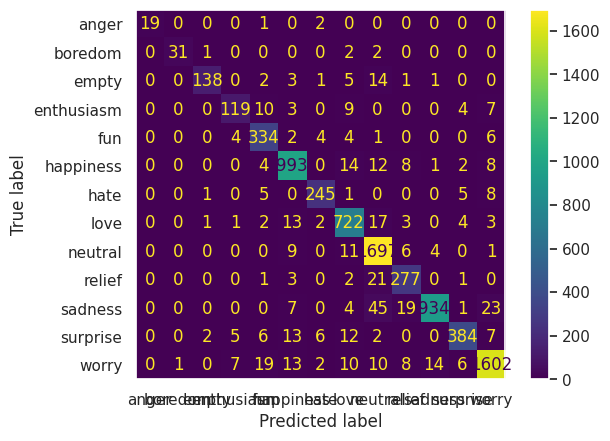

In [26]:
cm = cmt.numpy()
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels).plot()

<Axes: >

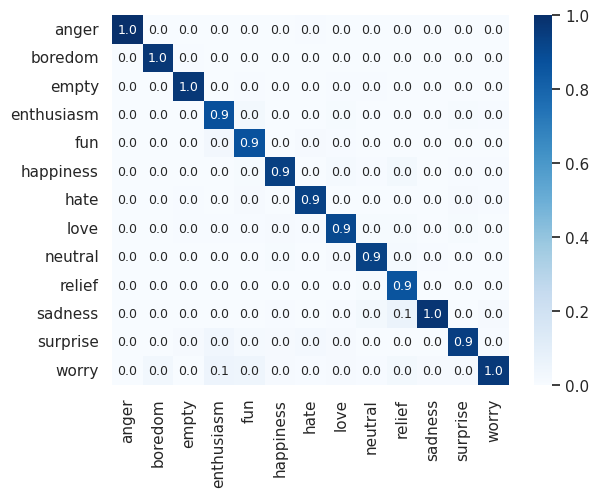

In [27]:
c = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
sns.heatmap(
    c, cmap="Blues", 
    annot=True,
    annot_kws={"size": 9},
    xticklabels=labels, 
    yticklabels=labels, fmt='.1f')

<Axes: >

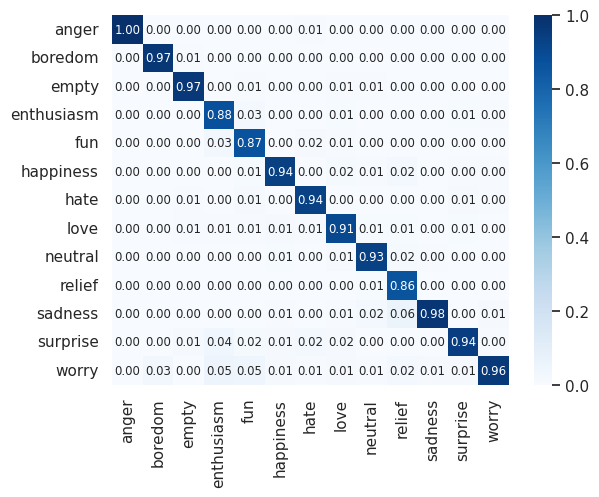

In [28]:
c = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
sns.heatmap(
    c, cmap="Blues", 
    annot=True,
    annot_kws={"size": 8.5},
    xticklabels=labels, 
    yticklabels=labels, fmt='.2f')

In [31]:
n_epoch = trainer.current_epoch
n_epoch

500

/tmp/ipykernel_3261045/3318966024.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels())


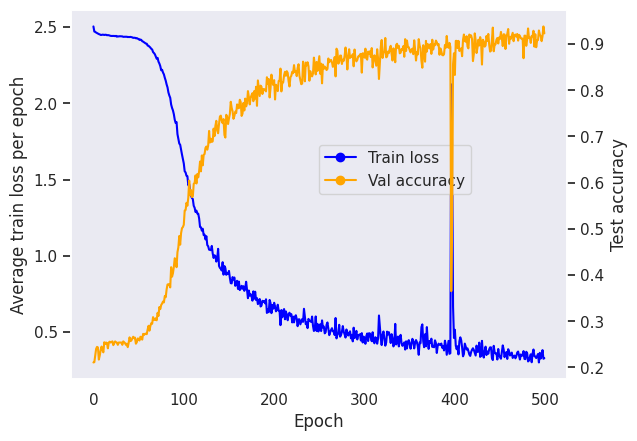

In [32]:
xval = np.arange(n_epoch)
y1val = reduce(np.array(trainer.train_losses), '(e n) -> e', 'mean',  e=n_epoch)
y2val = trainer.val_accuracy
g = sns.lineplot(x=xval, y=y1val, color='blue')
g2 = sns.lineplot(x=xval, y=y2val, color='orange', ax=g.axes.twinx())
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel('Epoch')
g.set_ylabel('Average train loss per epoch')
g2.set_ylabel('Test accuracy')
g.legend(handles=[Line2D([], [], marker='o', color='blue', label='Train loss'), 
                  Line2D([], [], marker='o', color='orange', label='Val accuracy')], 
         loc=(0.5,0.5))

In [34]:
from scipy.signal import savgol_filter

/tmp/ipykernel_3261045/909719459.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels())


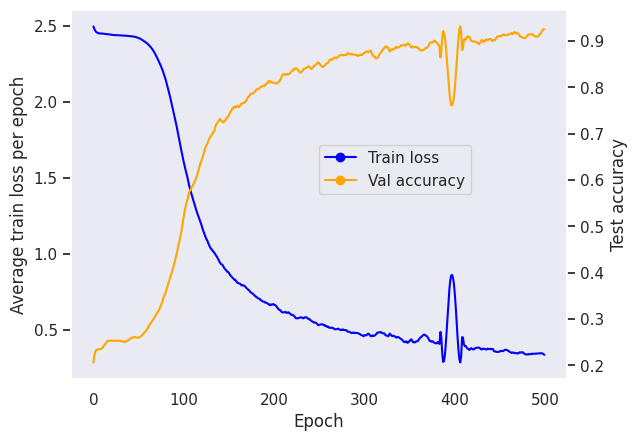

In [42]:
xval = np.arange(n_epoch)
y1val = reduce(np.array(trainer.train_losses), '(e n) -> e', 'mean',  e=n_epoch)
y2val = trainer.val_accuracy
y1val = savgol_filter(y1val, 25, 5)
y2val = savgol_filter(y2val, 25, 5)
g = sns.lineplot(x=xval, y=y1val, color='blue')
g2 = sns.lineplot(x=xval, y=y2val, color='orange', ax=g.axes.twinx())
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel('Epoch')
g.set_ylabel('Average train loss per epoch')
g2.set_ylabel('Test accuracy')
g.legend(handles=[Line2D([], [], marker='o', color='blue', label='Train loss'), 
                  Line2D([], [], marker='o', color='orange', label='Val accuracy')], 
         loc=(0.5,0.5))

In [43]:
layer_after = trainer.model.fe_blocks.blocks[0].layer.cpu()
visualize_model.print_parameters(layer_after)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000],
        [0.0035, 0.0036, 0.0042],
        [0.0075, 0.0074, 0.0074],
        [0.0119, 0.0117, 0.0117],
        [0.0162, 0.0162, 0.0162],
        [0.0211, 0.0211, 0.0211],
        [0.0264, 0.0264, 0.0264],
        [0.0322, 0.0322, 0.0322],
        [0.0380, 0.0384, 0.0385],
        [0.0452, 0.0452, 0.0451],
        [0.0524, 0.0524, 0.0524],
        [0.0603, 0.0603, 0.0603],
        [0.0688, 0.0688, 0.0688],
        [0.0741, 0.0781, 0.0780],
        [0.0885, 0.0880, 0.0879],
        [0.0988, 0.0988, 0.0988],
        [0.1105, 0.1105, 0.1105],
        [0.1229, 0.1231, 0.1211],
        [0.1372, 0.1368, 0.1367],
        [0.1516, 0.1516, 0.1516],
        [0.1676, 0.1676, 0.1676],
        [0.1849, 0.1849, 0.1849],
        [0.2037, 0.2037, 0.2037],
        [0.2239, 0.2239, 0.2239],
        [0.2458, 0.2458, 0.2458],
        [0.2696, 0.2696, 0.2696],
        [0.2952, 0.2953, 0.2953],
        [0.3227, 0.3230, 0.3231],
        [

In [50]:
filtviz_after = visualize_model.FilterVisualizer(
    lowcut_bands = layer_after.lowcut_bands, 
    bandwidths = layer_after.bandwidths,
    window_params = layer_after.window_params, 
    window_length = 64,
    sample_rate = 177*2
)

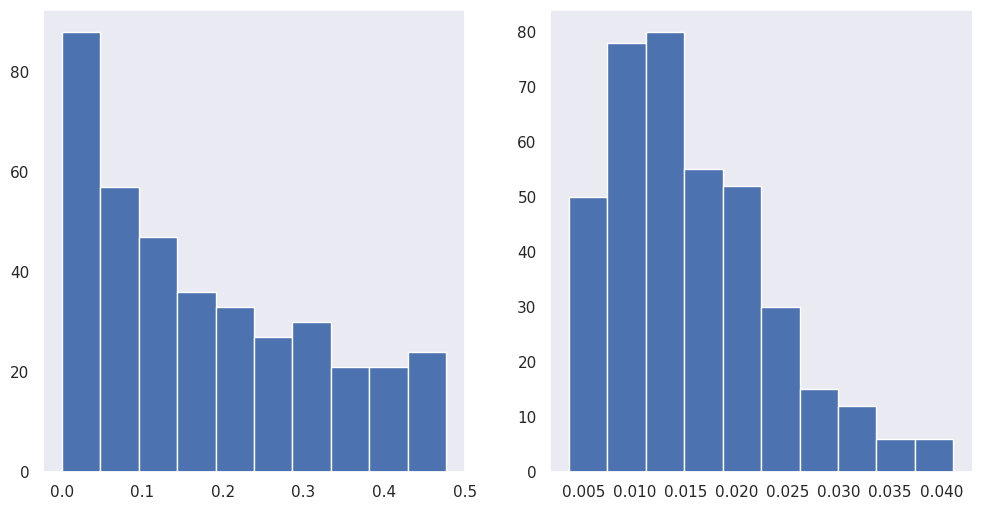

In [51]:
filtviz_after.visualize_bands()

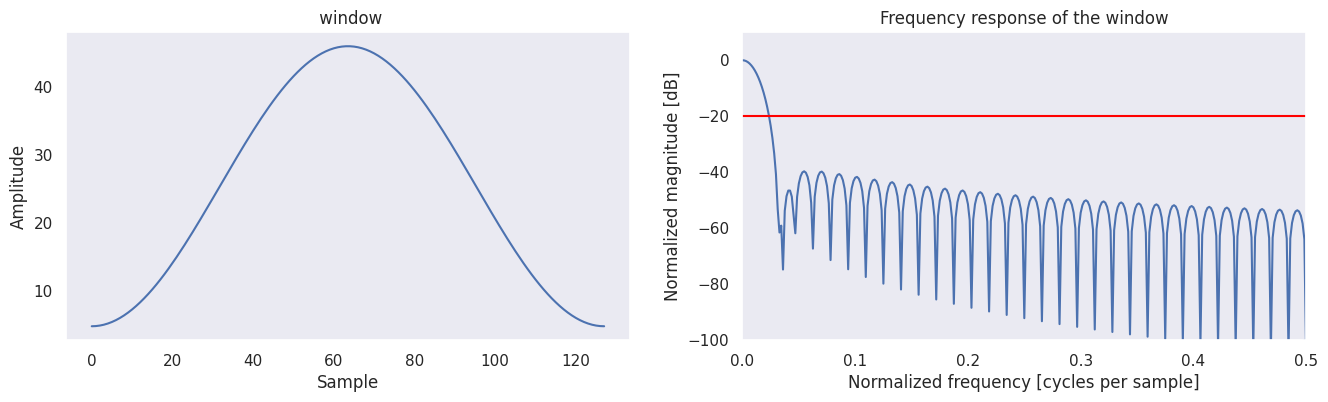

In [52]:
filtviz_after.visualize_one_window()

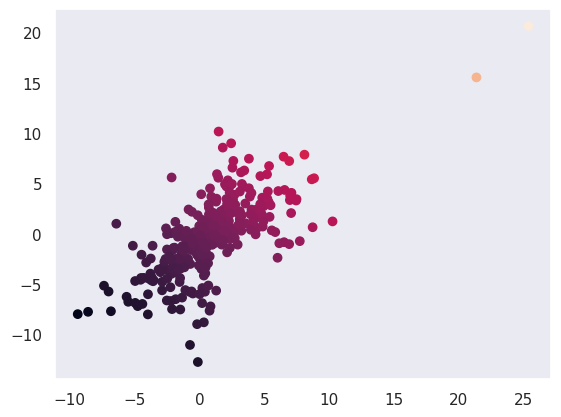

In [53]:
filtviz_after.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


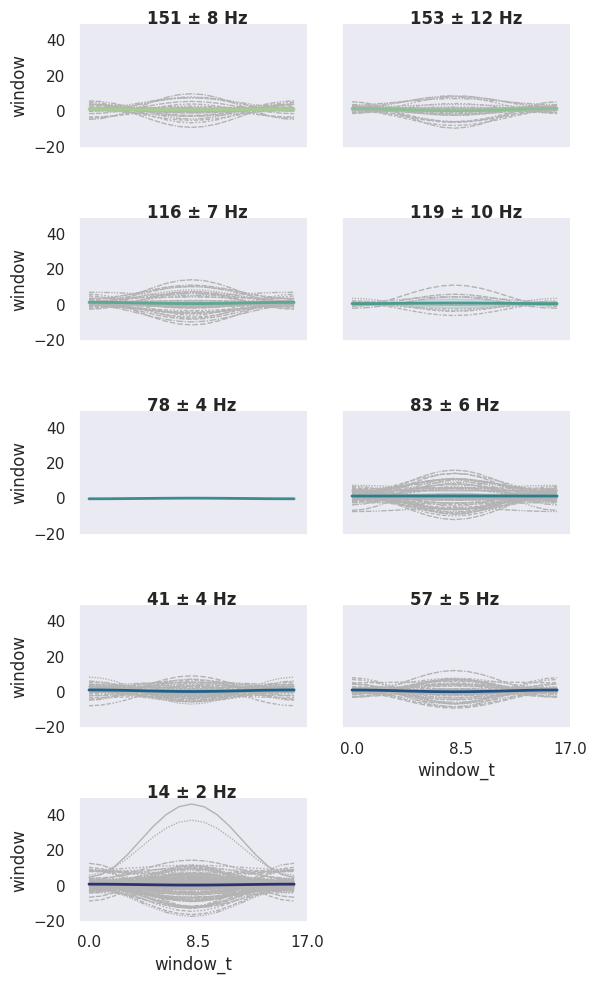

In [54]:
filtviz_after.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


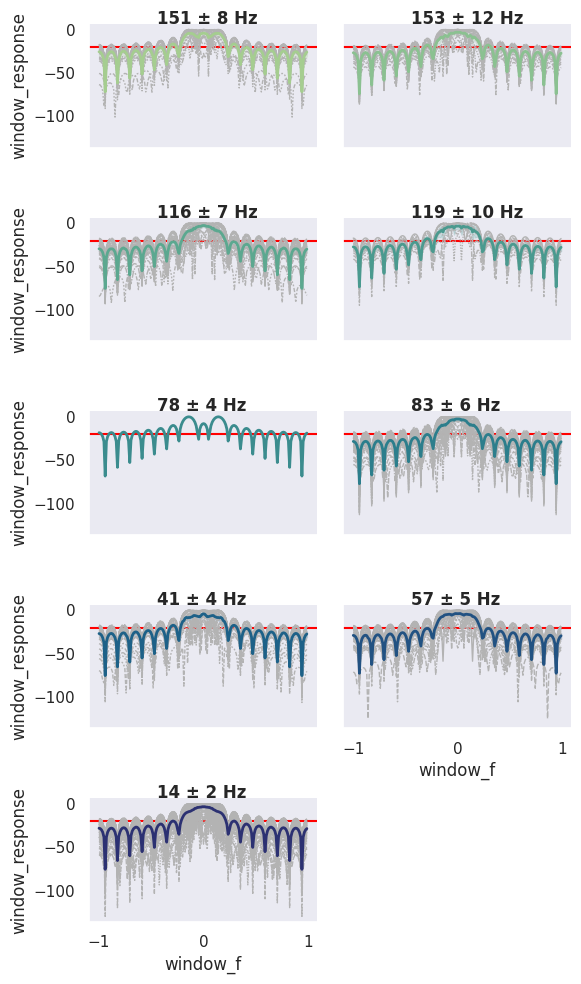

In [55]:
filtviz_after.visualize_filters(filter_domain='freq')

In [56]:
ckpt_path = log_dir + 'iconnet_text_m11_v6_epoch500.ckpt'
torch.save({
    'epoch': n_epoch,
    'model_state_dict': trainer.model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'train_losses': trainer.train_losses,
    'val_accuracy': trainer.val_accuracy,
    'test_accuracy': trainer.test_accuracy,
    'best_model': trainer.best_test_model_path,
    'metrics': mt,
    'metrics_detai;': mtd,
    'confusion_matrix': cm
}, ckpt_path)